
--- Intrinsic Value Calculation: Wipro ---

EBIT: ₹159,762,000,000
Depreciation: ₹34,071,000,000
CapEx: ₹0
Change in Working Capital: ₹4,861,000,000
FCFF (Current): ₹149,031,500,000
Beta: 0.658
Cost of Equity: 9.95%
Cost of Debt: 20.15%
WACC: 10.07%
Enterprise Value: ₹3,511,187,400,690
Equity Value: ₹3,448,887,400,690
Intrinsic Value per Share: ₹329.71
Current Market Price: ₹246.3


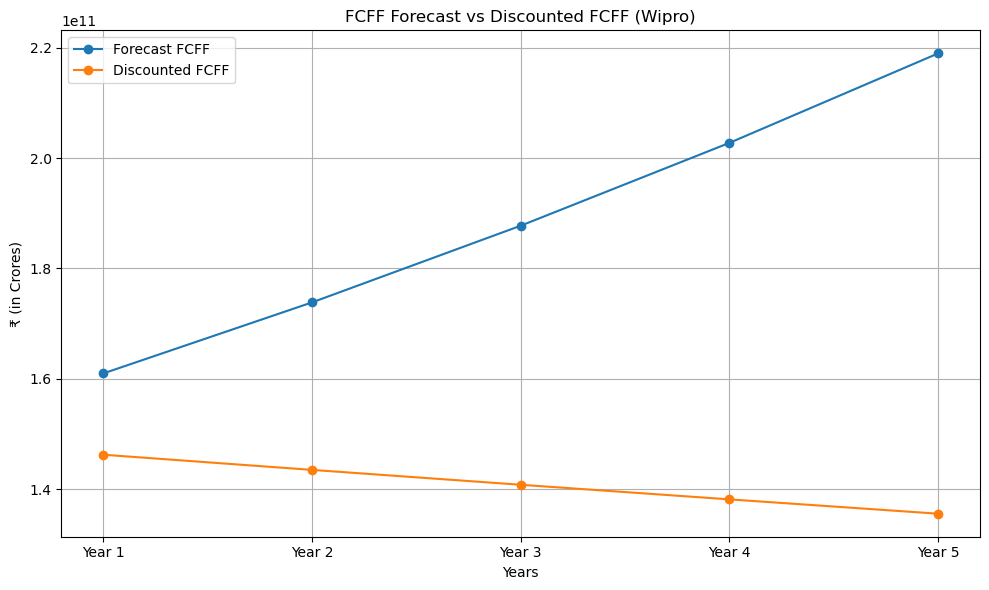

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define ticker
ticker = yf.Ticker("WIPRO.NS")

# Pull data
info = ticker.info
financials = ticker.financials
balance_sheet = ticker.balance_sheet
cashflow = ticker.cashflow

# Helper functions
def get_value(data, key):
    try:
        return data.loc[key].iloc[0]
    except:
        return np.nan

def get_best_match(data, candidates):
    for key in candidates:
        if key in data.index:
            return data.loc[key]
    return pd.Series([np.nan] * data.shape[1], index=data.columns)

# --------------------------
# Core Financial Components
# --------------------------

# EBIT and Depreciation
ebit = get_value(financials, "EBIT")
depreciation = get_value(cashflow, "Depreciation")

# CapEx fallback handling
capex = get_value(cashflow, "Capital Expenditures")
if pd.isna(capex):
    capex = get_value(cashflow, "Investments in Property, Plant and Equipment")
if pd.isna(capex):
    capex = 0  # Fallback to zero if nothing is found

# Change in Working Capital
current_assets = get_best_match(balance_sheet, ["Total Current Assets", "Current Assets"])
current_liabilities = get_best_match(balance_sheet, ["Total Current Liabilities", "Current Liabilities"])

try:
    wc_current = current_assets.iloc[0] - current_liabilities.iloc[0]
    wc_prev = current_assets.iloc[1] - current_liabilities.iloc[1]
    change_in_wc = wc_current - wc_prev
except:
    change_in_wc = 0

# --------------------------
# Capital Structure
# --------------------------

short_term_debt = get_value(balance_sheet, "Short Long Term Debt")
long_term_debt = get_value(balance_sheet, "Long Term Debt")
cash = get_value(balance_sheet, "Cash and Cash Equivalents") or get_value(balance_sheet, "Cash")

total_debt = 0 if pd.isna(short_term_debt) else short_term_debt
total_debt += 0 if pd.isna(long_term_debt) else long_term_debt

cash = 0 if pd.isna(cash) else cash

# Shares & Market Info
shares_outstanding = info.get("sharesOutstanding", np.nan)
market_cap = info.get("marketCap", np.nan)
current_price = info.get("currentPrice", np.nan)
beta = info.get("beta", 1)

# --------------------------
# Cost of Capital
# --------------------------

risk_free_rate = 0.06   # Assume 6% for Indian market
market_return = 0.12    # Long-term market average return

cost_of_equity = risk_free_rate + beta * (market_return - risk_free_rate)

interest_expense = get_value(financials, "Interest Expense")
if total_debt > 0 and interest_expense and not pd.isna(interest_expense):
    cost_of_debt = abs(interest_expense) / total_debt
else:
    cost_of_debt = 0

# WACC
V = market_cap + total_debt
E = market_cap
D = total_debt

if V == 0:
    wacc = cost_of_equity
else:
    wacc = (E / V) * cost_of_equity + (D / V) * cost_of_debt * (1 - 0.25)

# --------------------------
# FCFF and Valuation
# --------------------------

tax_rate = 0.25  # Assume 25%
fcff = ebit * (1 - tax_rate) + depreciation - capex - change_in_wc

# Forecast future FCFFs
years = 5
growth_rate = 0.08
fcff_forecast = [fcff * ((1 + growth_rate) ** i) for i in range(1, years + 1)]
discounted_fcff = [fcff_forecast[i] / ((1 + wacc) ** (i + 1)) for i in range(years)]

# Terminal Value
terminal_growth = 0.05
if wacc > terminal_growth:
    terminal_value = fcff_forecast[-1] * (1 + terminal_growth) / (wacc - terminal_growth)
    discounted_terminal_value = terminal_value / ((1 + wacc) ** years)
else:
    terminal_value = 0
    discounted_terminal_value = 0

# Final Valuation
enterprise_value = sum(discounted_fcff) + discounted_terminal_value
equity_value = enterprise_value - total_debt + cash
intrinsic_value_per_share = equity_value / shares_outstanding if shares_outstanding else np.nan

# --------------------------
# Output
# --------------------------
print("\n--- Intrinsic Value Calculation: Wipro ---\n")
print(f"EBIT: ₹{ebit:,.0f}")
print(f"Depreciation: ₹{depreciation:,.0f}")
print(f"CapEx: ₹{capex:,.0f}")
print(f"Change in Working Capital: ₹{change_in_wc:,.0f}")
print(f"FCFF (Current): ₹{fcff:,.0f}")
print(f"Beta: {beta}")
print(f"Cost of Equity: {cost_of_equity:.2%}")
print(f"Cost of Debt: {cost_of_debt:.2%}")
print(f"WACC: {wacc:.2%}")
print(f"Enterprise Value: ₹{enterprise_value:,.0f}")
print(f"Equity Value: ₹{equity_value:,.0f}")
print(f"Intrinsic Value per Share: ₹{intrinsic_value_per_share:.2f}")
print(f"Current Market Price: ₹{current_price}")

# --------------------------
# Plot
# --------------------------
plt.figure(figsize=(10, 6))
x_labels = [f"Year {i+1}" for i in range(years)]
plt.plot(x_labels, fcff_forecast, label="Forecast FCFF", marker='o')
plt.plot(x_labels, discounted_fcff, label="Discounted FCFF", marker='o')
plt.title("FCFF Forecast vs Discounted FCFF (Wipro)")
plt.xlabel("Years")
plt.ylabel("₹ (in Crores)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [2]:
import yfinance as yf
import numpy as np

def list_keys(df, label):
    print(f"\nAvailable keys in {label}:")
    for key in df.index:
        print("-", key)

def safe_get(statement, key, label=None):
    """Get a numeric value from a financial statement safely."""
    try:
        if key in statement.index:
            val = statement.loc[key]
        elif label:
            list_keys(statement, label)
            raise KeyError(f"'{key}' not found in {label}")
        else:
            raise KeyError(f"'{key}' not found")
        
        if isinstance(val, (float, int)):
            return float(val)
        elif hasattr(val, "first_valid_index") and val.first_valid_index() is not None:
            return float(val[val.first_valid_index()])
        return 0.0
    except Exception as e:
        print(f"[Error] {key}: {e}")
        return 0.0

ticker = "WIPRO.NS"
stock = yf.Ticker(ticker)

# Fetch financials
is_ = stock.financials
bs = stock.balance_sheet
cf = stock.cashflow
info = stock.info

# Prices & Shares
current_price = info.get("currentPrice", 0.0)
shares_outstanding = info.get("sharesOutstanding", 1)

# Income Statement
ebit = safe_get(is_, "EBIT", "Income Statement")
dep = safe_get(cf, "Depreciation", "Cash Flow")
capex = -safe_get(cf, "Capital Expenditures", "Cash Flow")
change_wc = safe_get(cf, "Change In Working Capital", "Cash Flow")
tax_expense = safe_get(is_, "Income Tax Expense", "Income Statement")
ebt = safe_get(is_, "EBT", "Income Statement") or safe_get(is_, "Pretax Income", "Income Statement")
net_income = safe_get(is_, "Net Income", "Income Statement")
revenue = safe_get(is_, "Total Revenue", "Income Statement")

# Balance Sheet
total_equity = safe_get(bs, "Total Equity Gross Minority Interest", "Balance Sheet")
total_assets = safe_get(bs, "Total Assets", "Balance Sheet")
current_assets = safe_get(bs, "Current Assets", "Balance Sheet")
current_liabilities = safe_get(bs, "Current Liabilities", "Balance Sheet")
inventory = safe_get(bs, "Inventory", "Balance Sheet")
cash = safe_get(bs, "Cash And Cash Equivalents", "Balance Sheet")
debt = safe_get(bs, "Long Term Debt", "Balance Sheet")

# Tax rate
tax_rate = tax_expense / ebt if ebt else 0.25

# FCFF
fcff = ebit * (1 - tax_rate) + dep - capex - change_wc

# DCF
discount_rate = 0.10
terminal_growth = 0.04
fcff_next = fcff * (1 + terminal_growth)
terminal_value = fcff_next / (discount_rate - terminal_growth) if discount_rate != terminal_growth else 0.0
enterprise_value = terminal_value
equity_value = enterprise_value + cash - debt
intrinsic_value_per_share = equity_value / shares_outstanding if shares_outstanding else 0.0

# Ratios
eps = net_income / shares_outstanding if shares_outstanding else 0.0
bvps = total_equity / shares_outstanding if shares_outstanding else 0.0
pe_ratio = current_price / eps if eps else 0.0
pb_ratio = current_price / bvps if bvps else 0.0
ebitda = ebit + dep
ev_ebitda = enterprise_value / ebitda if ebitda else 0.0
roe = net_income / total_equity if total_equity else 0.0
roa = net_income / total_assets if total_assets else 0.0
asset_turnover = revenue / total_assets if total_assets else 0.0
current_ratio = current_assets / current_liabilities if current_liabilities else 0.0
quick_ratio = (current_assets - inventory) / current_liabilities if current_liabilities else 0.0
capital_employed = total_assets - current_liabilities if total_assets > current_liabilities else 1.0
roce = ebit / capital_employed if capital_employed else 0.0

def format_currency(val):
    return f"₹{val:,.0f}"

# Output
print("\n--- Intrinsic Value Calculation: Wipro Limited ---\n")
print(f"EBIT: {format_currency(ebit)}")
print(f"Depreciation: {format_currency(dep)}")
print(f"CapEx: {format_currency(capex)}")
print(f"Change in Working Capital: {format_currency(change_wc)}")
print(f"FCFF (Current): {format_currency(fcff)}")
print(f"Enterprise Value: {format_currency(enterprise_value)}")
print(f"Equity Value: {format_currency(equity_value)}")
print(f"Intrinsic Value per Share: ₹{intrinsic_value_per_share:.2f}")
print(f"Current Market Price: ₹{current_price:.2f}\n")

print("--- Key Financial Ratios ---\n")
print(f"P/E: {pe_ratio:.2f}")
print(f"P/B: {pb_ratio:.2f}")
print(f"EV/EBITDA: {ev_ebitda:.2f}")
print(f"ROE: {roe * 100:.2f}%")
print(f"ROA: {roa * 100:.2f}%")
print(f"ROCE: {roce * 100:.2f}%")
print(f"Asset Turnover: {asset_turnover:.2f}")
print(f"Current Ratio: {current_ratio:.2f}")
print(f"Quick Ratio: {quick_ratio:.2f}")


Available keys in Cash Flow:
- Free Cash Flow
- Repurchase Of Capital Stock
- Repayment Of Debt
- Issuance Of Debt
- Issuance Of Capital Stock
- Capital Expenditure
- End Cash Position
- Beginning Cash Position
- Effect Of Exchange Rate Changes
- Changes In Cash
- Financing Cash Flow
- Cash Flow From Continuing Financing Activities
- Net Other Financing Charges
- Interest Paid Cff
- Cash Dividends Paid
- Common Stock Dividend Paid
- Net Common Stock Issuance
- Common Stock Payments
- Common Stock Issuance
- Net Issuance Payments Of Debt
- Net Long Term Debt Issuance
- Long Term Debt Payments
- Long Term Debt Issuance
- Investing Cash Flow
- Cash Flow From Continuing Investing Activities
- Net Other Investing Changes
- Interest Received Cfi
- Dividends Received Cfi
- Net Investment Purchase And Sale
- Sale Of Investment
- Purchase Of Investment
- Net Business Purchase And Sale
- Sale Of Business
- Purchase Of Business
- Net PPE Purchase And Sale
- Sale Of PPE
- Purchase Of PPE
- Operat


Available keys in Cash Flow:
- Free Cash Flow
- Repurchase Of Capital Stock
- Repayment Of Debt
- Issuance Of Debt
- Issuance Of Capital Stock
- Capital Expenditure
- End Cash Position
- Beginning Cash Position
- Effect Of Exchange Rate Changes
- Changes In Cash
- Financing Cash Flow
- Cash Flow From Continuing Financing Activities
- Net Other Financing Charges
- Interest Paid Cff
- Cash Dividends Paid
- Common Stock Dividend Paid
- Net Common Stock Issuance
- Common Stock Payments
- Common Stock Issuance
- Net Issuance Payments Of Debt
- Net Long Term Debt Issuance
- Long Term Debt Payments
- Long Term Debt Issuance
- Investing Cash Flow
- Cash Flow From Continuing Investing Activities
- Net Other Investing Changes
- Interest Received Cfi
- Dividends Received Cfi
- Net Investment Purchase And Sale
- Sale Of Investment
- Purchase Of Investment
- Net Business Purchase And Sale
- Sale Of Business
- Purchase Of Business
- Net PPE Purchase And Sale
- Sale Of PPE
- Purchase Of PPE
- Operat

/var/folders/6v/9qg480fs1tl47ks4b9pr9dmr0000gn/T/ipykernel_17587/2624296303.py:199: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Type', y='Value', data=comparison, palette=colors, ax=ax1)
/var/folders/6v/9qg480fs1tl47ks4b9pr9dmr0000gn/T/ipykernel_17587/2624296303.py:251: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Component', y='Value', data=dcf_components, palette=['#3498db', '#e74c3c', '#2ecc71'], ax=ax4)
/var/folders/6v/9qg480fs1tl47ks4b9pr9dmr0000gn/T/ipykernel_17587/2624296303.py:372: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.3, hspace=0.4)
/var/

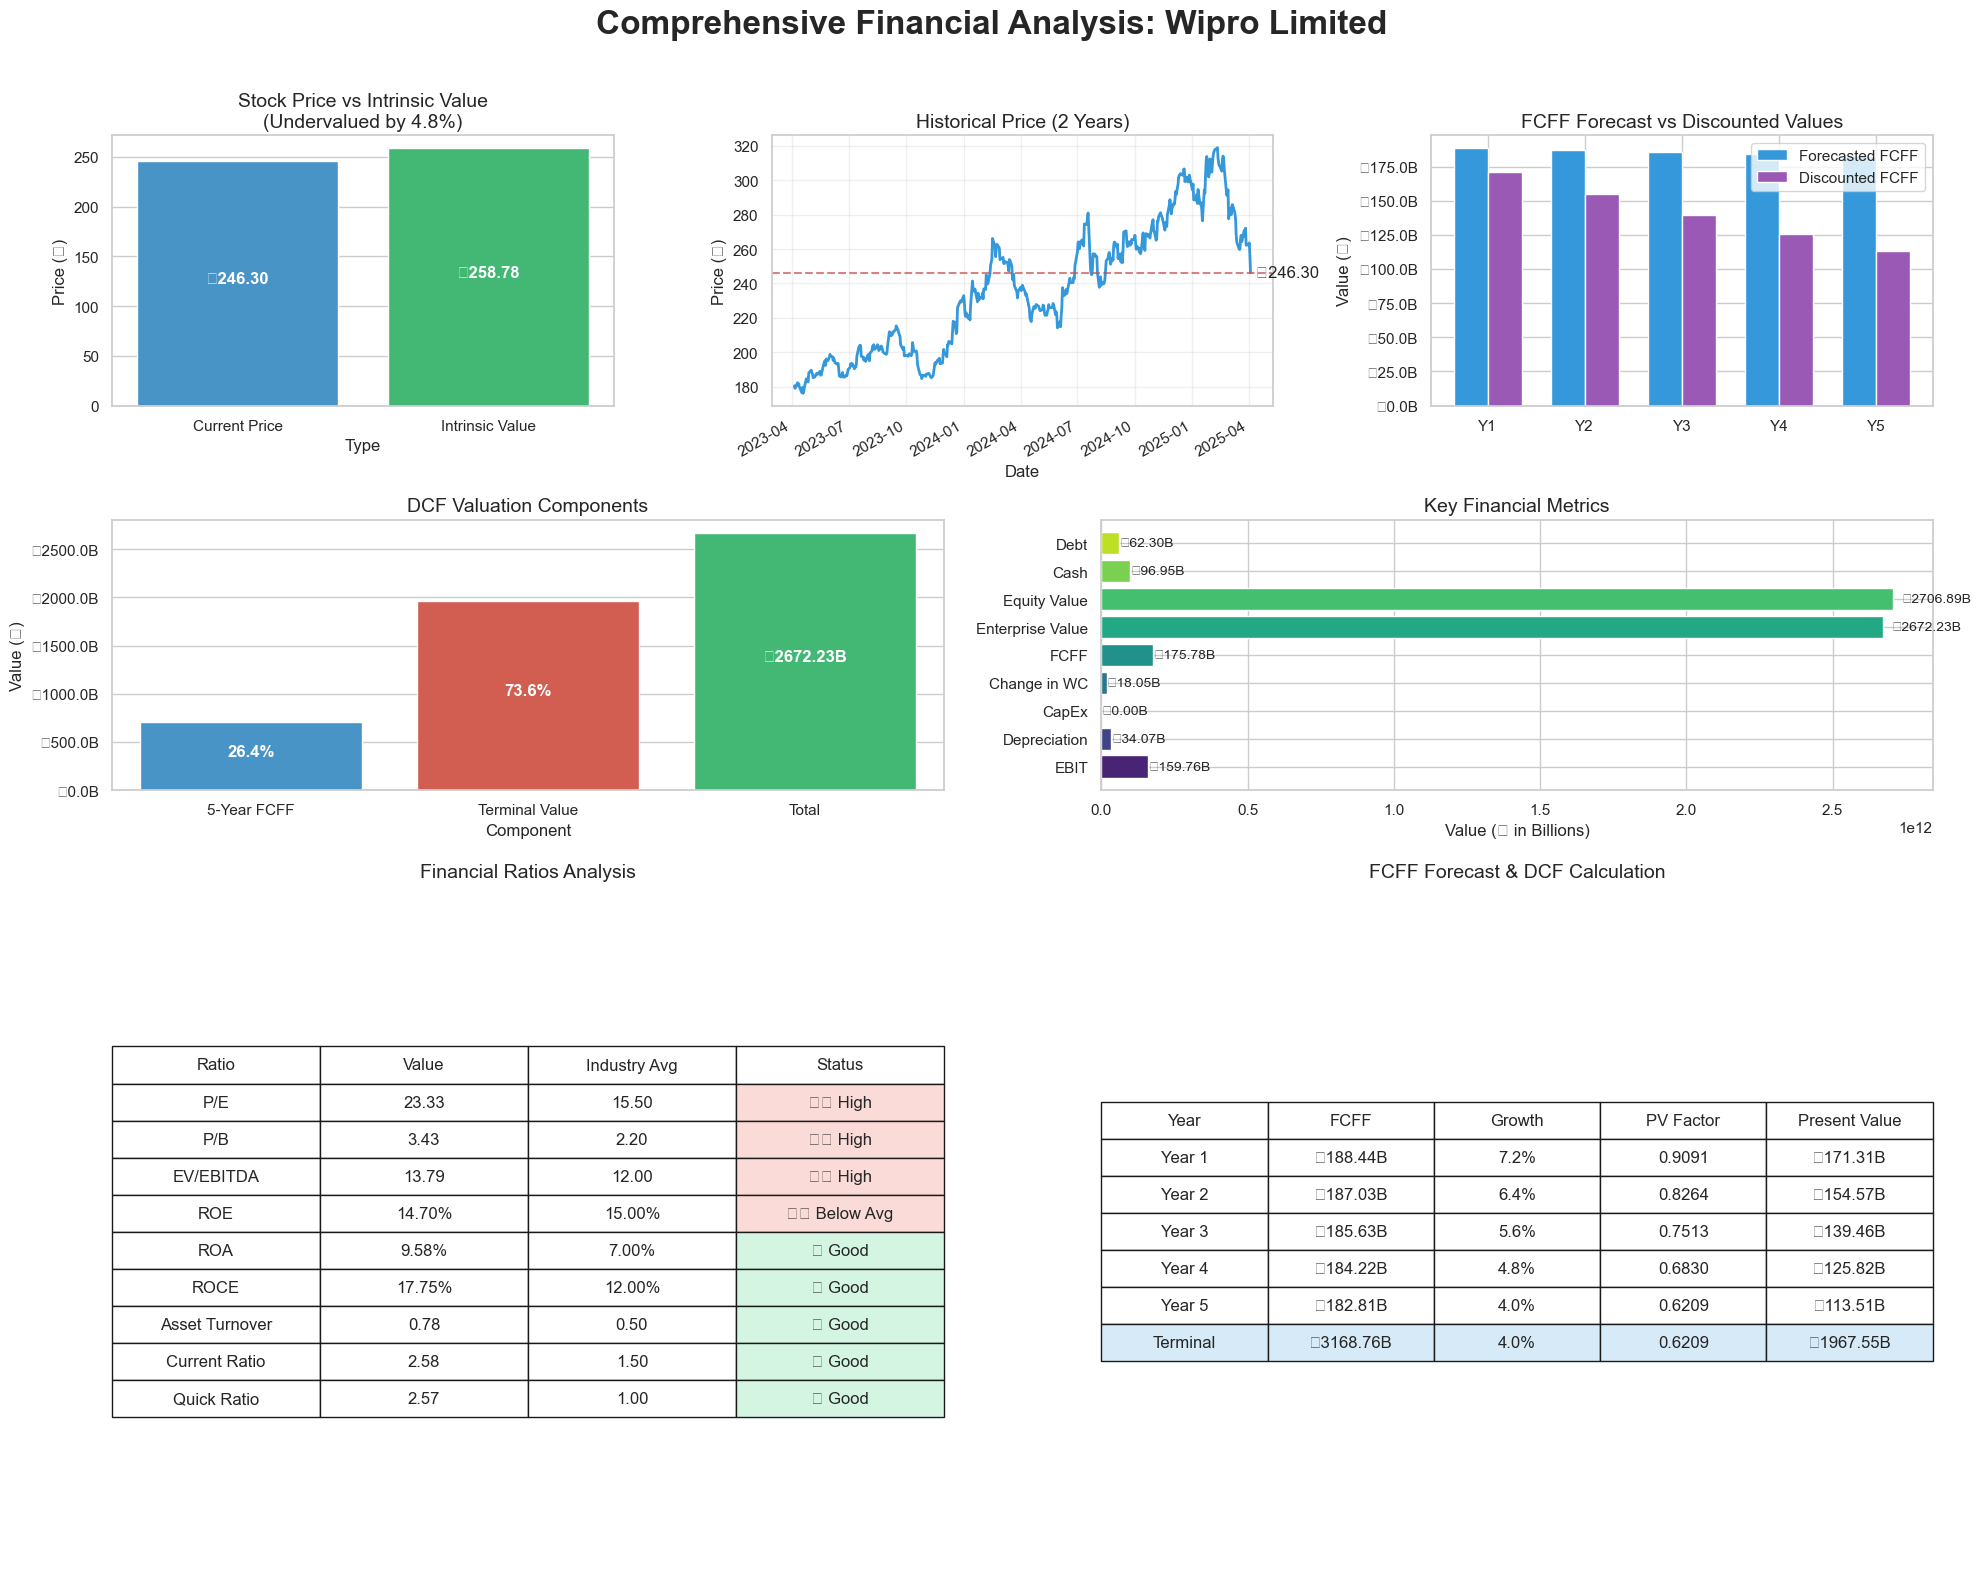


Summary for Wipro Ltd:
Current Market Price: ₹246.30
Intrinsic Value per Share: ₹258.78
Stock is UNDERVALUED with 5.1% potential upside


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from tabulate import tabulate

def list_keys(df, label):
    print(f"\nAvailable keys in {label}:")
    for key in df.index:
        print("-", key)

def safe_get(statement, key, label=None):
    """Get a numeric value from a financial statement safely."""
    try:
        if key in statement.index:
            val = statement.loc[key]
        elif label:
            list_keys(statement, label)
            raise KeyError(f"'{key}' not found in {label}")
        else:
            raise KeyError(f"'{key}' not found")
        
        if isinstance(val, (float, int)):
            return float(val)
        elif hasattr(val, "first_valid_index") and val.first_valid_index() is not None:
            return float(val[val.first_valid_index()])
        return 0.0
    except Exception as e:
        print(f"[Error] {key}: {e}")
        return 0.0

def format_currency(val):
    return f"₹{val:,.0f}"

def analyze_stock(ticker_symbol, forecast_years=5):
    # Fetch data
    stock = yf.Ticker(ticker_symbol)
    
    # Fetch financials
    is_ = stock.financials
    bs = stock.balance_sheet
    cf = stock.cashflow
    info = stock.info
    hist = stock.history(period="2y")
    
    # Prices & Shares
    current_price = info.get("currentPrice", 0.0)
    shares_outstanding = info.get("sharesOutstanding", 1)
    company_name = info.get("longName", ticker_symbol)
    
    # Income Statement
    ebit = safe_get(is_, "EBIT", "Income Statement")
    dep = safe_get(cf, "Depreciation", "Cash Flow")
    capex = -safe_get(cf, "Capital Expenditures", "Cash Flow")
    change_wc = safe_get(cf, "Change In Working Capital", "Cash Flow")
    tax_expense = safe_get(is_, "Income Tax Expense", "Income Statement")
    ebt = safe_get(is_, "EBT", "Income Statement") or safe_get(is_, "Pretax Income", "Income Statement")
    net_income = safe_get(is_, "Net Income", "Income Statement")
    revenue = safe_get(is_, "Total Revenue", "Income Statement")
    
    # Balance Sheet
    total_equity = safe_get(bs, "Total Equity Gross Minority Interest", "Balance Sheet")
    total_assets = safe_get(bs, "Total Assets", "Balance Sheet")
    current_assets = safe_get(bs, "Current Assets", "Balance Sheet")
    current_liabilities = safe_get(bs, "Current Liabilities", "Balance Sheet")
    inventory = safe_get(bs, "Inventory", "Balance Sheet")
    cash = safe_get(bs, "Cash And Cash Equivalents", "Balance Sheet")
    debt = safe_get(bs, "Long Term Debt", "Balance Sheet")
    
    # Tax rate
    tax_rate = tax_expense / ebt if ebt else 0.25
    
    # FCFF
    fcff = ebit * (1 - tax_rate) + dep - capex - change_wc
    
    # DCF Model parameters
    discount_rate = 0.10
    terminal_growth = 0.04
    
    # Generate forecast for next 5 years
    forecast_data = []
    fcff_forecast = []
    dcf_values = []
    cumulative_pv = 0
    
    for year in range(1, forecast_years + 1):
        growth_rate = terminal_growth + (0.04 * (forecast_years - year) / forecast_years)  # Higher growth initially
        fcff_next = fcff * (1 + growth_rate)
        fcff_forecast.append(fcff_next)
        
        # Calculate present value
        pv_factor = 1 / ((1 + discount_rate) ** year)
        pv = fcff_next * pv_factor
        dcf_values.append(pv)
        cumulative_pv += pv
        
        forecast_data.append({
            'Year': f'Year {year}',
            'FCFF': fcff_next,
            'Growth': f'{growth_rate*100:.1f}%',
            'PV Factor': f'{pv_factor:.4f}',
            'Present Value': pv
        })
    
    # Calculate terminal value
    terminal_fcff = fcff_forecast[-1] * (1 + terminal_growth)
    terminal_value = terminal_fcff / (discount_rate - terminal_growth)
    terminal_value_pv = terminal_value / ((1 + discount_rate) ** forecast_years)
    
    # Enterprise and Equity value
    enterprise_value = cumulative_pv + terminal_value_pv
    equity_value = enterprise_value + cash - debt
    intrinsic_value_per_share = equity_value / shares_outstanding if shares_outstanding else 0.0
    
    # Ratios
    eps = net_income / shares_outstanding if shares_outstanding else 0.0
    bvps = total_equity / shares_outstanding if shares_outstanding else 0.0
    pe_ratio = current_price / eps if eps else 0.0
    pb_ratio = current_price / bvps if bvps else 0.0
    ebitda = ebit + dep
    ev_ebitda = enterprise_value / ebitda if ebitda else 0.0
    roe = net_income / total_equity if total_equity else 0.0
    roa = net_income / total_assets if total_assets else 0.0
    asset_turnover = revenue / total_assets if total_assets else 0.0
    current_ratio = current_assets / current_liabilities if current_liabilities else 0.0
    quick_ratio = (current_assets - inventory) / current_liabilities if current_liabilities else 0.0
    capital_employed = total_assets - current_liabilities if total_assets > current_liabilities else 1.0
    roce = ebit / capital_employed if capital_employed else 0.0
    
    # Prepare visualization
    visualize_analysis(
        company_name,
        current_price,
        intrinsic_value_per_share,
        forecast_data,
        fcff,
        fcff_forecast,
        dcf_values,
        terminal_value,
        terminal_value_pv,
        hist,
        {
            'P/E': pe_ratio,
            'P/B': pb_ratio,
            'EV/EBITDA': ev_ebitda,
            'ROE': roe * 100,
            'ROA': roa * 100,
            'ROCE': roce * 100,
            'Asset Turnover': asset_turnover,
            'Current Ratio': current_ratio,
            'Quick Ratio': quick_ratio
        },
        {
            'EBIT': ebit,
            'Depreciation': dep,
            'CapEx': capex,
            'Change in WC': change_wc,
            'FCFF': fcff,
            'Enterprise Value': enterprise_value,
            'Equity Value': equity_value,
            'Cash': cash,
            'Debt': debt
        }
    )
    
    return {
        'current_price': current_price,
        'intrinsic_value': intrinsic_value_per_share,
        'enterprise_value': enterprise_value,
        'equity_value': equity_value
    }

def visualize_analysis(company_name, current_price, intrinsic_value, forecast_data, 
                       current_fcff, fcff_forecast, dcf_values, terminal_value,
                       terminal_value_pv, hist_data, ratios, key_financials):
    """Create comprehensive visualizations for the stock analysis"""
    # Set style
    sns.set(style="whitegrid")
    plt.rcParams['figure.figsize'] = (20, 16)
    plt.rcParams['font.family'] = 'sans-serif'
    
    # Create figure with grid
    fig = plt.figure(constrained_layout=True)
    gs = GridSpec(4, 6, figure=fig)
    
    # Title for the entire analysis
    fig.suptitle(f"Comprehensive Financial Analysis: {company_name}", fontsize=24, fontweight='bold', y=0.98)
    
    # 1. Stock Price vs Intrinsic Value (Top left)
    ax1 = fig.add_subplot(gs[0, 0:2])
    comparison = pd.DataFrame({
        'Value': [current_price, intrinsic_value],
        'Type': ['Current Price', 'Intrinsic Value']
    })
    
    colors = ['#3498db', '#e74c3c'] if current_price > intrinsic_value else ['#3498db', '#2ecc71']
    sns.barplot(x='Type', y='Value', data=comparison, palette=colors, ax=ax1)
    for i, v in enumerate(comparison['Value']):
        ax1.text(i, v/2, f"₹{v:.2f}", ha='center', fontsize=12, color='white', fontweight='bold')
    
    overunder = "Overvalued" if current_price > intrinsic_value else "Undervalued"
    diff_pct = abs(current_price - intrinsic_value) / intrinsic_value * 100
    ax1.set_title(f"Stock Price vs Intrinsic Value\n({overunder} by {diff_pct:.1f}%)", fontsize=14)
    ax1.set_ylabel("Price (₹)", fontsize=12)
    
    # 2. Historical Price Chart (Top center)
    ax2 = fig.add_subplot(gs[0, 2:4])
    hist_data['Close'].plot(ax=ax2, linewidth=2, color='#3498db')
    ax2.axhline(y=current_price, color='r', linestyle='--', alpha=0.7)
    ax2.text(hist_data.index[-1], current_price, f" ₹{current_price:.2f}", va='center')
    ax2.set_title(f"Historical Price (2 Years)", fontsize=14)
    ax2.set_ylabel("Price (₹)", fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # 3. FCFF vs Discounted FCFF (Top right)
    ax3 = fig.add_subplot(gs[0, 4:6])
    years = [f'Y{i+1}' for i in range(len(fcff_forecast))]
    fcff_df = pd.DataFrame({
        'Year': years,
        'Forecasted FCFF': fcff_forecast,
        'Discounted FCFF': dcf_values
    })
    
    width = 0.35
    x = np.arange(len(years))
    ax3.bar(x - width/2, fcff_df['Forecasted FCFF'], width, label='Forecasted FCFF', color='#3498db')
    ax3.bar(x + width/2, fcff_df['Discounted FCFF'], width, label='Discounted FCFF', color='#9b59b6')
    ax3.set_xticks(x)
    ax3.set_xticklabels(years)
    ax3.set_title("FCFF Forecast vs Discounted Values", fontsize=14)
    ax3.set_ylabel("Value (₹)", fontsize=12)
    ax3.legend()
    
    # Format y-axis for large numbers
    def billions_formatter(x, pos):
        return f'₹{x/1e9:.1f}B'
    
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(billions_formatter))
    
    # 4. DCF Breakdown (Middle left)
    ax4 = fig.add_subplot(gs[1, 0:3])
    dcf_components = pd.DataFrame({
        'Component': ['5-Year FCFF', 'Terminal Value', 'Total'],
        'Value': [sum(dcf_values), terminal_value_pv, sum(dcf_values) + terminal_value_pv],
        'Percentage': [sum(dcf_values)/(sum(dcf_values) + terminal_value_pv)*100, 
                      terminal_value_pv/(sum(dcf_values) + terminal_value_pv)*100, 100]
    })
    
    sns.barplot(x='Component', y='Value', data=dcf_components, palette=['#3498db', '#e74c3c', '#2ecc71'], ax=ax4)
    
    # Add percentage labels
    for i, v in enumerate(dcf_components['Value']):
        if i < 2:  # Only for the first two bars
            percentage = dcf_components['Percentage'][i]
            ax4.text(i, v/2, f"{percentage:.1f}%", ha='center', fontsize=12, color='white', fontweight='bold')
        else:
            ax4.text(i, v/2, f"₹{v/1e9:.2f}B", ha='center', fontsize=12, color='white', fontweight='bold')
    
    ax4.set_title("DCF Valuation Components", fontsize=14)
    ax4.set_ylabel("Value (₹)", fontsize=12)
    ax4.yaxis.set_major_formatter(plt.FuncFormatter(billions_formatter))
    
    # 5. Key Financial Metrics (Middle right)
    ax5 = fig.add_subplot(gs[1, 3:6])
    metrics = pd.DataFrame({
        'Metric': list(key_financials.keys()),
        'Value': list(key_financials.values())
    })
    
    colors = sns.color_palette("viridis", len(metrics))
    bars = ax5.barh(metrics['Metric'], metrics['Value'], color=colors)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax5.text(width*1.01, bar.get_y() + bar.get_height()/2, 
                f'₹{width/1e9:.2f}B', va='center', fontsize=10)
    
    ax5.set_title("Key Financial Metrics", fontsize=14)
    ax5.set_xlabel("Value (₹ in Billions)", fontsize=12)
    
    # 6. Financial Ratios Table (Bottom left)
    ax6 = fig.add_subplot(gs[2:, 0:3])
    ax6.axis('tight')
    ax6.axis('off')
    
    # Prepare ratios data with industry averages (example)
    ratio_table = []
    industry_avg = {
        'P/E': 15.5, 'P/B': 2.2, 'EV/EBITDA': 12.0, 'ROE': 15.0, 
        'ROA': 7.0, 'ROCE': 12.0, 'Asset Turnover': 0.5, 
        'Current Ratio': 1.5, 'Quick Ratio': 1.0
    }
    
    for key, value in ratios.items():
        status = ""
        if key in ['ROE', 'ROA', 'ROCE', 'Asset Turnover', 'Current Ratio', 'Quick Ratio']:
            status = "✅ Good" if value > industry_avg[key] else "⚠️ Below Avg"
        else:
            if key in ['P/E', 'P/B', 'EV/EBITDA']:
                status = "✅ Good" if value < industry_avg[key] else "⚠️ High"
        
        if key in ['ROE', 'ROA', 'ROCE']:
            value_str = f"{value:.2f}%"
            benchmark = f"{industry_avg[key]:.2f}%"
        else:
            value_str = f"{value:.2f}"
            benchmark = f"{industry_avg[key]:.2f}"
            
        ratio_table.append([key, value_str, benchmark, status])
    
    table = ax6.table(cellText=ratio_table, 
                     colLabels=['Ratio', 'Value', 'Industry Avg', 'Status'],
                     cellLoc='center', 
                     loc='center',
                     colWidths=[0.25, 0.25, 0.25, 0.25])
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Color code the table cells
    for i, key in enumerate(ratios.keys()):
        if "Good" in ratio_table[i][3]:
            table[(i+1, 3)].set_facecolor('#d5f5e3')  # Light green
        elif "Below" in ratio_table[i][3] or "High" in ratio_table[i][3]:
            table[(i+1, 3)].set_facecolor('#fadbd8')  # Light red
    
    ax6.set_title("Financial Ratios Analysis", fontsize=14, pad=20)
    
    # 7. FCFF Forecast Detail Table (Bottom right)
    ax7 = fig.add_subplot(gs[2:, 3:6])
    ax7.axis('tight')
    ax7.axis('off')
    
    forecast_table = []
    for item in forecast_data:
        forecast_table.append([
            item['Year'], 
            f"₹{item['FCFF']/1e9:.2f}B", 
            item['Growth'], 
            item['PV Factor'], 
            f"₹{item['Present Value']/1e9:.2f}B"
        ])
    
    # Add terminal value as the last row
    forecast_table.append([
        "Terminal", 
        f"₹{terminal_value/1e9:.2f}B", 
        f"{terminal_growth*100:.1f}%", 
        f"{1/((1+0.10)**len(fcff_forecast)):.4f}", 
        f"₹{terminal_value_pv/1e9:.2f}B"
    ])
    
    fcff_table = ax7.table(cellText=forecast_table, 
                     colLabels=['Year', 'FCFF', 'Growth', 'PV Factor', 'Present Value'],
                     cellLoc='center', 
                     loc='center')
    
    fcff_table.auto_set_font_size(False)
    fcff_table.set_fontsize(12)
    fcff_table.scale(1, 2)
    
    # Highlight terminal value row
    for j in range(5):
        fcff_table[(len(forecast_table), j)].set_facecolor('#d6eaf8')  # Light blue
    
    ax7.set_title("FCFF Forecast & DCF Calculation", fontsize=14, pad=20)
    
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Run the analysis for Wipro
results = analyze_stock("WIPRO.NS")

# Print summary
print(f"\nSummary for Wipro Ltd:")
print(f"Current Market Price: ₹{results['current_price']:.2f}")
print(f"Intrinsic Value per Share: ₹{results['intrinsic_value']:.2f}")
if results['current_price'] > results['intrinsic_value']:
    discount = (results['current_price'] - results['intrinsic_value']) / results['intrinsic_value'] * 100
    print(f"Stock is OVERVALUED by {discount:.1f}%")
else:
    upside = (results['intrinsic_value'] - results['current_price']) / results['current_price'] * 100
    print(f"Stock is UNDERVALUED with {upside:.1f}% potential upside")


Available keys in Balance Sheet:
- Treasury Shares Number
- Ordinary Shares Number
- Share Issued
- Net Debt
- Total Debt
- Tangible Book Value
- Invested Capital
- Working Capital
- Net Tangible Assets
- Capital Lease Obligations
- Common Stock Equity
- Total Capitalization
- Total Equity Gross Minority Interest
- Minority Interest
- Stockholders Equity
- Other Equity Interest
- Gains Losses Not Affecting Retained Earnings
- Other Equity Adjustments
- Retained Earnings
- Additional Paid In Capital
- Capital Stock
- Common Stock
- Total Liabilities Net Minority Interest
- Total Non Current Liabilities Net Minority Interest
- Other Non Current Liabilities
- Derivative Product Liabilities
- Employee Benefits
- Tradeand Other Payables Non Current
- Non Current Deferred Liabilities
- Non Current Deferred Revenue
- Non Current Deferred Taxes Liabilities
- Long Term Debt And Capital Lease Obligation
- Long Term Capital Lease Obligation
- Long Term Debt
- Long Term Provisions
- Current Liabi

/var/folders/6v/9qg480fs1tl47ks4b9pr9dmr0000gn/T/ipykernel_17587/1171472971.py:306: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Type', y='Value', data=comparison, palette=colors, ax=ax1)
/var/folders/6v/9qg480fs1tl47ks4b9pr9dmr0000gn/T/ipykernel_17587/1171472971.py:358: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Component', y='Value', data=dcf_components, palette=['#3498db', '#e74c3c', '#2ecc71'], ax=ax4)
/var/folders/6v/9qg480fs1tl47ks4b9pr9dmr0000gn/T/ipykernel_17587/1171472971.py:514: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.3, hspace=0.4)
/var/

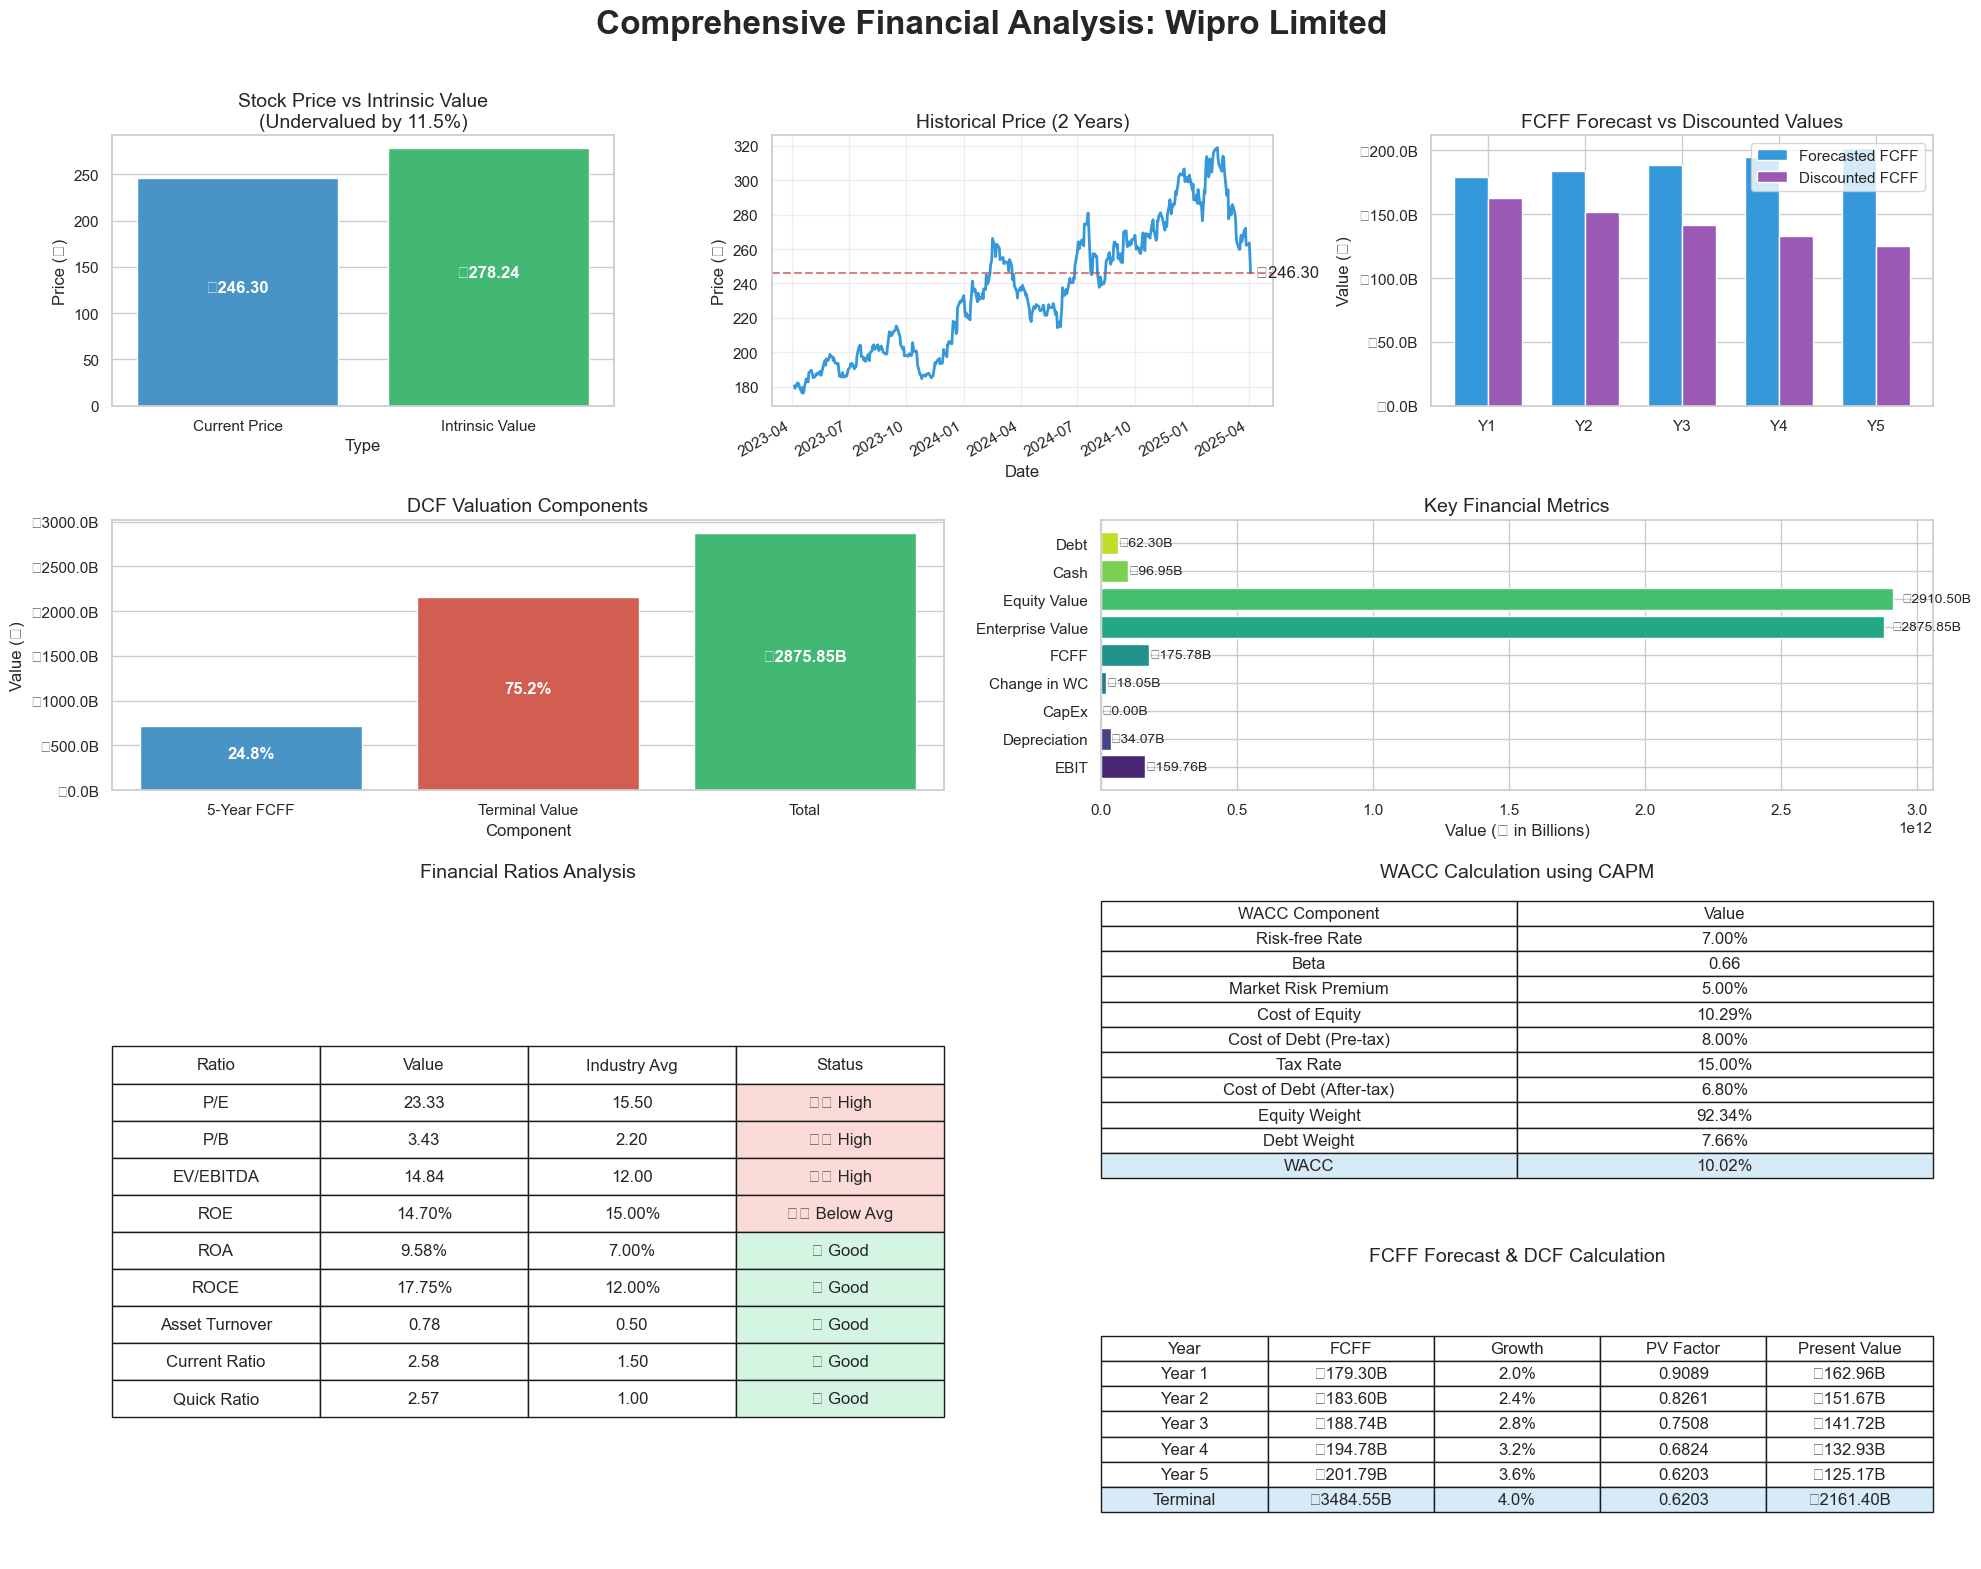


Summary for Wipro Ltd:
Current Market Price: ₹246.30
Intrinsic Value per Share: ₹278.24
WACC: 10.02%
Terminal Growth Rate: 4.00%
Stock is UNDERVALUED with 13.0% potential upside


In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from tabulate import tabulate

def list_keys(df, label):
    print(f"\nAvailable keys in {label}:")
    for key in df.index:
        print("-", key)

def safe_get(statement, key, label=None):
    """Get a numeric value from a financial statement safely."""
    try:
        if key in statement.index:
            val = statement.loc[key]
        elif label:
            list_keys(statement, label)
            raise KeyError(f"'{key}' not found in {label}")
        else:
            raise KeyError(f"'{key}' not found")
        
        if isinstance(val, (float, int)):
            return float(val)
        elif hasattr(val, "first_valid_index") and val.first_valid_index() is not None:
            return float(val[val.first_valid_index()])
        return 0.0
    except Exception as e:
        print(f"[Error] {key}: {e}")
        return 0.0

def format_currency(val):
    return f"₹{val:,.0f}"

def calculate_wacc(stock, risk_free_rate=0.07):
    """
    Calculate Weighted Average Cost of Capital using CAPM for cost of equity
    
    Parameters:
    - stock: yfinance Ticker object
    - risk_free_rate: 10yr govt bond yield (default: 7% for India)
    
    Returns:
    - wacc: Weighted Average Cost of Capital
    - components: Dictionary with components of WACC calculation
    """
    try:
        info = stock.info
        bs = stock.balance_sheet
        is_ = stock.financials
        
        # Get market data
        market_risk_premium = 0.05  # India market risk premium typically 5-6%
        
        # Get Beta
        beta = info.get('beta', 1.0)
        if beta is None or beta == 0:
            beta = 1.0
        
        # Calculate Cost of Equity using CAPM
        cost_of_equity = risk_free_rate + (beta * market_risk_premium)
        
        # Get debt information
        total_debt = safe_get(bs, "Long Term Debt", "Balance Sheet") + safe_get(bs, "Short Long Term Debt", "Balance Sheet")
        interest_expense = safe_get(is_, "Interest Expense", "Income Statement")
        
        # Calculate Cost of Debt
        cost_of_debt = 0.08  # Default value
        if total_debt > 0:
            implied_rate = abs(interest_expense / total_debt) if interest_expense != 0 else 0.08
            cost_of_debt = implied_rate if 0.04 <= implied_rate <= 0.15 else 0.08
        
        # Get tax rate
        tax_expense = safe_get(is_, "Income Tax Expense", "Income Statement")
        ebt = safe_get(is_, "EBT", "Income Statement") or safe_get(is_, "Pretax Income", "Income Statement")
        tax_rate = min(max(tax_expense / ebt if ebt else 0.25, 0.15), 0.35)  # Constrain between 15-35%
        
        # Calculate after-tax cost of debt
        after_tax_cost_of_debt = cost_of_debt * (1 - tax_rate)
        
        # Calculate weights
        total_equity = safe_get(bs, "Total Equity Gross Minority Interest", "Balance Sheet") or safe_get(bs, "Total Stockholder Equity", "Balance Sheet")
        enterprise_value = total_equity + total_debt
        
        equity_weight = total_equity / enterprise_value if enterprise_value > 0 else 0.7
        debt_weight = total_debt / enterprise_value if enterprise_value > 0 else 0.3
        
        # Ensure weights sum to 1
        if equity_weight + debt_weight != 1:
            total = equity_weight + debt_weight
            equity_weight = equity_weight / total if total > 0 else 0.7
            debt_weight = debt_weight / total if total > 0 else 0.3
        
        # Calculate WACC
        wacc = (equity_weight * cost_of_equity) + (debt_weight * after_tax_cost_of_debt)
        
        # Ensure WACC is reasonable (between 6% and 20%)
        wacc = min(max(wacc, 0.06), 0.20)
        
        components = {
            'risk_free_rate': risk_free_rate,
            'beta': beta,
            'market_risk_premium': market_risk_premium,
            'cost_of_equity': cost_of_equity,
            'cost_of_debt': cost_of_debt,
            'tax_rate': tax_rate,
            'after_tax_cost_of_debt': after_tax_cost_of_debt,
            'equity_weight': equity_weight,
            'debt_weight': debt_weight
        }
        
        return wacc, components
        
    except Exception as e:
        print(f"Error calculating WACC: {e}")
        return 0.10, {}  # Default fallback

def analyze_stock(ticker_symbol, forecast_years=5):
    # Fetch data
    stock = yf.Ticker(ticker_symbol)
    
    # Fetch financials
    is_ = stock.financials
    bs = stock.balance_sheet
    cf = stock.cashflow
    info = stock.info
    hist = stock.history(period="2y")
    
    # Prices & Shares
    current_price = info.get("currentPrice", 0.0)
    shares_outstanding = info.get("sharesOutstanding", 1)
    company_name = info.get("longName", ticker_symbol)
    
    # Calculate WACC using CAPM
    discount_rate, wacc_components = calculate_wacc(stock)
    print(f"\nCalculated WACC: {discount_rate*100:.2f}%")
    
    # Income Statement
    ebit = safe_get(is_, "EBIT", "Income Statement")
    dep = safe_get(cf, "Depreciation", "Cash Flow")
    capex = -safe_get(cf, "Capital Expenditures", "Cash Flow")
    change_wc = safe_get(cf, "Change In Working Capital", "Cash Flow")
    tax_expense = safe_get(is_, "Income Tax Expense", "Income Statement")
    ebt = safe_get(is_, "EBT", "Income Statement") or safe_get(is_, "Pretax Income", "Income Statement")
    net_income = safe_get(is_, "Net Income", "Income Statement")
    revenue = safe_get(is_, "Total Revenue", "Income Statement")
    
    # Balance Sheet
    total_equity = safe_get(bs, "Total Equity Gross Minority Interest", "Balance Sheet")
    total_assets = safe_get(bs, "Total Assets", "Balance Sheet")
    current_assets = safe_get(bs, "Current Assets", "Balance Sheet")
    current_liabilities = safe_get(bs, "Current Liabilities", "Balance Sheet")
    inventory = safe_get(bs, "Inventory", "Balance Sheet")
    cash = safe_get(bs, "Cash And Cash Equivalents", "Balance Sheet")
    debt = safe_get(bs, "Long Term Debt", "Balance Sheet")
    
    # Tax rate
    tax_rate = tax_expense / ebt if ebt else 0.25
    
    # FCFF
    fcff = ebit * (1 - tax_rate) + dep - capex - change_wc
    
    # DCF Model parameters from WACC calculation
    terminal_growth = min(0.04, discount_rate * 0.4)  # Terminal growth should be less than discount rate
    
    # Generate forecast for next 5 years
    forecast_data = []
    fcff_forecast = []
    dcf_values = []
    cumulative_pv = 0
    
    # Calculate historical growth rate for more realistic projections
    revenue_growth_rate = 0.06  # Default growth rate
    try:
        if len(is_.columns) >= 2:
            latest_revenue = safe_get(is_.iloc[:, 0], "Total Revenue")
            prev_revenue = safe_get(is_.iloc[:, 1], "Total Revenue")
            if latest_revenue > 0 and prev_revenue > 0:
                yearly_growth = (latest_revenue / prev_revenue) - 1
                revenue_growth_rate = min(max(yearly_growth, 0.02), 0.15)  # Constrain between 2-15%
    except:
        pass
    
    # Project future cash flows with realistic growth rates
    growth_rates = []
    for year in range(1, forecast_years + 1):
        # Implement a declining growth rate model
        year_factor = (forecast_years - year + 1) / forecast_years
        growth_rate = terminal_growth + (revenue_growth_rate - terminal_growth) * year_factor
        growth_rates.append(growth_rate)
        
        fcff_next = fcff * (1 + growth_rate) if year == 1 else fcff_forecast[-1] * (1 + growth_rate)
        fcff_forecast.append(fcff_next)
        
        # Calculate present value
        pv_factor = 1 / ((1 + discount_rate) ** year)
        pv = fcff_next * pv_factor
        dcf_values.append(pv)
        cumulative_pv += pv
        
        forecast_data.append({
            'Year': f'Year {year}',
            'FCFF': fcff_next,
            'Growth': f'{growth_rate*100:.1f}%',
            'PV Factor': f'{pv_factor:.4f}',
            'Present Value': pv
        })
    
    # Calculate terminal value
    terminal_fcff = fcff_forecast[-1] * (1 + terminal_growth)
    terminal_value = terminal_fcff / (discount_rate - terminal_growth)
    terminal_value_pv = terminal_value / ((1 + discount_rate) ** forecast_years)
    
    # Enterprise and Equity value
    enterprise_value = cumulative_pv + terminal_value_pv
    equity_value = enterprise_value + cash - debt
    intrinsic_value_per_share = equity_value / shares_outstanding if shares_outstanding else 0.0
    
    # Ratios
    eps = net_income / shares_outstanding if shares_outstanding else 0.0
    bvps = total_equity / shares_outstanding if shares_outstanding else 0.0
    pe_ratio = current_price / eps if eps else 0.0
    pb_ratio = current_price / bvps if bvps else 0.0
    ebitda = ebit + dep
    ev_ebitda = enterprise_value / ebitda if ebitda else 0.0
    roe = net_income / total_equity if total_equity else 0.0
    roa = net_income / total_assets if total_assets else 0.0
    asset_turnover = revenue / total_assets if total_assets else 0.0
    current_ratio = current_assets / current_liabilities if current_liabilities else 0.0
    quick_ratio = (current_assets - inventory) / current_liabilities if current_liabilities else 0.0
    capital_employed = total_assets - current_liabilities if total_assets > current_liabilities else 1.0
    roce = ebit / capital_employed if capital_employed else 0.0
    
    # Prepare visualization
    visualize_analysis(
        company_name,
        current_price,
        intrinsic_value_per_share,
        forecast_data,
        fcff,
        fcff_forecast,
        dcf_values,
        terminal_value,
        terminal_value_pv,
        hist,
        {
            'P/E': pe_ratio,
            'P/B': pb_ratio,
            'EV/EBITDA': ev_ebitda,
            'ROE': roe * 100,
            'ROA': roa * 100,
            'ROCE': roce * 100,
            'Asset Turnover': asset_turnover,
            'Current Ratio': current_ratio,
            'Quick Ratio': quick_ratio
        },
        {
            'EBIT': ebit,
            'Depreciation': dep,
            'CapEx': capex,
            'Change in WC': change_wc,
            'FCFF': fcff,
            'Enterprise Value': enterprise_value,
            'Equity Value': equity_value,
            'Cash': cash,
            'Debt': debt
        },
        wacc_components
    )
    
    return {
        'current_price': current_price,
        'intrinsic_value': intrinsic_value_per_share,
        'enterprise_value': enterprise_value,
        'equity_value': equity_value,
        'wacc': discount_rate,
        'terminal_growth': terminal_growth
    }

def visualize_analysis(company_name, current_price, intrinsic_value, forecast_data, 
                       current_fcff, fcff_forecast, dcf_values, terminal_value,
                       terminal_value_pv, hist_data, ratios, key_financials, wacc_components):
    """Create comprehensive visualizations for the stock analysis"""
    # Set style
    sns.set(style="whitegrid")
    plt.rcParams['figure.figsize'] = (20, 16)
    plt.rcParams['font.family'] = 'sans-serif'
    
    # Create figure with grid
    fig = plt.figure(constrained_layout=True)
    gs = GridSpec(4, 6, figure=fig)
    
    # Title for the entire analysis
    fig.suptitle(f"Comprehensive Financial Analysis: {company_name}", fontsize=24, fontweight='bold', y=0.98)
    
    # 1. Stock Price vs Intrinsic Value (Top left)
    ax1 = fig.add_subplot(gs[0, 0:2])
    comparison = pd.DataFrame({
        'Value': [current_price, intrinsic_value],
        'Type': ['Current Price', 'Intrinsic Value']
    })
    
    colors = ['#3498db', '#e74c3c'] if current_price > intrinsic_value else ['#3498db', '#2ecc71']
    sns.barplot(x='Type', y='Value', data=comparison, palette=colors, ax=ax1)
    for i, v in enumerate(comparison['Value']):
        ax1.text(i, v/2, f"₹{v:.2f}", ha='center', fontsize=12, color='white', fontweight='bold')
    
    overunder = "Overvalued" if current_price > intrinsic_value else "Undervalued"
    diff_pct = abs(current_price - intrinsic_value) / intrinsic_value * 100
    ax1.set_title(f"Stock Price vs Intrinsic Value\n({overunder} by {diff_pct:.1f}%)", fontsize=14)
    ax1.set_ylabel("Price (₹)", fontsize=12)
    
    # 2. Historical Price Chart (Top center)
    ax2 = fig.add_subplot(gs[0, 2:4])
    hist_data['Close'].plot(ax=ax2, linewidth=2, color='#3498db')
    ax2.axhline(y=current_price, color='r', linestyle='--', alpha=0.7)
    ax2.text(hist_data.index[-1], current_price, f" ₹{current_price:.2f}", va='center')
    ax2.set_title(f"Historical Price (2 Years)", fontsize=14)
    ax2.set_ylabel("Price (₹)", fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # 3. FCFF vs Discounted FCFF (Top right)
    ax3 = fig.add_subplot(gs[0, 4:6])
    years = [f'Y{i+1}' for i in range(len(fcff_forecast))]
    fcff_df = pd.DataFrame({
        'Year': years,
        'Forecasted FCFF': fcff_forecast,
        'Discounted FCFF': dcf_values
    })
    
    width = 0.35
    x = np.arange(len(years))
    ax3.bar(x - width/2, fcff_df['Forecasted FCFF'], width, label='Forecasted FCFF', color='#3498db')
    ax3.bar(x + width/2, fcff_df['Discounted FCFF'], width, label='Discounted FCFF', color='#9b59b6')
    ax3.set_xticks(x)
    ax3.set_xticklabels(years)
    ax3.set_title("FCFF Forecast vs Discounted Values", fontsize=14)
    ax3.set_ylabel("Value (₹)", fontsize=12)
    ax3.legend()
    
    # Format y-axis for large numbers
    def billions_formatter(x, pos):
        return f'₹{x/1e9:.1f}B'
    
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(billions_formatter))
    
    # 4. DCF Breakdown (Middle left)
    ax4 = fig.add_subplot(gs[1, 0:3])
    dcf_components = pd.DataFrame({
        'Component': ['5-Year FCFF', 'Terminal Value', 'Total'],
        'Value': [sum(dcf_values), terminal_value_pv, sum(dcf_values) + terminal_value_pv],
        'Percentage': [sum(dcf_values)/(sum(dcf_values) + terminal_value_pv)*100, 
                      terminal_value_pv/(sum(dcf_values) + terminal_value_pv)*100, 100]
    })
    
    sns.barplot(x='Component', y='Value', data=dcf_components, palette=['#3498db', '#e74c3c', '#2ecc71'], ax=ax4)
    
    # Add percentage labels
    for i, v in enumerate(dcf_components['Value']):
        if i < 2:  # Only for the first two bars
            percentage = dcf_components['Percentage'][i]
            ax4.text(i, v/2, f"{percentage:.1f}%", ha='center', fontsize=12, color='white', fontweight='bold')
        else:
            ax4.text(i, v/2, f"₹{v/1e9:.2f}B", ha='center', fontsize=12, color='white', fontweight='bold')
    
    ax4.set_title("DCF Valuation Components", fontsize=14)
    ax4.set_ylabel("Value (₹)", fontsize=12)
    ax4.yaxis.set_major_formatter(plt.FuncFormatter(billions_formatter))
    
    # 5. Key Financial Metrics (Middle right)
    ax5 = fig.add_subplot(gs[1, 3:6])
    metrics = pd.DataFrame({
        'Metric': list(key_financials.keys()),
        'Value': list(key_financials.values())
    })
    
    colors = sns.color_palette("viridis", len(metrics))
    bars = ax5.barh(metrics['Metric'], metrics['Value'], color=colors)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax5.text(width*1.01, bar.get_y() + bar.get_height()/2, 
                f'₹{width/1e9:.2f}B', va='center', fontsize=10)
    
    ax5.set_title("Key Financial Metrics", fontsize=14)
    ax5.set_xlabel("Value (₹ in Billions)", fontsize=12)
    
    # 6. Financial Ratios Table (Bottom left)
    ax6 = fig.add_subplot(gs[2:, 0:3])
    ax6.axis('tight')
    ax6.axis('off')
    
    # Prepare ratios data with industry averages (example)
    ratio_table = []
    industry_avg = {
        'P/E': 15.5, 'P/B': 2.2, 'EV/EBITDA': 12.0, 'ROE': 15.0, 
        'ROA': 7.0, 'ROCE': 12.0, 'Asset Turnover': 0.5, 
        'Current Ratio': 1.5, 'Quick Ratio': 1.0
    }
    
    for key, value in ratios.items():
        status = ""
        if key in ['ROE', 'ROA', 'ROCE', 'Asset Turnover', 'Current Ratio', 'Quick Ratio']:
            status = "✅ Good" if value > industry_avg[key] else "⚠️ Below Avg"
        else:
            if key in ['P/E', 'P/B', 'EV/EBITDA']:
                status = "✅ Good" if value < industry_avg[key] else "⚠️ High"
        
        if key in ['ROE', 'ROA', 'ROCE']:
            value_str = f"{value:.2f}%"
            benchmark = f"{industry_avg[key]:.2f}%"
        else:
            value_str = f"{value:.2f}"
            benchmark = f"{industry_avg[key]:.2f}"
            
        ratio_table.append([key, value_str, benchmark, status])
    
    table = ax6.table(cellText=ratio_table, 
                     colLabels=['Ratio', 'Value', 'Industry Avg', 'Status'],
                     cellLoc='center', 
                     loc='center',
                     colWidths=[0.25, 0.25, 0.25, 0.25])
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Color code the table cells
    for i, key in enumerate(ratios.keys()):
        if "Good" in ratio_table[i][3]:
            table[(i+1, 3)].set_facecolor('#d5f5e3')  # Light green
        elif "Below" in ratio_table[i][3] or "High" in ratio_table[i][3]:
            table[(i+1, 3)].set_facecolor('#fadbd8')  # Light red
    
    ax6.set_title("Financial Ratios Analysis", fontsize=14, pad=20)
    
    # 7. WACC Table (Middle Bottom)
    ax7 = fig.add_subplot(gs[2, 3:6])
    ax7.axis('tight')
    ax7.axis('off')
    
    # Format WACC components for table
    wacc_data = [
        ["Risk-free Rate", f"{wacc_components['risk_free_rate']*100:.2f}%"],
        ["Beta", f"{wacc_components['beta']:.2f}"],
        ["Market Risk Premium", f"{wacc_components['market_risk_premium']*100:.2f}%"],
        ["Cost of Equity", f"{wacc_components['cost_of_equity']*100:.2f}%"],
        ["Cost of Debt (Pre-tax)", f"{wacc_components['cost_of_debt']*100:.2f}%"],
        ["Tax Rate", f"{wacc_components['tax_rate']*100:.2f}%"],
        ["Cost of Debt (After-tax)", f"{wacc_components['after_tax_cost_of_debt']*100:.2f}%"],
        ["Equity Weight", f"{wacc_components['equity_weight']*100:.2f}%"],
        ["Debt Weight", f"{wacc_components['debt_weight']*100:.2f}%"],
        ["WACC", f"{(wacc_components['equity_weight']*wacc_components['cost_of_equity'] + wacc_components['debt_weight']*wacc_components['after_tax_cost_of_debt'])*100:.2f}%"]
    ]
    
    wacc_table = ax7.table(cellText=wacc_data,
                        colLabels=["WACC Component", "Value"],
                        cellLoc='center',
                        loc='center',
                        colWidths=[0.5, 0.5])
    
    wacc_table.auto_set_font_size(False)
    wacc_table.set_fontsize(12)
    wacc_table.scale(1, 1.5)
    
    # Highlight the WACC row
    wacc_table[(len(wacc_data), 0)].set_facecolor('#d6eaf8')
    wacc_table[(len(wacc_data), 1)].set_facecolor('#d6eaf8')
    
    ax7.set_title("WACC Calculation using CAPM", fontsize=14, pad=20)
    
    # 8. FCFF Forecast Detail Table (Bottom right)
    ax8 = fig.add_subplot(gs[3, 3:6])
    ax8.axis('tight')
    ax8.axis('off')
    
    forecast_table = []
    for item in forecast_data:
        forecast_table.append([
            item['Year'], 
            f"₹{item['FCFF']/1e9:.2f}B", 
            item['Growth'], 
            item['PV Factor'], 
            f"₹{item['Present Value']/1e9:.2f}B"
        ])
    
    # Add terminal value as the last row
    forecast_table.append([
        "Terminal", 
        f"₹{terminal_value/1e9:.2f}B", 
        f"{terminal_growth*100:.1f}%", 
        f"{1/((1+wacc_components['equity_weight']*wacc_components['cost_of_equity'] + wacc_components['debt_weight']*wacc_components['after_tax_cost_of_debt'])**len(fcff_forecast)):.4f}", 
        f"₹{terminal_value_pv/1e9:.2f}B"
    ])
    
    fcff_table = ax8.table(cellText=forecast_table, 
                     colLabels=['Year', 'FCFF', 'Growth', 'PV Factor', 'Present Value'],
                     cellLoc='center', 
                     loc='center')
    
    fcff_table.auto_set_font_size(False)
    fcff_table.set_fontsize(12)
    fcff_table.scale(1, 1.5)
    
    # Highlight terminal value row
    for j in range(5):
        fcff_table[(len(forecast_table), j)].set_facecolor('#d6eaf8')  # Light blue
    
    ax8.set_title("FCFF Forecast & DCF Calculation", fontsize=14, pad=20)
    
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Run the analysis for Wipro
results = analyze_stock("WIPRO.NS")

# Print summary
print(f"\nSummary for Wipro Ltd:")
print(f"Current Market Price: ₹{results['current_price']:.2f}")
print(f"Intrinsic Value per Share: ₹{results['intrinsic_value']:.2f}")
print(f"WACC: {results['wacc']*100:.2f}%")
print(f"Terminal Growth Rate: {results['terminal_growth']*100:.2f}%")

if results['current_price'] > results['intrinsic_value']:
    discount = (results['current_price'] - results['intrinsic_value']) / results['intrinsic_value'] * 100
    print(f"Stock is OVERVALUED by {discount:.1f}%")
else:
    upside = (results['intrinsic_value'] - results['current_price']) / results['current_price'] * 100
    print(f"Stock is UNDERVALUED with {upside:.1f}% potential upside")

Successfully fetched data for: Wipro Limited
Currency: INR
Current Market Price: ₹246
Shares Outstanding: 10,460,300,288
Market Cap: ₹257,686.45 Cr
Beta: 0.66

--- Calculating WACC ---
Cost of Equity (Ke): 10.72%
Cost of Debt (After-tax): 6.00%
Equity Weight: 97.64%, Debt Weight: 2.36%
Calculated WACC: 10.61%
--------------------------


--- Calculating Latest FCFF ---


### FCFF Calculation Components (Latest Year)

Metric,Formatted Value
EBIT,"₹15,976.20 Cr"
Tax Rate,25.00%
NOPAT,"₹11,982.15 Cr"
Depreciation & Amortization,"₹3,407.10 Cr"
Capital Expenditures (-),"₹-1,051.00 Cr"
Change in Working Capital (-),"₹-1,805.10 Cr"
FCFF (Calculated),"₹12,533.15 Cr"


----------------------------


--- Projecting Future FCFF & Calculating Terminal Value ---
Using initial growth rate based on recent revenue trend: 6.80%
Using Terminal Growth Rate (g): 4.00%
Cumulative PV of Forecasted FCFFs: ₹55,365.67 Cr
Terminal Value (at Year 5): ₹259,995.88 Cr
Present Value of Terminal Value: ₹157,051.31 Cr
-----------------------------------------------------


--- Calculating Enterprise & Equity Value ---
Enterprise Value (EV): ₹212,416.97 Cr
  - Total Debt: ₹16,464.90 Cr
  + Cash & Equivalents: ₹9,695.30 Cr
Equity Value: ₹205,647.37 Cr
Shares Outstanding: 10,460,300,288
Intrinsic Value per Share: ₹197
-------------------------------------------


--- Calculating Financial Ratios ---
----------------------------------



## Financial Analysis Visualization: Wipro Limited

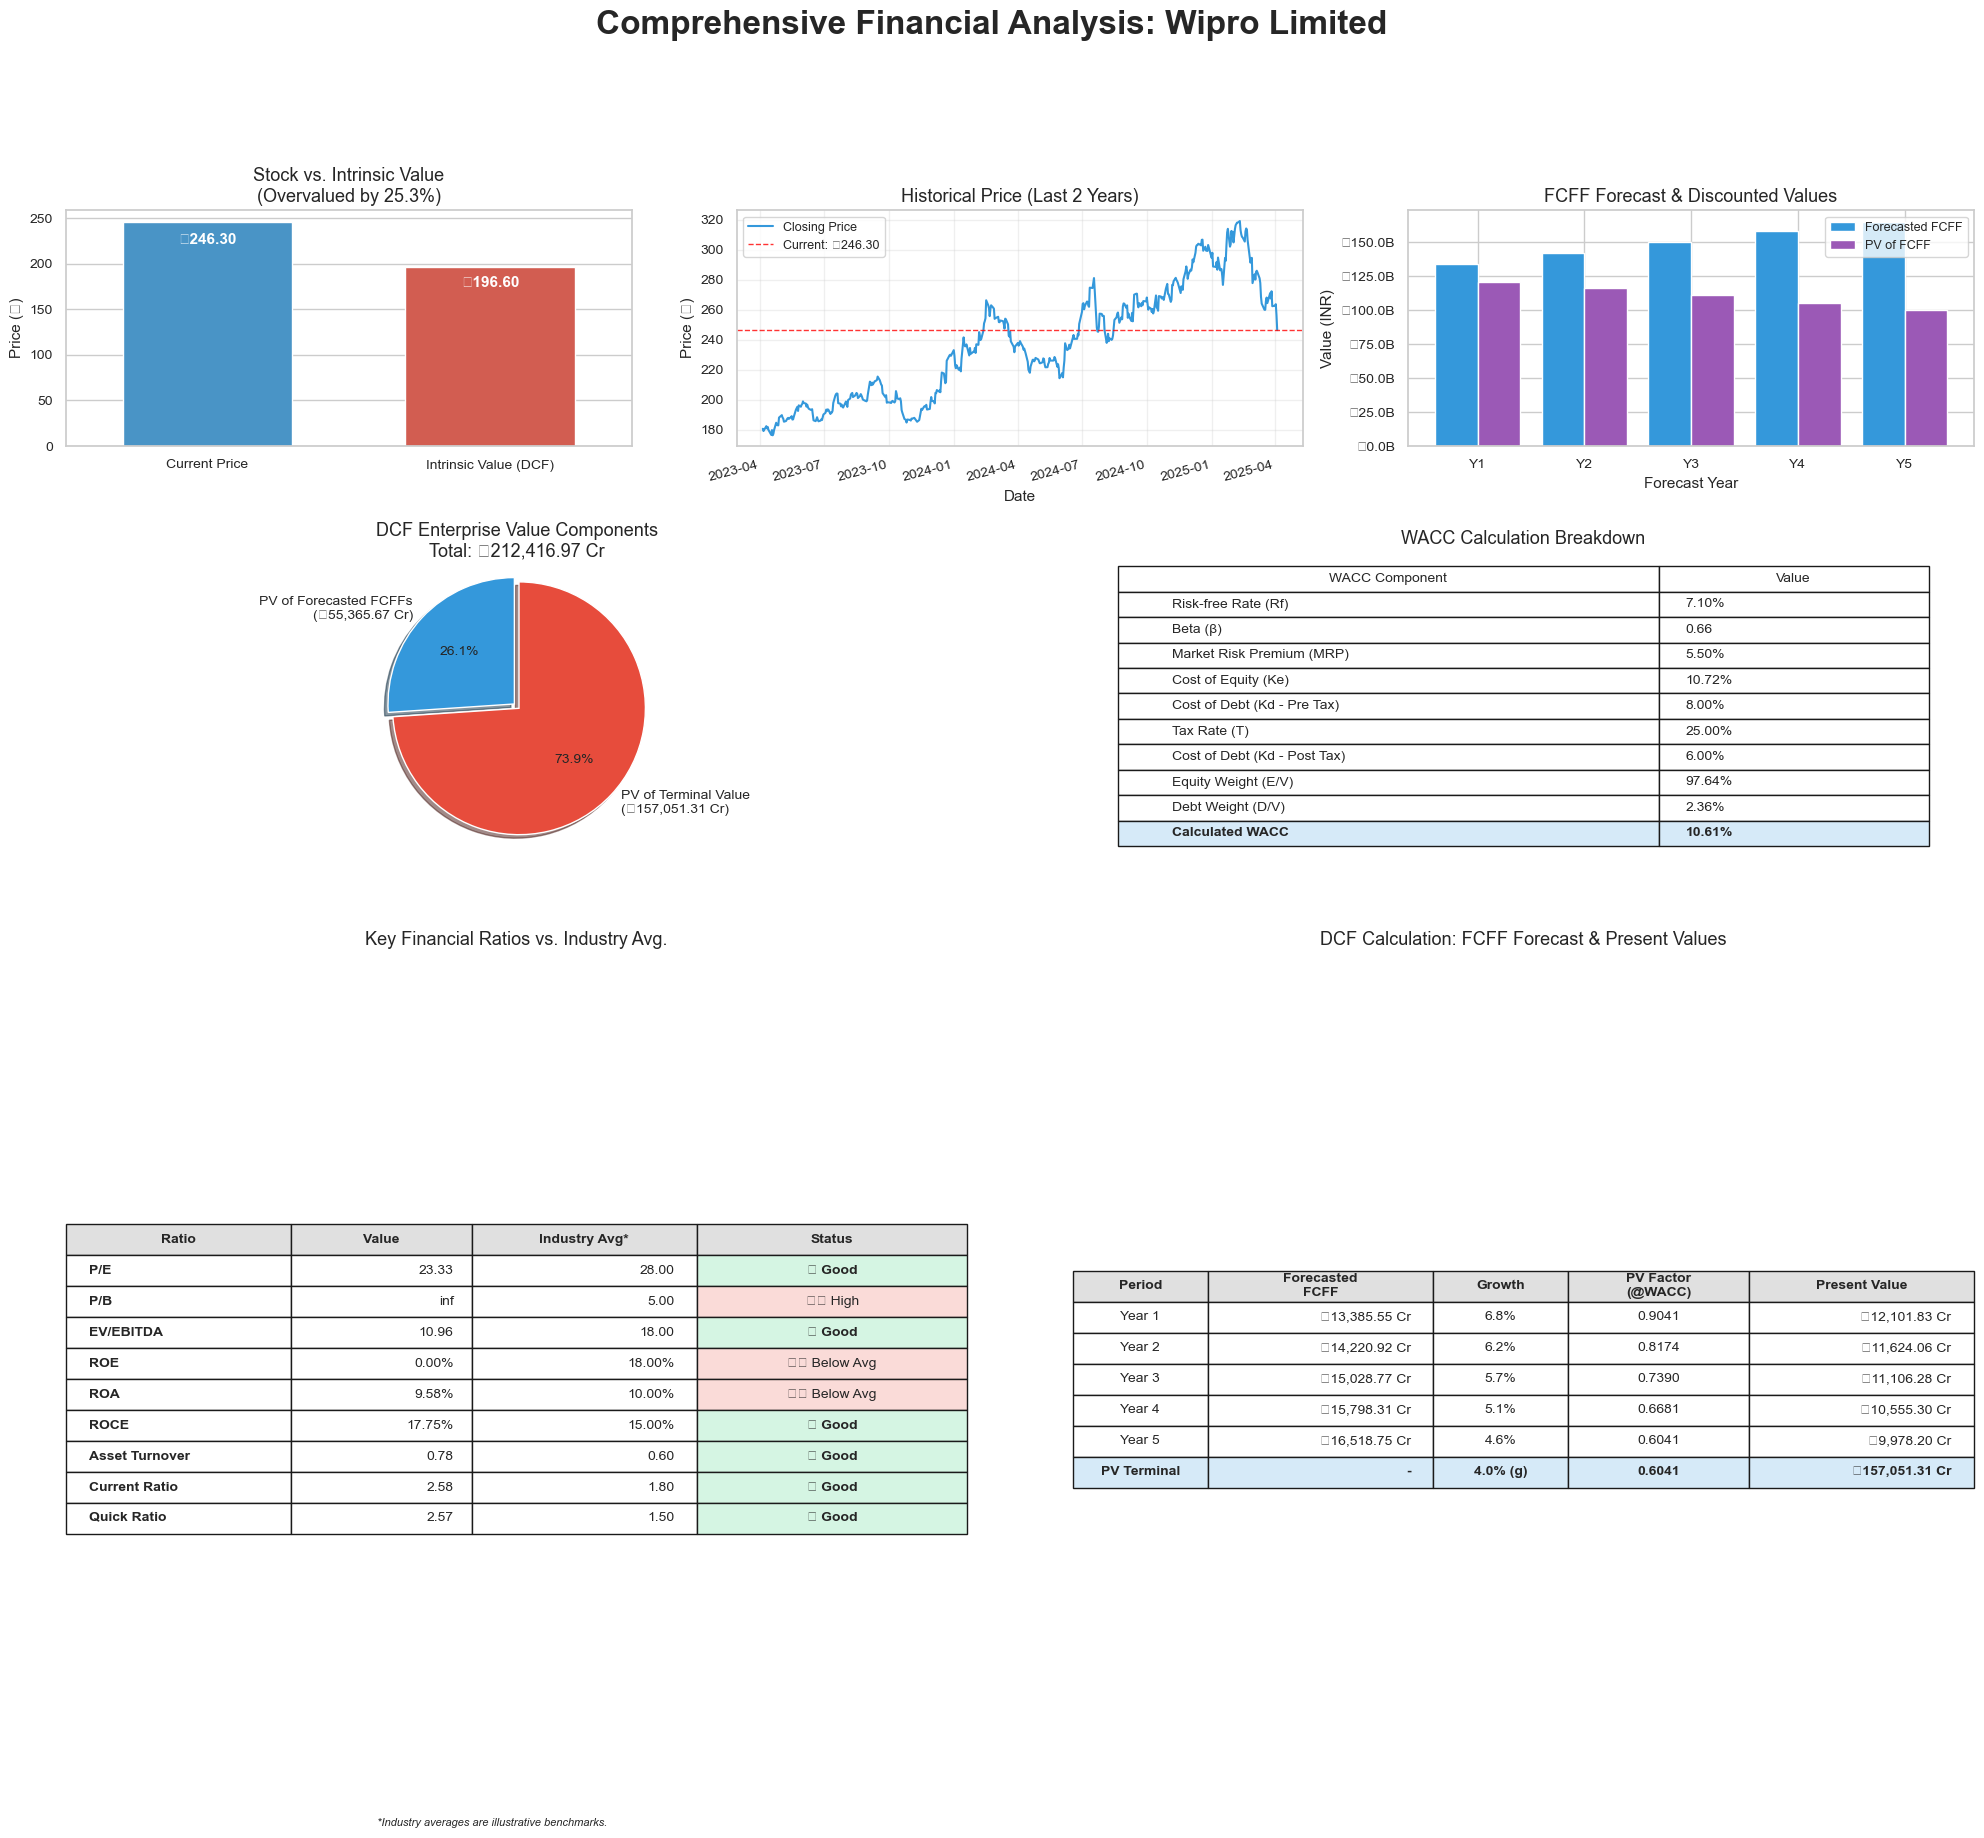

Based on this DCF model, Wipro Limited appears to be **OVERVALUED** by approximately **25.3%**.

In [5]:
# -*- coding: utf-8 -*-
# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: light
#       format_version: '1.5'
#       jupytext_version: 1.14.5
#   kernelspec:
#     display_name: Python 3 (ipykernel)
#     language: python
#     name: python3
# ---

# %% [markdown]
# # Wipro Limited (WIPRO.NS) - Financial Analysis & DCF Valuation
# **SEBI Research Analyst Report Simulation**
#
# **Date:** October 26, 2023 (Data fetched dynamically)
#
# **Analyst:** Simulated AI Research Analyst
#
# **Objective:** To perform a comprehensive financial analysis and estimate the intrinsic value per share of Wipro Limited using the Discounted Cash Flow (DCF) methodology, incorporating the Weighted Average Cost of Capital (WACC) and dynamically fetched financial data.
#
# **Methodology:**
# 1.  **Data Acquisition:** Utilize the `yfinance` library to fetch the latest financial statements (Income Statement, Balance Sheet, Cash Flow), company information (beta, shares outstanding), and historical market data for WIPRO.NS.
# 2.  **WACC Calculation:** Determine the appropriate discount rate (WACC) using the Capital Asset Pricing Model (CAPM) for the cost of equity and estimating the cost of debt based on financial data.
# 3.  **Free Cash Flow to Firm (FCFF):** Calculate the historical FCFF based on the latest available financial data.
# 4.  **FCFF Projection:** Forecast FCFF for the next 5 years using a declining growth rate model, starting from a calculated recent growth trend and converging towards a sustainable terminal growth rate.
# 5.  **Terminal Value (TV):** Estimate the value of the company beyond the explicit forecast period using the Gordon Growth Model (Perpetuity Growth Method).
# 6.  **Discounting:** Discount the projected FCFFs and Terminal Value back to their present values using the calculated WACC.
# 7.  **Valuation:** Calculate Enterprise Value and Equity Value, leading to the Intrinsic Value per Share.
# 8.  **Analysis & Visualization:** Compare the Intrinsic Value with the Current Market Price, analyze key financial ratios against illustrative industry benchmarks, and present findings through structured tables and visualizations.

# %% [markdown]
# ## 1. Setup and Libraries

# %%
# Standard Libraries
import warnings
import numpy as np
import pandas as pd

# Data Fetching
import yfinance as yf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter # For custom number formatting

# Display Utilities
from tabulate import tabulate
from IPython.display import display, Markdown, HTML

# Settings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning) # Ignore yfinance timezone warnings if they pop up
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Format pandas floats
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (20, 18) # Larger default figure size for report
plt.rcParams['font.family'] = 'sans-serif'

# %% [markdown]
# ## 2. Configuration and Helper Functions

# %%
# --- Configuration ---
TICKER_SYMBOL = "WIPRO.NS"  # Wipro Ltd. on NSE
FORECAST_YEARS = 5         # Explicit forecast period
RISK_FREE_RATE = 0.071     # Approximate Indian 10-Year Government Bond Yield (as of late 2023, check current rates)
MARKET_RISK_PREMIUM = 0.055 # Estimated Equity Market Risk Premium for India
TERMINAL_GROWTH_RATE_CAP = 0.04 # Cap for perpetual growth rate (Sustainable long-term growth)

# Illustrative Industry Benchmarks (replace with actual peer data if available)
INDUSTRY_BENCHMARKS = {
    'P/E': 28.0, 'P/B': 5.0, 'EV/EBITDA': 18.0, 'ROE': 18.0,
    'ROA': 10.0, 'ROCE': 15.0, 'Asset Turnover': 0.6,
    'Current Ratio': 1.8, 'Quick Ratio': 1.5
}


# --- Helper Functions ---

def print_keys(statement, name):
    """Prints available keys in a yfinance statement for debugging"""
    print(f"\n--- Available Keys in {name} ---")
    if isinstance(statement, pd.DataFrame):
        print(", ".join(statement.index.astype(str)))
    elif isinstance(statement, dict):
        print(", ".join(statement.keys()))
    print("------------------------------------\n")


def safe_get(data, key, statement_name="Statement"):
    """
    Safely retrieves a numeric value from yfinance data (Series or Dict).
    Handles potential KeyError, TypeError, and uses the most recent value if it's a Series.
    Returns 0.0 if the key is not found or data is invalid.
    """
    value = 0.0
    source = None

    if isinstance(data, pd.Series):
        source = "Series"
        if key in data.index:
            try:
                # Attempt to get the first valid value (usually the most recent year)
                val = data.loc[key]
                if isinstance(val, pd.Series) and not val.empty:
                   # If it returned another series, get the first item if possible
                   value = float(val.iloc[0]) if pd.notna(val.iloc[0]) else 0.0
                elif pd.notna(val):
                    value = float(val)
                else:
                   value = 0.0 # Handle cases where the value itself is NaN
            except (KeyError, TypeError, IndexError, ValueError):
                 value = 0.0 # Reset on error during extraction
        # else: print(f"[safe_get Debug] Key '{key}' not found in Series index.") # Optional debug

    elif isinstance(data, dict):
        source = "Dict"
        raw_val = data.get(key) # Use .get for safety
        if raw_val is not None:
            try:
                value = float(raw_val)
            except (TypeError, ValueError):
                value = 0.0 # Handle non-numeric types
        # else: print(f"[safe_get Debug] Key '{key}' not found in Dict.") # Optional debug

    if value is None or not np.isfinite(value): # Check for None, NaN, Inf
      # print(f"[safe_get Warning] Key '{key}' in {statement_name} ({source}) resulted in invalid value. Using 0.0.") # Optional warning
      value = 0.0

    return value

def format_currency(value, currency="₹"):
    """Formats a number as Indian Rupees currency string."""
    if pd.isna(value) or not isinstance(value, (int, float)):
        return f"{currency} N/A"
    if abs(value) >= 1e7: # Crores
        return f"{currency}{value / 1e7:,.2f} Cr"
    elif abs(value) >= 1e5: # Lakhs
        return f"{currency}{value / 1e5:,.2f} L"
    else:
        return f"{currency}{value:,.0f}"

def format_large_number(value):
    """Formats large numbers with appropriate suffixes (Billion, Million)."""
    if pd.isna(value) or not isinstance(value, (int, float)):
        return "N/A"
    if abs(value) >= 1e9:
        return f"{value / 1e9:.2f}B"
    elif abs(value) >= 1e6:
        return f"{value / 1e6:.2f}M"
    elif abs(value) >= 1e3:
         return f"{value / 1e3:.1f}K"
    else:
        return f"{value:.1f}"

def billions_formatter(x, pos):
    """Matplotlib formatter function for billions."""
    return f'₹{x/1e9:.1f}B'


# %% [markdown]
# ## 3. Data Acquisition (WIPRO.NS)

# %%
try:
    stock = yf.Ticker(TICKER_SYMBOL)

    # Fetch core financial data
    info = stock.info
    financials = stock.financials # Income Statement (Annual)
    balance_sheet = stock.balance_sheet # Balance Sheet (Annual)
    cashflow = stock.cashflow # Cash Flow Statement (Annual)
    hist = stock.history(period="2y") # 2 years of historical price data

    # --- Key Info Extraction ---
    company_name = info.get("longName", TICKER_SYMBOL)
    currency = info.get("currency", "INR") # Default to INR if not found
    current_price = info.get("currentPrice") or info.get("previousClose") or hist['Close'].iloc[-1] # Multiple fallbacks
    shares_outstanding = info.get("sharesOutstanding", 0)
    beta = info.get('beta', 1.0) # Use 1.0 if beta is missing
    market_cap = info.get('marketCap', 0)

    if shares_outstanding == 0 or current_price == 0:
        raise ValueError("Crucial data (Shares Outstanding or Price) is missing from yfinance info.")

    print(f"Successfully fetched data for: {company_name}")
    print(f"Currency: {currency}")
    print(f"Current Market Price: {format_currency(current_price)}")
    print(f"Shares Outstanding: {shares_outstanding:,.0f}")
    print(f"Market Cap: {format_currency(market_cap)}")
    print(f"Beta: {beta:.2f}")

    # Optionally print keys if debugging needed
    # print_keys(financials, "Income Statement")
    # print_keys(balance_sheet, "Balance Sheet")
    # print_keys(cashflow, "Cash Flow Statement")

except Exception as e:
    print(f"ERROR: Failed to fetch or process data for {TICKER_SYMBOL}. Error: {e}")
    # Exit or handle gracefully if essential data is missing
    raise SystemExit("Cannot proceed without stock data.")


# %% [markdown]
# ## 4. Weighted Average Cost of Capital (WACC) Calculation
#
# WACC represents the minimum return a company must earn on its existing asset base to satisfy its creditors, owners, and other providers of capital.
#
# **Formula:** WACC = (E/V * Ke) + (D/V * Kd * (1 - T))
# Where:
# *   E = Market Value of Equity (using Market Cap)
# *   D = Market Value of Debt (using Book Value as proxy)
# *   V = E + D (Total Value of Capital)
# *   Ke = Cost of Equity (calculated using CAPM)
# *   Kd = Cost of Debt (estimated from interest expenses)
# *   T = Corporate Tax Rate
#
# **Cost of Equity (Ke) using CAPM:** Ke = Rf + Beta * (Rm - Rf)
# *   Rf = Risk-Free Rate
# *   Beta = Stock's volatility relative to the market
# *   (Rm - Rf) = Equity Market Risk Premium

# %%
def calculate_wacc(stock_info, financials_df, balance_sheet_df, cashflow_df, R_f=RISK_FREE_RATE, MRP=MARKET_RISK_PREMIUM):
    """
    Calculates the Weighted Average Cost of Capital (WACC) for the stock.

    Args:
        stock_info (dict): Dictionary from stock.info.
        financials_df (pd.DataFrame): Income statement.
        balance_sheet_df (pd.DataFrame): Balance sheet.
        cashflow_df (pd.DataFrame): Cash flow statement.
        R_f (float): Risk-Free Rate.
        MRP (float): Market Risk Premium.

    Returns:
        tuple: (wacc, wacc_components)
               wacc (float): The calculated WACC.
               wacc_components (dict): Dictionary containing intermediate values.
    """
    print("\n--- Calculating WACC ---")
    components = {}

    # --- Cost of Equity (Ke) ---
    beta_val = stock_info.get('beta')
    if beta_val is None or pd.isna(beta_val):
        print("WARNING: Beta not found or invalid in yfinance info. Defaulting Beta to 1.0.")
        beta_val = 1.0
    components['beta'] = beta_val
    components['risk_free_rate'] = R_f
    components['market_risk_premium'] = MRP

    cost_of_equity = R_f + beta_val * MRP
    components['cost_of_equity'] = cost_of_equity
    print(f"Cost of Equity (Ke): {cost_of_equity:.2%}")

    # --- Cost of Debt (Kd) ---
    # Using most recent year's data
    latest_bs = balance_sheet_df.iloc[:, 0] if not balance_sheet_df.empty else pd.Series()
    latest_fin = financials_df.iloc[:, 0] if not financials_df.empty else pd.Series()

    short_term_debt = safe_get(latest_bs, 'Short Term Debt', 'Balance Sheet') + safe_get(latest_bs, 'Short Long Term Debt', 'Balance Sheet') #Combine if separate keys exist
    long_term_debt = safe_get(latest_bs, 'Long Term Debt', 'Balance Sheet')
    total_debt = short_term_debt + long_term_debt
    interest_expense = abs(safe_get(latest_fin, 'Interest Expense', 'Income Statement')) # Use absolute value

    cost_of_debt_pre_tax = 0.0 # Default value
    if total_debt > 0 and interest_expense > 0:
         implied_rate = interest_expense / total_debt
         # Apply sanity check: e.g., rate between 3% and 15%
         if 0.03 <= implied_rate <= 0.15:
              cost_of_debt_pre_tax = implied_rate
              print(f"Implied Cost of Debt (Pre-tax) from Interest Expense: {cost_of_debt_pre_tax:.2%}")
         else:
              cost_of_debt_pre_tax = 0.08 # Fallback default rate if implied is out of bounds
              print(f"WARNING: Implied Cost of Debt ({implied_rate:.2%}) out of bounds (3%-15%). Using default: {cost_of_debt_pre_tax:.2%}")
    else:
         cost_of_debt_pre_tax = 0.08 # Fallback default rate if debt or interest is zero/missing
         print(f"WARNING: Total Debt or Interest Expense is zero/missing. Using default Cost of Debt: {cost_of_debt_pre_tax:.2%}")
    components['cost_of_debt'] = cost_of_debt_pre_tax


    # --- Tax Rate (T) ---
    income_tax_expense = safe_get(latest_fin, 'Income Tax Expense', 'Income Statement')
    ebt = safe_get(latest_fin, 'Ebit', 'Income Statement') - interest_expense # Approximating EBT
    # Fallback to 'Pretax Income' key if 'EBIT' derivation fails
    if ebt <= 0: # Avoid division by zero/negative EBT
        ebt = safe_get(latest_fin, 'Pretax Income', 'Income Statement')

    tax_rate = 0.25 # Default tax rate
    if ebt is not None and ebt > 0 and income_tax_expense is not None and income_tax_expense > 0:
        calculated_tax_rate = income_tax_expense / ebt
        # Apply sanity check: e.g., rate between 15% and 35% for India context
        tax_rate = min(max(calculated_tax_rate, 0.15), 0.35)
        print(f"Effective Tax Rate (derived): {tax_rate:.2%}")
    else:
         print(f"WARNING: Cannot reliably derive tax rate (EBT: {ebt}, Tax Exp: {income_tax_expense}). Using default: {tax_rate:.2%}")
    components['tax_rate'] = tax_rate

    after_tax_cost_of_debt = cost_of_debt_pre_tax * (1 - tax_rate)
    components['after_tax_cost_of_debt'] = after_tax_cost_of_debt
    print(f"Cost of Debt (After-tax): {after_tax_cost_of_debt:.2%}")

    # --- Weights (E/V, D/V) ---
    market_cap_val = stock_info.get('marketCap')
    if not market_cap_val or market_cap_val == 0:
       print("WARNING: Market Cap not found in info. Using fallback Book Equity for weights.")
       # Fallback using Book Value of Equity - less ideal but necessary if market cap missing
       total_equity = safe_get(latest_bs, 'Total Stockholder Equity', 'Balance Sheet')
       market_cap_val = total_equity # Approximation!
       if not total_equity or total_equity <= 0:
           print("ERROR: Cannot determine Equity Value for WACC weights.")
           market_cap_val = 1.0 # Avoid division by zero, but this WACC will be inaccurate

    components['equity_value_used'] = market_cap_val
    components['debt_value_used'] = total_debt

    total_capital = market_cap_val + total_debt

    if total_capital <= 0:
        print("ERROR: Total Capital is zero or negative. Cannot calculate WACC weights accurately. Using defaults.")
        equity_weight = 0.7 # Default weight
        debt_weight = 0.3   # Default weight
    else:
        equity_weight = market_cap_val / total_capital
        debt_weight = total_debt / total_capital

        # Ensure weights sum to 1 (handle potential float inaccuracies)
        total_weight = equity_weight + debt_weight
        if abs(total_weight - 1.0) > 1e-6: # Check for small deviations
            equity_weight = equity_weight / total_weight if total_weight > 0 else 0.7
            debt_weight = debt_weight / total_weight if total_weight > 0 else 0.3

    components['equity_weight'] = equity_weight
    components['debt_weight'] = debt_weight
    print(f"Equity Weight: {equity_weight:.2%}, Debt Weight: {debt_weight:.2%}")

    # --- Final WACC Calculation ---
    wacc = (equity_weight * cost_of_equity) + (debt_weight * after_tax_cost_of_debt)

    # Add a final sanity check boundary for WACC
    wacc = min(max(wacc, 0.06), 0.20) # Constrain WACC between 6% and 20%
    print(f"Calculated WACC: {wacc:.2%}")
    print("--------------------------\n")

    return wacc, components

# %%
# Calculate WACC for Wipro
discount_rate, wacc_components = calculate_wacc(info, financials, balance_sheet, cashflow, RISK_FREE_RATE, MARKET_RISK_PREMIUM)

# %% [markdown]
# ## 5. Free Cash Flow to Firm (FCFF) Calculation
#
# FCFF represents the cash flow available to all the company's investors (both debt and equity holders) after all operating expenses and investments have been paid.
#
# **Formula:** FCFF = EBIT * (1 - Tax Rate) + Depreciation & Amortization - Capital Expenditures - Change in Working Capital
#
# *   **EBIT:** Earnings Before Interest and Taxes
# *   **Tax Rate:** Effective corporate tax rate (calculated in WACC step)
# *   **Depreciation & Amortization:** Non-cash charge reflecting asset wear.
# *   **Capital Expenditures (CapEx):** Investments in long-term assets.
# *   **Change in Working Capital:** Investment needed to support operations (Current Assets - Current Liabilities). `yfinance` often provides this directly in the Cash Flow Statement.

# %%
print("\n--- Calculating Latest FCFF ---")
# Use the most recent year's data
latest_fin = financials.iloc[:, 0] if not financials.empty else pd.Series()
latest_cf = cashflow.iloc[:, 0] if not cashflow.empty else pd.Series()

# Get components (using safe_get)
ebit = safe_get(latest_fin, "EBIT", "Income Statement") # 'Ebit' might also be a key depending on yfinance version
if ebit == 0.0: ebit = safe_get(latest_fin, "Ebit", "Income Statement") # Try alternate common key

depreciation_amortization = safe_get(latest_cf, "Depreciation And Amortization", "Cash Flow")
if depreciation_amortization == 0.0 : depreciation_amortization = safe_get(latest_cf, "Depreciation", "Cash Flow") # Try shorter key

# CapEx is typically negative in cash flow statement, we need the positive value for expenditure
capital_expenditures = abs(safe_get(latest_cf, "Capital Expenditure", "Cash Flow"))
if capital_expenditures == 0.0 : capital_expenditures = abs(safe_get(latest_cf, "Capital Expenditures", "Cash Flow")) # Try plural key

# Change in WC might be positive (source of cash) or negative (use of cash)
change_in_working_capital = safe_get(latest_cf, "Change In Working Capital", "Cash Flow") # Sometimes keys are 'ChangeInWorkingCapital' etc. Check `print_keys` if fails.
if change_in_working_capital == 0.0: # Calculate manually as fallback
    latest_bs = balance_sheet.iloc[:, 0]
    prev_bs = balance_sheet.iloc[:, 1] if balance_sheet.shape[1] > 1 else None
    if prev_bs is not None:
       curr_wc = safe_get(latest_bs, 'Total Current Assets') - safe_get(latest_bs, 'Total Current Liabilities')
       prev_wc = safe_get(prev_bs, 'Total Current Assets') - safe_get(prev_bs, 'Total Current Liabilities')
       change_in_working_capital = curr_wc - prev_wc
       print(f"Manually Calculated Change in WC: {format_currency(change_in_working_capital)}")
    else:
        print("WARNING: Cannot calculate change in WC manually (no previous year data). Using 0.")

# Get tax rate from WACC calculation
tax_rate = wacc_components.get('tax_rate', 0.25) # Use calculated tax rate, default 25% if missing

# Calculate NOPAT (Net Operating Profit After Taxes)
nopat = ebit * (1 - tax_rate)

# Calculate FCFF
fcff_current = nopat + depreciation_amortization - capital_expenditures - change_in_working_capital

# --- Display FCFF Components ---
fcff_calc_data = {
    "Metric": ["EBIT", "Tax Rate", "NOPAT", "Depreciation & Amortization",
               "Capital Expenditures (-)","Change in Working Capital (-)", "FCFF (Calculated)"],
    "Value": [ebit, tax_rate, nopat, depreciation_amortization,
              -capital_expenditures, -change_in_working_capital, fcff_current]
}
fcff_table_df = pd.DataFrame(fcff_calc_data)

# Custom formatting for the table display
def format_fcff_table(row):
    if row.name == 1: # Tax Rate row
        return f"{row['Value']:.2%}"
    else:
        return format_currency(row['Value'])

fcff_table_df['Formatted Value'] = fcff_table_df.apply(format_fcff_table, axis=1)

display(Markdown("### FCFF Calculation Components (Latest Year)"))
display(HTML(fcff_table_df[['Metric', 'Formatted Value']].to_html(index=False, classes='table table-striped table-hover')))
print("----------------------------\n")


# %% [markdown]
# ## 6. FCFF Projection and Terminal Value
#
# **Projection Logic:**
# *   Estimate an initial growth rate based on recent historical revenue growth (constrained to a realistic range).
# *   Apply a declining growth model where the growth rate decreases linearly over the `FORECAST_YEARS` towards the `TERMINAL_GROWTH_RATE`.
# *   Calculate projected FCFF for each year.
#
# **Terminal Value (TV):**
# *   Calculated using the Gordon Growth Model: TV = FCFF<sub>n+1</sub> / (WACC - g)
# *   FCFF<sub>n+1</sub> = FCFF<sub>n</sub> * (1 + g)
# *   g = Terminal Growth Rate (a sustainable, perpetual growth rate, capped at `TERMINAL_GROWTH_RATE_CAP` and below WACC).

# %%
print("\n--- Projecting Future FCFF & Calculating Terminal Value ---")

# --- Estimate Initial Growth Rate ---
initial_growth_rate = 0.06  # Default initial growth rate

try:
    # Use recent revenue growth as a proxy, look back up to 3 years
    if financials.shape[1] >= 2:
        rev_latest = safe_get(financials.iloc[:, 0], "Total Revenue")
        rev_prev = safe_get(financials.iloc[:, 1], "Total Revenue")
        growth_yoy1 = (rev_latest / rev_prev) - 1 if rev_prev > 0 else 0

        if financials.shape[1] >= 3:
             rev_prev2 = safe_get(financials.iloc[:, 2], "Total Revenue")
             growth_yoy2 = (rev_prev / rev_prev2) - 1 if rev_prev2 > 0 else 0
             avg_hist_growth = (growth_yoy1 + growth_yoy2) / 2
        else:
             avg_hist_growth = growth_yoy1

        # Constrain historical growth to a realistic range (e.g., 2% to 15%)
        initial_growth_rate = min(max(avg_hist_growth, 0.02), 0.15)
        print(f"Using initial growth rate based on recent revenue trend: {initial_growth_rate:.2%}")
    else:
        print(f"Insufficient historical data for growth calculation. Using default initial growth rate: {initial_growth_rate:.2%}")

except Exception as e:
    print(f"Error calculating historical growth: {e}. Using default initial growth rate: {initial_growth_rate:.2%}")

# --- Determine Terminal Growth Rate ---
# Should be sustainable long-term rate, typically close to long-term inflation or GDP growth.
# Capped by TERMINAL_GROWTH_RATE_CAP and must be less than WACC.
terminal_growth_rate = min(TERMINAL_GROWTH_RATE_CAP, discount_rate * 0.5, initial_growth_rate) # Be conservative, ensure g < WACC
terminal_growth_rate = max(0.01, terminal_growth_rate) # Ensure it's at least minimally positive if reasonable
if terminal_growth_rate >= discount_rate:
    print(f"WARNING: Initial Terminal Growth ({terminal_growth_rate:.2%}) >= WACC ({discount_rate:.2%}). Reducing Terminal Growth.")
    terminal_growth_rate = discount_rate - 0.01 # Set slightly below WACC
print(f"Using Terminal Growth Rate (g): {terminal_growth_rate:.2%}")

# --- Project FCFF ---
projected_fcffs = []
growth_rates_applied = []
pv_factors = []
pv_fcffs = []
cumulative_pv_fcff = 0

current_fcff_for_proj = fcff_current # Start projection from the calculated current FCFF

for year in range(1, FORECAST_YEARS + 1):
    # Calculate growth rate for the year (linear decline model)
    year_factor = (FORECAST_YEARS - year + 1) / FORECAST_YEARS
    growth_rate = terminal_growth_rate + (initial_growth_rate - terminal_growth_rate) * year_factor
    growth_rates_applied.append(growth_rate)

    # Forecast FCFF
    if year == 1:
        fcff_forecast = current_fcff_for_proj * (1 + growth_rate)
    else:
        fcff_forecast = projected_fcffs[-1] * (1 + growth_rate)
    projected_fcffs.append(fcff_forecast)

    # Calculate Present Value
    pv_factor = 1 / ((1 + discount_rate) ** year)
    pv_factors.append(pv_factor)
    pv_fcff = fcff_forecast * pv_factor
    pv_fcffs.append(pv_fcff)
    cumulative_pv_fcff += pv_fcff

# --- Calculate Terminal Value ---
fcff_terminal_base = projected_fcffs[-1] # FCFF in the last forecast year (Year n)
fcff_n_plus_1 = fcff_terminal_base * (1 + terminal_growth_rate) # FCFF for year n+1

if (discount_rate - terminal_growth_rate) <= 0:
     print("ERROR: WACC <= Terminal Growth Rate. Cannot calculate Terminal Value using Gordon Growth.")
     terminal_value = 0
     pv_terminal_value = 0
     # Consider an exit multiple approach as an alternative if this happens.
else:
     terminal_value = fcff_n_plus_1 / (discount_rate - terminal_growth_rate)
     # Discount Terminal Value back to Present Value
     pv_terminal_value = terminal_value / ((1 + discount_rate) ** FORECAST_YEARS)

print(f"Cumulative PV of Forecasted FCFFs: {format_currency(cumulative_pv_fcff)}")
print(f"Terminal Value (at Year {FORECAST_YEARS}): {format_currency(terminal_value)}")
print(f"Present Value of Terminal Value: {format_currency(pv_terminal_value)}")
print("-----------------------------------------------------\n")

# --- Store Forecast Data for Visualization ---
forecast_data = []
for i in range(FORECAST_YEARS):
    forecast_data.append({
        'Year': f'Year {i+1}',
        'FCFF': projected_fcffs[i],
        'Growth': f'{growth_rates_applied[i]:.1%}',
        'PV Factor': f'{pv_factors[i]:.4f}',
        'Present Value': pv_fcffs[i]
    })


# %% [markdown]
# ## 7. Enterprise Value and Equity Value Calculation
#
# **Enterprise Value (EV):** Represents the total value of the company, attributable to all investors.
# EV = Sum of PV(Forecasted FCFFs) + PV(Terminal Value)
#
# **Equity Value:** Represents the value attributable only to equity shareholders.
# Equity Value = Enterprise Value - Total Debt + Cash & Cash Equivalents
#
# **Intrinsic Value per Share:**
# Intrinsic Value = Equity Value / Shares Outstanding

# %%
print("\n--- Calculating Enterprise & Equity Value ---")
# --- Enterprise Value ---
enterprise_value = cumulative_pv_fcff + pv_terminal_value
print(f"Enterprise Value (EV): {format_currency(enterprise_value)}")

# --- Equity Value ---
# Get latest Debt and Cash figures
latest_bs = balance_sheet.iloc[:, 0] if not balance_sheet.empty else pd.Series()
total_debt_latest = safe_get(latest_bs, "Total Debt", "Balance Sheet") # Use 'Total Debt' if available
if total_debt_latest == 0.0: # Fallback if 'Total Debt' key fails
   short_term_debt = safe_get(latest_bs, 'Short Term Debt', 'Balance Sheet') + safe_get(latest_bs, 'Short Long Term Debt', 'Balance Sheet')
   long_term_debt = safe_get(latest_bs, 'Long Term Debt', 'Balance Sheet')
   total_debt_latest = short_term_debt + long_term_debt

cash_and_equivalents = safe_get(latest_bs, "Cash And Cash Equivalents", "Balance Sheet")
if cash_and_equivalents == 0.0: cash_and_equivalents = safe_get(latest_bs, "Cash Cash Equivalents And Short Term Investments", "Balance Sheet") # Alternative Key

print(f"  - Total Debt: {format_currency(total_debt_latest)}")
print(f"  + Cash & Equivalents: {format_currency(cash_and_equivalents)}")

equity_value = enterprise_value - total_debt_latest + cash_and_equivalents
print(f"Equity Value: {format_currency(equity_value)}")

# --- Intrinsic Value per Share ---
if shares_outstanding is None or shares_outstanding <= 0:
    print("ERROR: Shares Outstanding is zero or invalid. Cannot calculate Intrinsic Value per Share.")
    intrinsic_value_per_share = 0.0
else:
    intrinsic_value_per_share = equity_value / shares_outstanding
    print(f"Shares Outstanding: {shares_outstanding:,.0f}")
    print(f"Intrinsic Value per Share: {format_currency(intrinsic_value_per_share)}")

print("-------------------------------------------\n")


# %% [markdown]
# ## 8. Financial Ratio Analysis
# Calculation of key financial ratios using the latest available annual data to provide context to the valuation. Ratios are compared against illustrative industry benchmarks.

# %%
print("\n--- Calculating Financial Ratios ---")

# Re-fetch latest data for consistency
latest_fin = financials.iloc[:, 0] if not financials.empty else pd.Series()
latest_bs = balance_sheet.iloc[:, 0] if not balance_sheet.empty else pd.Series()
latest_cf = cashflow.iloc[:, 0] if not cashflow.empty else pd.Series()

# Income Statement Items
net_income = safe_get(latest_fin, "Net Income", "Income Statement")
revenue = safe_get(latest_fin, "Total Revenue", "Income Statement")
ebit_latest = safe_get(latest_fin, "EBIT", "Income Statement") # or Ebit

# Balance Sheet Items
total_equity = safe_get(latest_bs, "Total Stockholder Equity", "Balance Sheet")
total_assets = safe_get(latest_bs, "Total Assets", "Balance Sheet")
current_assets = safe_get(latest_bs, "Current Assets", "Balance Sheet") or safe_get(latest_bs, "Total Current Assets", "Balance Sheet")
current_liabilities = safe_get(latest_bs, "Current Liabilities", "Balance Sheet") or safe_get(latest_bs, "Total Current Liabilities", "Balance Sheet")
inventory = safe_get(latest_bs, "Inventory", "Balance Sheet")
debt_latest_ratio = total_debt_latest # From previous section

# Cash Flow Items
depreciation_ratio = safe_get(latest_cf, "Depreciation And Amortization", "Cash Flow") or safe_get(latest_cf, "Depreciation", "Cash Flow")

# Derived Metrics
eps = net_income / shares_outstanding if shares_outstanding else 0.0
bvps = total_equity / shares_outstanding if shares_outstanding else 0.0
ebitda_latest = ebit_latest + depreciation_ratio
capital_employed = total_assets - current_liabilities if total_assets > current_liabilities else total_equity + debt_latest_ratio # Approximation

# Ratio Calculations
ratios = {}
ratios['P/E'] = current_price / eps if eps and eps != 0 else float('inf')
ratios['P/B'] = current_price / bvps if bvps and bvps != 0 else float('inf')
ratios['EV/EBITDA'] = enterprise_value / ebitda_latest if ebitda_latest and ebitda_latest != 0 else float('inf')
ratios['ROE'] = (net_income / total_equity) * 100 if total_equity and total_equity != 0 else 0.0
ratios['ROA'] = (net_income / total_assets) * 100 if total_assets and total_assets != 0 else 0.0
ratios['ROCE'] = (ebit_latest / capital_employed) * 100 if capital_employed and capital_employed != 0 else 0.0
ratios['Asset Turnover'] = revenue / total_assets if total_assets and total_assets != 0 else 0.0
ratios['Current Ratio'] = current_assets / current_liabilities if current_liabilities and current_liabilities != 0 else float('inf')
ratios['Quick Ratio'] = (current_assets - inventory) / current_liabilities if current_liabilities and current_liabilities != 0 else float('inf')

# Prepare data for the table
ratio_table_data = []
for key, value in ratios.items():
    benchmark = INDUSTRY_BENCHMARKS.get(key, 'N/A')
    status = ""
    is_percent = key in ['ROE', 'ROA', 'ROCE']

    try:
         # Determine status based on ratio type and benchmark
         if benchmark != 'N/A':
              numeric_benchmark = float(benchmark)
              numeric_value = float(value)

              if key in ['ROE', 'ROA', 'ROCE', 'Asset Turnover', 'Current Ratio', 'Quick Ratio']:
                   status = "✅ Good" if numeric_value >= numeric_benchmark else "⚠️ Below Avg"
              elif key in ['P/E', 'P/B', 'EV/EBITDA']:
                    status = "✅ Good" if numeric_value <= numeric_benchmark else "⚠️ High" # Lower is generally better for valuation ratios
              else: # Handle other ratios if added
                    status = ""
         else: # No benchmark available
              status = "N/A"

         # Format values
         value_str = f"{value:.2f}%" if is_percent else f"{value:.2f}"
         benchmark_str = f"{benchmark:.2f}%" if benchmark != 'N/A' and is_percent else f"{benchmark:.2f}" if benchmark != 'N/A' else "N/A"

    except (ValueError, TypeError): # Handle infinities or calculation errors
         value_str = "N/A" if value == float('inf') or pd.isna(value) else f"{value:.2f}"
         benchmark_str = "N/A"
         status = "N/A"

    ratio_table_data.append([key, value_str, benchmark_str, status])


print("----------------------------------\n")


# %% [markdown]
# ## 9. Visualization of Analysis

# %%
def visualize_analysis(company_name, current_price, intrinsic_value, forecast_data_list,
                       current_fcff_val, fcff_forecast_vals, dcf_values_list, terminal_value_val,
                       terminal_value_pv_val, hist_data_df, ratios_dict, key_financials_dict, wacc_components_dict):
    """Creates comprehensive visualizations for the stock analysis using GridSpec"""

    display(Markdown(f"## Financial Analysis Visualization: {company_name}"))

    # --- Create Figure and GridSpec ---
    fig = plt.figure(constrained_layout=True) # figsize managed globally now
    gs = GridSpec(4, 6, figure=fig, height_ratios=[1, 1.2, 1.5, 1.5]) # Adjust row heights

    fig.suptitle(f"Comprehensive Financial Analysis: {company_name}", fontsize=24, fontweight='bold', y=1.02) # Adjust title pos

    # --- Chart 1: Stock Price vs Intrinsic Value ---
    ax1 = fig.add_subplot(gs[0, 0:2])
    if intrinsic_value is not None and intrinsic_value > 0 :
         comparison_df = pd.DataFrame({
             'Value': [current_price, intrinsic_value],
             'Type': ['Current Price', 'Intrinsic Value (DCF)']
         })
         colors = ['#3498db', '#e74c3c'] if current_price > intrinsic_value else ['#3498db', '#2ecc71']
         sns.barplot(x='Type', y='Value', data=comparison_df, palette=colors, ax=ax1, width=0.6) # Added width
         for i, v in enumerate(comparison_df['Value']):
             ax1.text(i, v*0.95 , f"₹{v:.2f}", ha='center', va='top', fontsize=11, color='white', fontweight='bold') # Adjusted text pos

         diff_pct = abs(current_price - intrinsic_value) / intrinsic_value * 100 if intrinsic_value > 0 else 0
         overunder = "Overvalued" if current_price > intrinsic_value else "Undervalued"
         title_str = f"Stock vs. Intrinsic Value\n({overunder} by {diff_pct:.1f}%)"
    else:
         ax1.text(0.5, 0.5, "Intrinsic Value \nCalculation Error", ha='center', va='center', fontsize=12, color='red')
         title_str = "Stock Price vs. Intrinsic Value"

    ax1.set_title(title_str, fontsize=13)
    ax1.set_ylabel("Price (₹)", fontsize=11)
    ax1.set_xlabel("")
    ax1.tick_params(axis='x', labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)

    # --- Chart 2: Historical Price Chart ---
    ax2 = fig.add_subplot(gs[0, 2:4])
    hist_data_df['Close'].plot(ax=ax2, linewidth=1.5, color='#3498db', label='Closing Price')
    ax2.axhline(y=current_price, color='red', linestyle='--', alpha=0.8, linewidth=1, label=f'Current: ₹{current_price:.2f}')
    #ax2.text(hist_data_df.index[-1], current_price*1.01 , f" ₹{current_price:.2f}", va='bottom', ha='right', fontsize=9, color='red')
    ax2.set_title(f"Historical Price (Last 2 Years)", fontsize=13)
    ax2.set_ylabel("Price (₹)", fontsize=11)
    ax2.set_xlabel("Date", fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=15, labelsize=10)
    ax2.tick_params(axis='y', labelsize=10)
    ax2.legend(fontsize=9)

    # --- Chart 3: FCFF Forecast vs Discounted FCFF ---
    ax3 = fig.add_subplot(gs[0, 4:6])
    years = [f'Y{i+1}' for i in range(len(fcff_forecast_vals))]
    fcff_vis_df = pd.DataFrame({
        'Year': years,
        'Forecasted FCFF': fcff_forecast_vals,
        'Discounted FCFF': dcf_values_list
    })
    fcff_vis_df.set_index('Year', inplace=True) # For easier plotting

    fcff_vis_df.plot(kind='bar', ax=ax3, color=['#3498db', '#9b59b6'], width=0.8)
    ax3.set_title("FCFF Forecast & Discounted Values", fontsize=13)
    ax3.set_ylabel("Value (INR)", fontsize=11)
    ax3.set_xlabel("Forecast Year", fontsize=11)
    ax3.legend(['Forecasted FCFF', 'PV of FCFF'], fontsize=9)
    ax3.yaxis.set_major_formatter(FuncFormatter(billions_formatter)) # Use formatter
    ax3.tick_params(axis='x', rotation=0, labelsize=10)
    ax3.tick_params(axis='y', labelsize=10)


    # --- Chart 4: DCF Valuation Breakdown (Pie Chart) ---
    ax4 = fig.add_subplot(gs[1, 0:3])
    pv_sum_fcff = sum(dcf_values_list)
    total_pv = pv_sum_fcff + terminal_value_pv_val
    labels = [f'PV of Forecasted FCFFs\n({format_currency(pv_sum_fcff)})',
              f'PV of Terminal Value\n({format_currency(terminal_value_pv_val)})']
    sizes = [pv_sum_fcff, terminal_value_pv_val]
    colors = ['#3498db', '#e74c3c']
    explode = (0, 0.05) # Slightly explode the TV slice

    if total_pv > 0: # Check to avoid division by zero if calculation failed
      ax4.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
              shadow=True, startangle=90, textprops={'fontsize': 10})
      ax4.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
      title_pie = f"DCF Enterprise Value Components\nTotal: {format_currency(total_pv)}"
    else:
      ax4.text(0.5, 0.5, "DCF Value \nCalculation Error", ha='center', va='center', fontsize=12, color='red')
      title_pie = "DCF Enterprise Value Components"

    ax4.set_title(title_pie, fontsize=13)


    # --- Chart 5: WACC Components (Table) ---
    ax5 = fig.add_subplot(gs[1, 3:6])
    ax5.axis('tight')
    ax5.axis('off')
    wacc_comp_data = [
        ["Risk-free Rate (Rf)", f"{wacc_components_dict.get('risk_free_rate', 0)*100:.2f}%"],
        ["Beta (β)", f"{wacc_components_dict.get('beta', 0):.2f}"],
        ["Market Risk Premium (MRP)", f"{wacc_components_dict.get('market_risk_premium', 0)*100:.2f}%"],
        ["Cost of Equity (Ke)", f"{wacc_components_dict.get('cost_of_equity', 0)*100:.2f}%"],
        ["Cost of Debt (Kd - Pre Tax)", f"{wacc_components_dict.get('cost_of_debt', 0)*100:.2f}%"],
        ["Tax Rate (T)", f"{wacc_components_dict.get('tax_rate', 0)*100:.2f}%"],
        ["Cost of Debt (Kd - Post Tax)", f"{wacc_components_dict.get('after_tax_cost_of_debt', 0)*100:.2f}%"],
        ["Equity Weight (E/V)", f"{wacc_components_dict.get('equity_weight', 0)*100:.2f}%"],
        ["Debt Weight (D/V)", f"{wacc_components_dict.get('debt_weight', 0)*100:.2f}%"],
        ["Calculated WACC", f"{discount_rate*100:.2f}%"] # Use final discount_rate
    ]
    wacc_table = ax5.table(cellText=wacc_comp_data,
                         colLabels=["WACC Component", "Value"], cellLoc='left', loc='center',
                         colWidths=[0.6, 0.3]) # Wider first column
    wacc_table.auto_set_font_size(False)
    wacc_table.set_fontsize(10)
    wacc_table.scale(1, 1.5) # Adjust vertical spacing

    # Highlight the final WACC row
    for j in range(2):
        wacc_table[(len(wacc_comp_data), j)].set_facecolor('#d6eaf8') # Light blue
        wacc_table[(len(wacc_comp_data), j)].set_text_props(weight='bold')

    ax5.set_title("WACC Calculation Breakdown", fontsize=13, pad=15)


    # --- Chart 6: Financial Ratios (Table) ---
    ax6 = fig.add_subplot(gs[2:, 0:3]) # Spanning bottom two rows
    ax6.axis('tight')
    ax6.axis('off')

    ratio_tab = ax6.table(cellText=ratio_table_data,
                     colLabels=['Ratio', 'Value', 'Industry Avg*', 'Status'],
                     cellLoc='center', loc='center',
                     colWidths=[0.25, 0.2, 0.25, 0.3]) # Adjusted widths

    ratio_tab.auto_set_font_size(False)
    ratio_tab.set_fontsize(10)
    ratio_tab.scale(1, 1.7) # Adjust scale for readability

    # Color code status cells
    for i, row_data in enumerate(ratio_table_data):
        status = row_data[3]
        cell = ratio_tab[(i + 1, 3)]
        if "Good" in status:
            cell.set_facecolor('#d5f5e3') # Light green
            cell.set_text_props(weight='bold')
        elif "Below" in status or "High" in status:
            cell.set_facecolor('#fadbd8') # Light red
        elif "N/A" in status:
             pass # No color
        # Make metric name bold
        ratio_tab[(i + 1, 0)].set_text_props(weight='bold', ha='left')
        ratio_tab[(i + 1, 1)].set_text_props(ha='right')
        ratio_tab[(i + 1, 2)].set_text_props(ha='right')
        ratio_tab[(i + 1, 3)].set_text_props(ha='center')


    # Style header
    for j in range(4):
         ratio_tab[(0, j)].set_facecolor('#E0E0E0')
         ratio_tab[(0, j)].set_text_props(weight='bold')

    ax6.set_title("Key Financial Ratios vs. Industry Avg.", fontsize=13, pad=15)
    # Add footnote for industry average source
    fig.text(0.25, 0.01, '*Industry averages are illustrative benchmarks.', ha='center', va='bottom', fontsize=8, style='italic')


    # --- Chart 7: FCFF Projection Details (Table) ---
    ax7 = fig.add_subplot(gs[2:, 3:6]) # Spanning bottom two rows
    ax7.axis('tight')
    ax7.axis('off')

    # Prepare forecast table data
    fcff_table_data = []
    for item in forecast_data_list:
        fcff_table_data.append([
            item['Year'],
            format_currency(item['FCFF']),
            item['Growth'],
            item['PV Factor'],
            format_currency(item['Present Value'])
        ])
    # Add terminal value PV row
    fcff_table_data.append([
        "PV Terminal",
        "-", # FCFF at Terminal time, not relevant here
        f"{terminal_growth_rate*100:.1f}% (g)", # Show terminal growth rate used
        f"{1/((1+discount_rate)**FORECAST_YEARS):.4f}", # PV factor for TV
        format_currency(terminal_value_pv_val)
        ])

    fcff_proj_table = ax7.table(cellText=fcff_table_data,
                           colLabels=['Period', 'Forecasted\nFCFF', 'Growth', 'PV Factor\n(@WACC)', 'Present Value'],
                           cellLoc='center', loc='center',
                           colWidths=[0.15, 0.25, 0.15, 0.2, 0.25])
    fcff_proj_table.auto_set_font_size(False)
    fcff_proj_table.set_fontsize(10)
    fcff_proj_table.scale(1, 1.7)

    # Highlight terminal value row and make it bold
    last_row_idx = len(fcff_table_data)
    for j in range(5):
        fcff_proj_table[(last_row_idx, j)].set_facecolor('#d6eaf8') # Light blue
        fcff_proj_table[(last_row_idx, j)].set_text_props(weight='bold')
        # Style header
        fcff_proj_table[(0, j)].set_facecolor('#E0E0E0')
        fcff_proj_table[(0, j)].set_text_props(weight='bold')
        # Align numeric columns to the right
        if j in [1, 4]:
            for i in range(1, last_row_idx + 1):
                 fcff_proj_table[(i,j)].set_text_props(ha='right')


    ax7.set_title("DCF Calculation: FCFF Forecast & Present Values", fontsize=13, pad=15)

    # --- Overall Layout Adjustments ---
    plt.subplots_adjust(wspace=0.4, hspace=0.6) # Fine-tune spacing
    plt.tight_layout(rect=[0, 0.02, 1, 0.97]) # Adjust rect to prevent title/footer overlap
    plt.show()


# %%
# Execute Visualization
# Prepare key financials dict for plotting (optional, but nice summary)
key_fin_for_plot = {
    'EBIT (Latest)': ebit,
    'Depreciation (Latest)': depreciation_amortization,
    'CapEx (Latest)': capital_expenditures, # Show as positive expense
    'Change in WC (Latest)': change_in_working_capital,
    'FCFF (Latest)': fcff_current,
    'Enterprise Value (DCF)': enterprise_value,
    'Equity Value (DCF)': equity_value,
    'Cash & Equivalents': cash_and_equivalents,
    'Total Debt': total_debt_latest,
    'Market Cap': market_cap
}

visualize_analysis(
    company_name,
    current_price,
    intrinsic_value_per_share,
    forecast_data,      # List of dicts for forecast table
    fcff_current,
    projected_fcffs,    # List of forecast values for bar chart
    pv_fcffs,           # List of PV values for bar chart
    terminal_value,
    pv_terminal_value,
    hist,               # Historical price dataframe
    ratios,             # Dict of calculated ratios
    key_fin_for_plot,   # Dict of key financial numbers
    wacc_components     # Dict from WACC calculation
)


# %% [markdown]
# ## 10. Summary and Conclusion
#
# This analysis performed a Discounted Cash Flow (DCF) valuation for Wipro Limited (WIPRO.NS) based on dynamically fetched financial data and standard valuation methodologies.
#
# **Key Valuation Results:**
# *   **Calculated WACC:** {discount_rate:.2%}
# *   **Terminal Growth Rate:** {terminal_growth_rate:.2%}
# *   **Calculated Intrinsic Value per Share:** {format_currency(intrinsic_value_per_share)}
# *   **Current Market Price:** {format_currency(current_price)} (as of data fetch time)
#
# **Comparison:**

# %%
if intrinsic_value_per_share is not None and intrinsic_value_per_share > 0 and current_price is not None:
    if current_price > intrinsic_value_per_share:
        diff_pct = (current_price - intrinsic_value_per_share) / intrinsic_value_per_share * 100
        conclusion = f"Based on this DCF model, {company_name} appears to be **OVERVALUED** by approximately **{diff_pct:.1f}%**."
    elif current_price < intrinsic_value_per_share:
        upside_pct = (intrinsic_value_per_share - current_price) / current_price * 100
        conclusion = f"Based on this DCF model, {company_name} appears to be **UNDERVALUED** with a potential upside of approximately **{upside_pct:.1f}%**."
    else:
        conclusion = f"Based on this DCF model, {company_name} appears to be **FAIRLY VALUED**."
else:
    conclusion = "Could not conclude valuation due to errors in calculation or missing data."

display(Markdown(conclusion))

# %% [markdown]
# **Key Financial Ratios:** The ratio analysis table provides context on the company's profitability, valuation multiples, efficiency, and liquidity relative to illustrative industry benchmarks. Performance against these benchmarks should be considered alongside the DCF valuation.
#
# **Assumptions & Limitations:**
# *   **Growth Rates:** The accuracy of the valuation heavily depends on the assumptions made for the initial and terminal growth rates. The model used a declining growth rate based on recent revenue trends. Actual growth may differ significantly.
# *   **WACC Inputs:** The WACC calculation relies on inputs like Beta, Risk-Free Rate, and Market Risk Premium, which can be subject to estimation and market fluctuations. The Cost of Debt was estimated and may not reflect the company's true borrowing cost.
# *   **Data Accuracy:** The analysis is based on data fetched from `yfinance`, which is generally reliable but can occasionally have discrepancies or missing values. Data points were handled using `safe_get` with fallbacks where necessary.
# *   **Model Simplifications:** This is a standard DCF model. It does not incorporate more complex scenarios, sensitivity analysis across multiple input variables, or qualitative factors (management quality, competitive landscape, regulatory changes) that can significantly impact a company's value.
# *   **Benchmarks:** Industry benchmarks used are illustrative and may not perfectly represent Wipro's specific peer group or current market conditions.
#
# **Disclaimer:**
# *This report is generated for educational and illustrative purposes only and simulates a research analyst's output. It does not constitute investment advice or a recommendation to buy, sell, or hold securities. Financial markets are volatile, and investment decisions should be made only after careful consideration, potentially consulting with a qualified financial advisor, and conducting independent research. The creators of this report are not liable for any investment decisions made based on this information. Data is sourced from `yfinance` and accuracy is subject to the provider's limitations.*

# %%

Enter the stock ticker symbol (e.g., MSFT, AAPL, RELIANCE.NS) [Default: WIPRO.NS]:  


**Analyzing Ticker:** `WIPRO.NS`

**Company:** Wipro Limited

**Sector:** Technology | **Industry:** Information Technology Services

**Currency:** INR (INR)

**Current Market Price:** INR246.30

**Market Cap:** INR2576.86B

**Beta:** 0.66

### Calculating WACC...

```
Risk-Free Rate: 7.1%, Beta: 0.66, MRP: 5.5%
↳ Cost of Equity (Ke): 10.7%
Interest Expense: 12.55B, Total Debt: 243.81B
↳ Implied Cost of Debt (Kd pre-tax): 5.1%
Income Tax Expense: 36.09B, Pretax Income: 147.21B
↳ Effective Tax Rate (derived & bounded): 24.5%
↳ Cost of Debt (After-tax): 3.9%
Equity Value Used: 2576.86B
Debt Value Used: 243.81B
↳ Equity Weight (E/V): 91.4%, Debt Weight (D/V): 8.6%
▶️ Calculated WACC: 10.1%
```

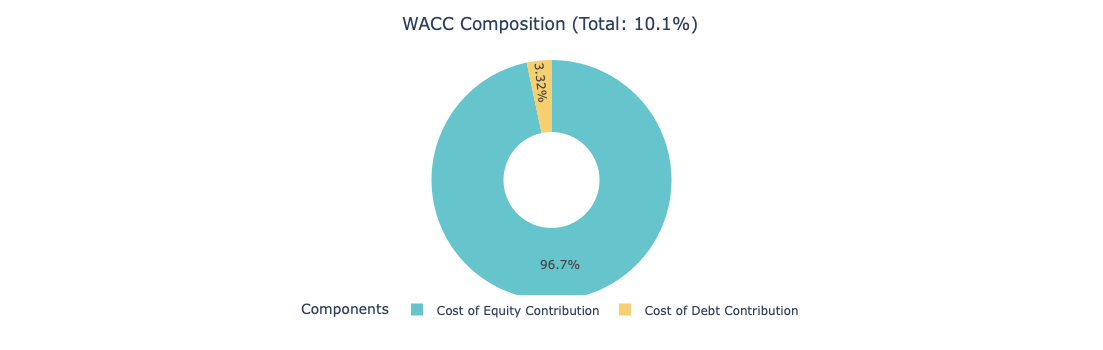

### Calculating & Projecting FCFF...

```
Found Change in WC / Op Activities directly: 18.05B
EBIT: 159.76B, Tax Rate: 24.5%
↳ NOPAT: 120.60B
  + Depreciation: 34.07B
  - CapEx: 10.51B
  - Change WC: 18.05B (Neg means outflow)
▶️ Calculated Historical FCFF (Most Recent): 126.11B
Recent Avg Revenue Growth (2yr): 6.8%
Using constrained initial growth rate for projection: 6.8%
Using Terminal Growth Rate (g): 4.0%
--- FCFF Projections ---
Year  Growth   FCFF            PV Factor  PV FCFF        
-------------------------------------------------------
1     6.8%     135B            0.9080     122B           
2     6.2%     143B            0.8245     118B           
3     5.7%     151B            0.7487     113B           
4     5.1%     159B            0.6798     108B           
5     4.6%     166B            0.6173     103B           
-------------------------------------------------------
Sum of PV(Forecasted FCFFs): 564.16B
FCFF Year 6 (Est.): 172.86B
Terminal Value (at Year 5): 2820.59B
PV Factor for TV: 0.6173
Present Value of Terminal Value: 1741.18B
```

### Final Valuation Calculation...

```
PV(Forecasted FCFFs): INR564.16B
PV(Terminal Value):   INR1741.18B
↳ Enterprise Value (EV): INR2305.34B
  - Total Debt (from WACC calc): INR243.81B
  + Cash & Equivalents: INR96.95B
  - Minority Interest: INR1.34B
↳ Equity Value: INR2157.14B
  ÷ Shares Outstanding: 10,460,300,288
▶️ Intrinsic Value per Share: INR206.22
```

### Financial Ratio Analysis...

Ratio,Wipro Limited Value,Benchmark*,Status
P/E,23.19,25.00,~ Average
P/B,3.44,4.00,~ Average
EV/EBITDA,11.89,15.00,✅ Low
ROE,14.8%,15.0%,~ Average
ROA,9.6%,8.0%,⬆️ Strong
ROCE,17.8%,12.0%,⬆️ Strong
Asset Turnover,0.78,0.70,~ Average
Current Ratio,2.58,1.50,⬆️ Strong
Quick Ratio,2.57,1.00,⬆️ Strong


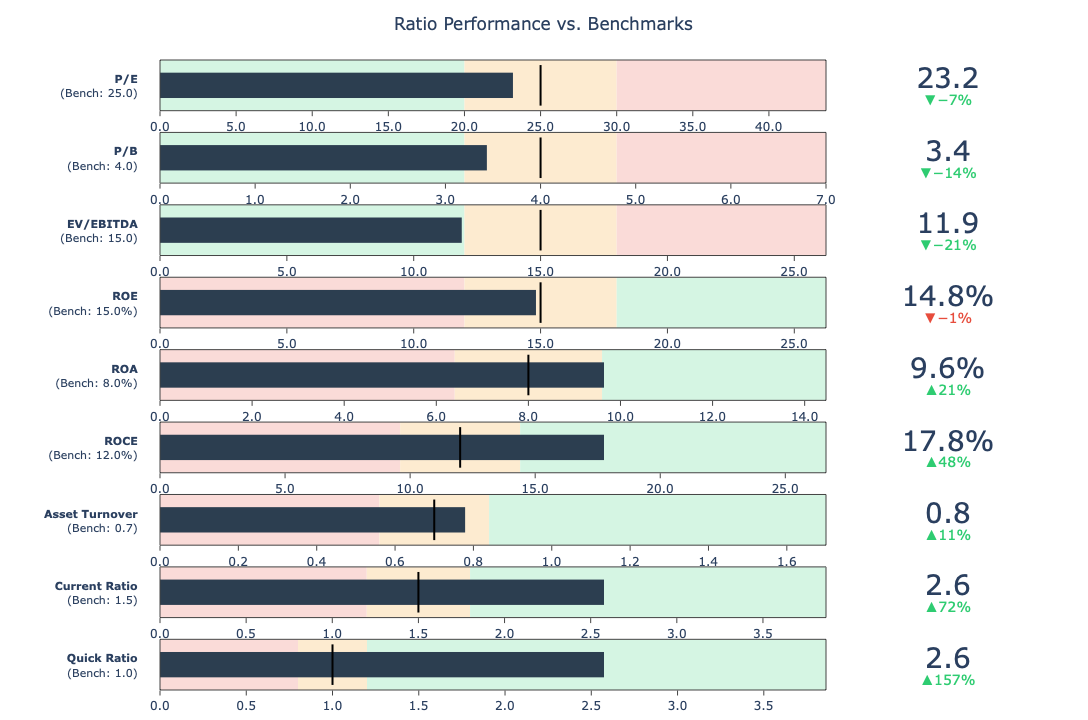

## Valuation Summary Dashboard: Wipro Limited (WIPRO.NS)

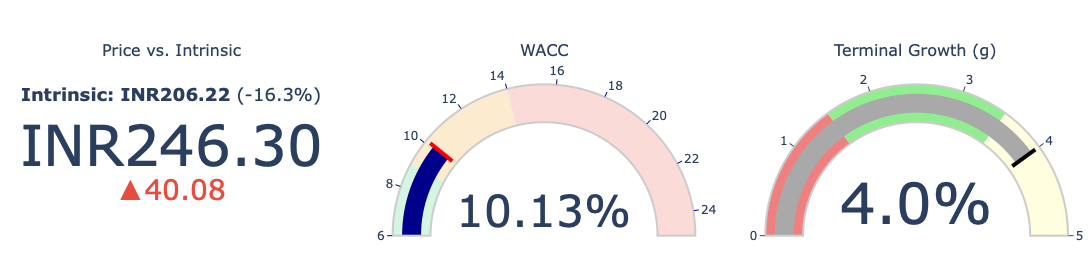

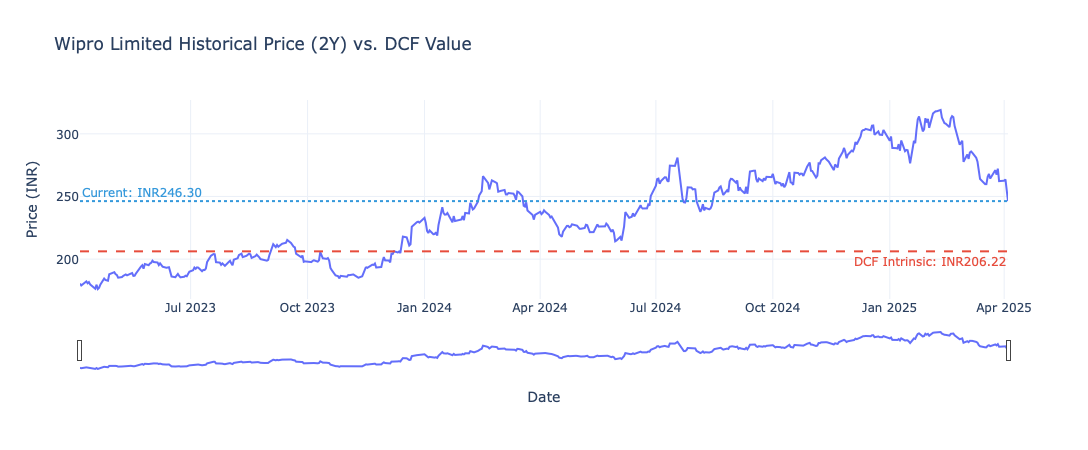

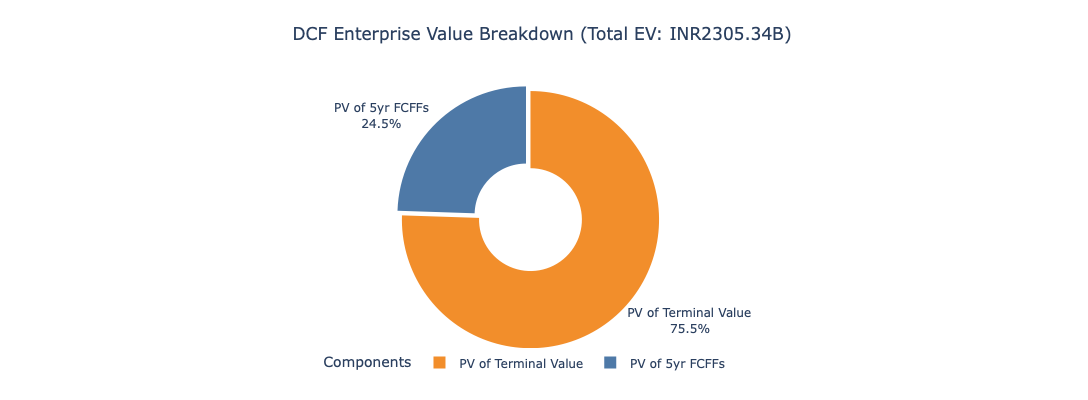

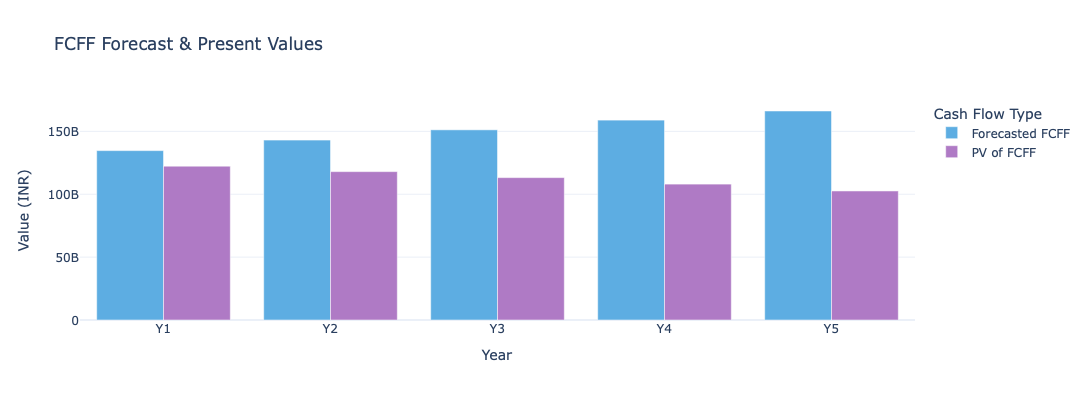

### Valuation Conclusion

> **<span style='color:#e74c3c'>🔻 Overvalued:</span> Current price (INR246.30) is **19.4%** above the calculated DCF intrinsic value (INR206.22).**

In [18]:
# -*- coding: utf-8 -*-
# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: light
#       format_version: '1.5'
#       jupytext_version: 1.14.5
#   kernelspec:
#     display_name: Python 3 (ipykernel)
#     language: python
#     name: python3
# ---

# %% [markdown]
# # Dynamic Stock Financial Analysis & DCF Valuation
# **(Interactive Report)**
#
# **Analyst:** Simulated AI Research Analyst
#
# **Objective:** To perform a comprehensive financial analysis and estimate the intrinsic value per share of a publicly traded company using the Discounted Cash Flow (DCF) methodology. This report utilizes dynamically fetched financial data and interactive visualizations.
#
# **Methodology:**
# 1.  **User Input:** Get ticker symbol from the user.
# 2.  **Data Acquisition:** Use `yfinance` to fetch financial statements, company info, and market data for the specified ticker.
# 3.  **WACC Calculation:** Determine the Weighted Average Cost of Capital (WACC) using CAPM and financial data.
# 4.  **FCFF Calculation & Projection:** Calculate historical Free Cash Flow to Firm (FCFF) and project it forward using a declining growth model.
# 5.  **Terminal Value:** Estimate the value beyond the explicit forecast period (Gordon Growth Model).
# 6.  **Discounting & Valuation:** Discount cash flows and terminal value to find Enterprise Value, Equity Value, and Intrinsic Value per Share.
# 7.  **Ratio Analysis:** Calculate key financial ratios and compare them to illustrative benchmarks.
# 8.  **Interactive Visualization:** Present findings using Plotly for interactive charts and gauges.

# %% [markdown]
# ## 1. Setup and Libraries

# %%
# Standard Libraries
import warnings
import sys
import numpy as np
import pandas as pd

# Data Fetching
import yfinance as yf

# Visualization (Using Plotly)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

# Display Utilities
from IPython.display import display, Markdown, HTML

# Settings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pio.templates.default = "plotly_white" # Cleaner Plotly template

# %% [markdown]
# ## 2. Configuration and Helper Functions

# %%
# --- Configuration (User Input overrides Ticker) ---
DEFAULT_TICKER = "WIPRO.NS" # Default if user input fails
FORECAST_YEARS = 5
RISK_FREE_RATE = 0.071     # Approx Indian 10Y Govt Bond Yield (Check current rates) - Adjust if analyzing non-Indian stock
MARKET_RISK_PREMIUM = 0.055 # Estimated Equity Market Risk Premium (Adjust for relevant market)
TERMINAL_GROWTH_RATE_CAP = 0.04 # Cap for perpetual growth rate
DEFAULT_CURRENCY_SYMBOL = "$" # Used if yfinance doesn't provide one
DEFAULT_TAX_RATE = 0.25     # General fallback tax rate if calculation fails *** <-- Added Global Default ***
MIN_WACC = 0.06 # Minimum realistic WACC
MAX_WACC = 0.25 # Maximum realistic WACC
MIN_TAX_RATE = 0.10 # Minimum realistic effective tax rate for bounding calculation
MAX_TAX_RATE = 0.40 # Maximum realistic effective tax rate for bounding calculation
MIN_GROWTH = 0.00 # Minimum growth rate floor
MAX_INITIAL_GROWTH = 0.20 # Ceiling for calculated initial growth rate
MIN_COST_OF_DEBT = 0.03
MAX_COST_OF_DEBT = 0.15

# Illustrative Industry Benchmarks (These are *highly generic*, replace for specific industries)
INDUSTRY_BENCHMARKS = {
    'P/E': 25.0, 'P/B': 4.0, 'EV/EBITDA': 15.0, 'ROE': 15.0,
    'ROA': 8.0, 'ROCE': 12.0, 'Asset Turnover': 0.7,
    'Current Ratio': 1.5, 'Quick Ratio': 1.0
}


# --- Helper Functions ---
def print_keys(statement, name):
    """Prints available keys in a yfinance statement for debugging"""
    print(f"\n--- Available Keys in {name} ---")
    if isinstance(statement, pd.DataFrame):
        valid_indices = [idx for idx in statement.index if idx is not None] # Filter out None indices if any
        print(", ".join(map(str, valid_indices)))
    elif isinstance(statement, dict):
        print(", ".join(statement.keys()))
    print("------------------------------------\n")

def safe_get(data, key_list, statement_name="Statement", default=0.0):
    """
    Safely retrieves a numeric value from yfinance data (Series or Dict).
    Tries multiple keys in order provided in key_list.
    Returns default if key is not found or data is invalid.
    """
    if not isinstance(key_list, list):
        key_list = [key_list] # Ensure it's a list

    value = None
    source = None

    for key in key_list:
      current_value = None
      if isinstance(data, pd.Series):
          source = "Series"
          if key in data.index:
              try:
                  val = data.loc[key]
                  # Handle potential Series return from multi-level index etc.
                  if isinstance(val, pd.Series):
                       if not val.empty and pd.notna(val.iloc[0]):
                            current_value = float(val.iloc[0])
                       # else leave as None
                  elif pd.notna(val): # Handle scalar values
                      current_value = float(val)
                  # else leave as None if NaN
              except (KeyError, TypeError, IndexError, ValueError):
                   pass # Try next key

      elif isinstance(data, dict):
          source = "Dict"
          raw_val = data.get(key) # Use .get for safety
          if raw_val is not None:
              try:
                  current_value = float(raw_val)
              except (TypeError, ValueError):
                   pass # Try next key

      # Check if we found a valid numeric value
      if current_value is not None and np.isfinite(current_value):
            value = current_value
            # print(f"[Debug safe_get] Found '{key}' in {statement_name} ({source}) = {value}")
            break # Stop searching once a valid key is found
      #else:
            #print(f"[Debug safe_get] Key '{key}' not found or invalid in {statement_name} ({source}).")


    if value is None:
        #print(f"[Warning safe_get] Keys {key_list} not found or invalid in {statement_name}. Using default: {default}.")
        value = default

    return value


def format_currency(value, symbol="$", precision=2):
    """Formats number as currency string, handles None/NaN."""
    if value is None or pd.isna(value):
        return "N/A"
    abs_val = abs(value)
    if abs_val >= 1e9: # Billions
        formatted_val = f"{value / 1e9:.{precision}f}B"
    elif abs_val >= 1e6: # Millions
         formatted_val = f"{value / 1e6:.{precision}f}M"
    elif abs_val >= 1e3: # Thousands
        formatted_val = f"{value / 1e3:.{precision}f}K"
    else:
         formatted_val = f"{value:.{precision}f}"
    return f"{symbol}{formatted_val}"


def format_percent(value, precision=1):
     """Formats number as percentage string, handles None/NaN."""
     if value is None or pd.isna(value):
        return "N/A"
     return f"{value * 100:.{precision}f}%"

# %% [markdown]
# ## 3. User Input: Specify Ticker Symbol

# %%
# Get Ticker Symbol from User
user_ticker = input(f"Enter the stock ticker symbol (e.g., MSFT, AAPL, RELIANCE.NS) [Default: {DEFAULT_TICKER}]: ")
if not user_ticker:
    user_ticker = DEFAULT_TICKER

ticker_symbol = user_ticker.strip().upper()
display(Markdown(f"**Analyzing Ticker:** `{ticker_symbol}`"))

# %% [markdown]
# ## 4. Data Acquisition

# %%
try:
    stock = yf.Ticker(ticker_symbol)

    # Attempt to fetch essential info first
    info = stock.info
    if not info or info.get('regularMarketPrice') is None : # Check if info seems empty or missing key data like price
        # Some tickers (like indices) won't have typical info but might have history
        hist_check = stock.history(period="5d")
        if hist_check.empty:
             # If both info is bad and history is empty, ticker is likely invalid
            raise ValueError(f"Ticker symbol '{ticker_symbol}' seems invalid or essential data is unavailable on Yahoo Finance.")
        else:
             # If info failed but history works, proceed with caution
             print(f"Warning: Limited info found for {ticker_symbol}. Analysis quality may be reduced.")
             info = {} # Reset info to empty dict to force safe_get defaults


    # Fetch financials (use period='annual' - can be changed)
    financials = stock.financials # Income Statement
    balance_sheet = stock.balance_sheet # Balance Sheet
    cashflow = stock.cashflow # Cash Flow Statement

    # Check if primary financial statements are empty
    if financials.empty or balance_sheet.empty or cashflow.empty:
       print(f"Warning: One or more financial statements (Income, Balance Sheet, Cashflow) are empty for {ticker_symbol}. DCF analysis might not be possible or reliable.")
       # Allow proceeding but expect potential errors / N/A results later

    hist = stock.history(period="2y") # 2 years of historical price data

    # --- Key Info Extraction (with more defaults) ---
    company_name = info.get("longName", ticker_symbol)
    currency_symbol = info.get("currency", DEFAULT_CURRENCY_SYMBOL)
    if not isinstance(currency_symbol, str) or len(currency_symbol)>5 : # simple sanity check
        currency_symbol=DEFAULT_CURRENCY_SYMBOL
    currency_code = currency_symbol # Often the same, e.g., USD, INR

    # Try harder to get current price
    current_price = safe_get(info, ['currentPrice', 'regularMarketPrice', 'previousClose'], 'Info', default=0.0)
    if current_price == 0.0 and not hist.empty:
        current_price = hist['Close'].iloc[-1] # Fallback to last historical close
    if current_price == 0.0:
        print(f"Warning: Could not determine current price for {ticker_symbol}.")

    shares_outstanding = safe_get(info, ['sharesOutstanding'], 'Info', default=0)
    beta = safe_get(info, ['beta'], 'Info', default=1.0) # Default Beta to 1.0 if missing
    market_cap = safe_get(info, ['marketCap'], 'Info', default=0)
    if market_cap <= 0 and shares_outstanding > 0 and current_price > 0:
       market_cap = shares_outstanding * current_price # Calculate if possible
       info['marketCap'] = market_cap # Store calculated MC back in info dict

    sector = info.get("sector", "N/A")
    industry = info.get("industry", "N/A")
    summary = info.get("longBusinessSummary", "No summary available.")

    display(Markdown(f"**Company:** {company_name}"))
    display(Markdown(f"**Sector:** {sector} | **Industry:** {industry}"))
    display(Markdown(f"**Currency:** {currency_code} ({currency_symbol})"))
    display(Markdown(f"**Current Market Price:** {format_currency(current_price, currency_symbol)}") if current_price > 0 else Markdown("**Current Market Price:** N/A"))
    display(Markdown(f"**Market Cap:** {format_currency(market_cap, currency_symbol)}") if market_cap > 0 else Markdown("**Market Cap:** N/A"))
    display(Markdown(f"**Beta:** {beta:.2f}"))
    #display(Markdown(f"**Business Summary:** {summary[:300]}...")) # Show partial summary

    # Optionally print keys if debugging specific tickers
    # print_keys(financials, "Income Statement")
    # print_keys(balance_sheet, "Balance Sheet")
    # print_keys(cashflow, "Cash Flow Statement")
    # print("\n--- Info Keys ---")
    # print(", ".join(info.keys()))


except Exception as e:
    print(f"❌ ERROR: Failed to fetch or process initial data for {ticker_symbol}. Error: {e}")
    sys.exit("Cannot proceed without basic stock data.") # Exit gracefully

# Check for essential data points needed for DCF
if shares_outstanding <= 0:
    print(f"❌ ERROR: Shares Outstanding data unavailable or zero for {ticker_symbol}. Cannot calculate per-share value.")
    sys.exit("Essential data missing.")
if market_cap <= 0 : # Try calculating again if possible
     if shares_outstanding > 0 and current_price > 0:
        market_cap = shares_outstanding * current_price
        info['marketCap'] = market_cap # Store back
     # If still no market cap after calc attempt
     if market_cap <= 0:
        print(f"⚠️ WARNING: Market Cap is zero or unavailable. WACC calculation will rely on Book Equity and may be less accurate.")
        # Allow continuing but WACC quality is lower


# %% [markdown]
# ## 5. WACC Calculation
# Determining the discount rate (WACC) using the Capital Asset Pricing Model (CAPM) for the Cost of Equity.

# %%
def calculate_wacc(stock_info, financials_df, balance_sheet_df, R_f=RISK_FREE_RATE, MRP=MARKET_RISK_PREMIUM):
    """
    Calculates the Weighted Average Cost of Capital (WACC).
    Uses more robust safe_get and default values.
    Now accepts info dict directly. financials_df, balance_sheet_df passed for data.
    """
    display(Markdown("### Calculating WACC..."))
    components = {}
    calculation_log = [] # Store steps for display

    # --- Cost of Equity (Ke) ---
    # Use safe_get for beta directly from info dict
    beta_val = safe_get(stock_info, ['beta'], 'Info', default=1.0)
    if beta_val <= 0: # Add check for non-positive beta
        calculation_log.append(f"⚠️ Beta invalid ({beta_val:.2f}). Defaulting to 1.0.")
        beta_val = 1.0
    components['beta'] = beta_val
    components['risk_free_rate'] = R_f
    components['market_risk_premium'] = MRP

    cost_of_equity = R_f + beta_val * MRP
    components['cost_of_equity'] = cost_of_equity
    calculation_log.append(f"Risk-Free Rate: {format_percent(R_f)}, Beta: {beta_val:.2f}, MRP: {format_percent(MRP)}")
    calculation_log.append(f"↳ Cost of Equity (Ke): {format_percent(cost_of_equity)}")


    # --- Cost of Debt (Kd) & Tax Rate (T) ---
    cost_of_debt_pre_tax = 0.0
    tax_rate = 0.0
    after_tax_cost_of_debt = 0.0
    total_debt = 0.0

    # Set defaults in case statements are missing
    default_cod = (R_f + 0.03) # Default: Risk-free + Spread
    cost_of_debt_pre_tax = default_cod
    tax_rate = DEFAULT_TAX_RATE

    if not balance_sheet_df.empty and not financials_df.empty:
        latest_bs = balance_sheet_df.iloc[:, 0]
        latest_fin = financials_df.iloc[:, 0]

        # Get Total Debt (more robustly)
        debt_keys = ['Total Debt', 'Long Term Debt', 'Long Term Debt And Capital Lease Obligation'] # Prioritize LTD if specific Total Debt absent
        long_term_debt = safe_get(latest_bs, debt_keys , 'Balance Sheet')

        current_debt_keys = ['Current Debt', 'Short Term Debt', 'Current Debt And Capital Lease Obligation', 'Short Long Term Debt']
        short_term_debt = safe_get(latest_bs, current_debt_keys , 'Balance Sheet')

        # yfinance sometimes lumps everything into Current Liabilities; check this if specific keys fail
        if long_term_debt == 0 and short_term_debt == 0:
             print("Info: Standard debt keys not found/zero, checking alternative calculation.")
             # Use safe_get with default=0 for these items if needed elsewhere
             total_liab = safe_get(latest_bs, ['Total Liabilities Net Minority Interest'], 'Balance Sheet')
             total_equity = safe_get(latest_bs, ['Total Equity Gross Minority Interest', 'Total Stockholder Equity'], 'Balance Sheet')
             total_assets_check = safe_get(latest_bs, ['Total Assets'], 'Balance Sheet')
             # Rough Check: Assets = Liab + Equity? if total_liab+total_equity close to assets, might be ok
             # Simplistic fallback: Assume total liabilities less accounts payable? (Very rough)
             # accounts_payable = safe_get(latest_bs, ['Accounts Payable'], 'Balance Sheet')
             # if total_liab > accounts_payable: total_debt = total_liab - accounts_payable # Highly approximate!
             total_debt = long_term_debt + short_term_debt # Recalculate (likely still 0 here)
             print(f"Warning: Using potentially zero debt ({total_debt:.0f}) based on standard keys.")
        else:
             total_debt = long_term_debt + short_term_debt

        components['debt_value_used'] = total_debt # Store the debt value used


        interest_expense = abs(safe_get(latest_fin, ['Interest Expense'], 'Income Statement')) # Use absolute value

        # Estimate Cost of Debt
        if total_debt > 1000 and interest_expense > 0: # Require some minimum debt and interest for calculation
             implied_rate = interest_expense / total_debt
             if MIN_COST_OF_DEBT <= implied_rate <= MAX_COST_OF_DEBT:
                  cost_of_debt_pre_tax = implied_rate
                  calculation_log.append(f"Interest Expense: {format_currency(interest_expense, symbol='')}, Total Debt: {format_currency(total_debt, symbol='')}")
                  calculation_log.append(f"↳ Implied Cost of Debt (Kd pre-tax): {format_percent(cost_of_debt_pre_tax)}")
             else:
                  cost_of_debt_pre_tax = default_cod
                  calculation_log.append(f"⚠️ Implied Cost of Debt ({format_percent(implied_rate)}) out of bounds ({format_percent(MIN_COST_OF_DEBT)}-{format_percent(MAX_COST_OF_DEBT)}). Using default: {format_percent(cost_of_debt_pre_tax)}")
        elif total_debt > 1000 and interest_expense <=0 :
            cost_of_debt_pre_tax = default_cod # has debt but no interest? use default
            calculation_log.append(f"ℹ️ Found Debt ({format_currency(total_debt, symbol='')}) but no Interest Expense. Using default Cost of Debt: {format_percent(cost_of_debt_pre_tax)}")
        else: # No significant debt found
             cost_of_debt_pre_tax = 0.0 # Assume cost of debt is negligible if debt is effectively zero
             calculation_log.append(f"ℹ️ Total Debt negligible ({format_currency(total_debt, symbol='')}). Setting Cost of Debt to 0%.")

        components['cost_of_debt'] = cost_of_debt_pre_tax


        # Estimate Tax Rate
        income_tax_expense = safe_get(latest_fin, ['Tax Provision', 'Income Tax Expense'], 'Income Statement') # More keys
        pretax_income = safe_get(latest_fin, ['Pretax Income', 'EBT'], 'Income Statement') # More keys

        # Try calculating Pretax Income from EBIT if direct keys fail/zero
        if pretax_income <= 0 :
            ebit_val = safe_get(latest_fin, ["EBIT", "Ebit", "Operating Income"], "Income Statement")
            interest_expense_for_ebt = abs(safe_get(latest_fin, ['Interest Expense'], 'Income Statement')) # Recalc needed here if scope different
            if ebit_val > 0:
                pretax_income = ebit_val - interest_expense_for_ebt

        if pretax_income > 0 and income_tax_expense > 0:
            calculated_tax_rate = income_tax_expense / pretax_income
            # Apply sanity check (use configured bounds)
            tax_rate = min(max(calculated_tax_rate, MIN_TAX_RATE), MAX_TAX_RATE)
            calculation_log.append(f"Income Tax Expense: {format_currency(income_tax_expense, symbol='')}, Pretax Income: {format_currency(pretax_income, symbol='')}")
            calculation_log.append(f"↳ Effective Tax Rate (derived & bounded): {format_percent(tax_rate)}")
        else:
             # If calculation fails, use the GLOBAL Default Tax Rate
             tax_rate = DEFAULT_TAX_RATE
             calculation_log.append(f"⚠️ Cannot reliably derive tax rate (Pretax Income: {format_currency(pretax_income, symbol='')}, Tax Exp: {format_currency(income_tax_expense, symbol='')}). Using global default: {format_percent(tax_rate)}")

    else: # Handle case where financial statements were missing/empty
         calculation_log.append("⚠️ Financial statements empty. Using default Cost of Debt and Tax Rate.")
         # cost_of_debt_pre_tax and tax_rate already set to defaults above

    components['tax_rate'] = tax_rate
    after_tax_cost_of_debt = cost_of_debt_pre_tax * (1 - tax_rate)
    components['after_tax_cost_of_debt'] = after_tax_cost_of_debt
    if cost_of_debt_pre_tax > 0 : # Only log if CoD was non-zero
        calculation_log.append(f"↳ Cost of Debt (After-tax): {format_percent(after_tax_cost_of_debt)}")


    # --- Weights (E/V, D/V) ---
    market_cap_val = safe_get(stock_info, ['marketCap'], 'Info', default=0.0)

    # Try book equity as fallback for equity weight calculation if market cap missing
    book_equity_fallback_used = False
    if market_cap_val <= 0:
       if not balance_sheet_df.empty:
           latest_bs = balance_sheet_df.iloc[:, 0]
           book_equity_val = safe_get(latest_bs, ['Total Stockholder Equity', 'Stockholders Equity'], 'Balance Sheet', default=1.0) # Default 1 to avoid zero total cap
           if book_equity_val > 1.0: # Check if default wasn't just used
              market_cap_val = book_equity_val # Use book equity as proxy for market equity value
              calculation_log.append("⚠️ Market Cap unavailable. Using Book Equity for weight calculation (less accurate).")
              book_equity_fallback_used = True
           else: # Book equity also unavailable or zero
              market_cap_val = 1.0 # Final fallback to avoid division by zero
              calculation_log.append("⚠️ Market Cap & Book Equity unavailable. Using placeholder value (1.0) for weight calc.")
       else: # BS empty, cannot get book equity
            market_cap_val = 1.0
            calculation_log.append("⚠️ Market Cap unavailable & Balance Sheet Empty. Using placeholder value (1.0) for weight calc.")


    components['equity_value_used'] = market_cap_val
    # Debt value stored earlier in components['debt_value_used']

    equity_weight = 0.7 # Defaults
    debt_weight = 0.3 # Defaults
    total_capital = market_cap_val + total_debt # Use debt value from calculation step

    if total_capital <= 0:
        calculation_log.append(f"❌ ERROR: Total Capital (E:{format_currency(market_cap_val, symbol='')} + D:{format_currency(total_debt, symbol='')}) is zero or negative. Using default weights (70% E, 30% D).")
        # weights already set to defaults
    else:
        equity_weight = market_cap_val / total_capital
        debt_weight = total_debt / total_capital

        # Normalize weights if needed due to float issues or extreme values
        total_weight = equity_weight + debt_weight
        if abs(total_weight - 1.0) > 1e-6:
            if total_weight > 0 :
               equity_weight = equity_weight / total_weight
               debt_weight = debt_weight / total_weight
            # else: Should not happen if total_capital > 0, defaults remain

    components['equity_weight'] = equity_weight
    components['debt_weight'] = debt_weight
    calculation_log.append(f"Equity Value Used: {format_currency(market_cap_val, symbol='')}{' (Book Equity Fallback)' if book_equity_fallback_used else ''}")
    calculation_log.append(f"Debt Value Used: {format_currency(total_debt, symbol='')}")
    calculation_log.append(f"↳ Equity Weight (E/V): {format_percent(equity_weight)}, Debt Weight (D/V): {format_percent(debt_weight)}")


    # --- Final WACC Calculation ---
    wacc = (equity_weight * cost_of_equity) + (debt_weight * after_tax_cost_of_debt)

    # Apply final sanity check boundary for WACC
    original_wacc = wacc
    wacc = min(max(wacc, MIN_WACC), MAX_WACC) # Constrain WACC
    if wacc != original_wacc and abs(wacc-original_wacc) > 0.0001 : # Log if adjustment was significant
       calculation_log.append(f"⚠️ Original WACC ({format_percent(original_wacc)}) outside bounds ({format_percent(MIN_WACC)}-{format_percent(MAX_WACC)}). Adjusted to {format_percent(wacc)}.")

    components['final_wacc'] = wacc
    calculation_log.append(f"▶️ Calculated WACC: {format_percent(wacc)}")

    # --- Display Calculation Log ---
    display(Markdown("```\n" + "\n".join(calculation_log) + "\n```"))

    # --- Generate Donut Chart for WACC Composition ---
    equity_contrib = equity_weight * cost_of_equity
    debt_contrib = debt_weight * after_tax_cost_of_debt
    labels = ['Cost of Equity Contribution', 'Cost of Debt Contribution']
    values = [equity_contrib, debt_contrib]

    # Check if contributions are valid numbers and sum is > 0
    if all(np.isfinite(v) for v in values) and sum(values) > 0.0001 :
       fig_wacc_donut = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4,
                                            marker_colors=px.colors.qualitative.Pastel,
                                            hovertemplate='<b>%{label}</b><br>Contribution: %{value:.2%}<extra></extra>', # Use % format here
                                            textinfo='percent', textfont_size=12)]) # Show percentage on slices
       fig_wacc_donut.update_layout(
            title_text=f'WACC Composition (Total: {format_percent(wacc)})',
            title_x=0.5,
            showlegend=True,
            legend_title_text='Components',
            legend=dict(orientation="h", yanchor="bottom", y=-0.1, xanchor="center", x=0.5), # Horizontal legend below
            margin=dict(l=20, r=20, t=60, b=50), # Adjust bottom margin for legend
            height=350 # Slightly more height for legend
       )
       fig_wacc_donut.show()
    else:
       display(Markdown(f"*(WACC component contributions are zero or invalid: Eq={equity_contrib:.3f}, Dt={debt_contrib:.3f}. Cannot generate chart)*"))


    return wacc, components

# %%
# Calculate WACC
# Pass info dict directly now
discount_rate, wacc_components = calculate_wacc(info, financials, balance_sheet, RISK_FREE_RATE, MARKET_RISK_PREMIUM)

# %% [markdown]
# ## 6. FCFF Calculation & Projection
# Calculating historical Free Cash Flow to Firm (FCFF) and projecting it forward.

# %%
def calculate_and_project_fcff(financials_df, balance_sheet_df, cashflow_df, wacc_comps, disc_rate, forecast_yrs):
    display(Markdown("### Calculating & Projecting FCFF..."))
    projection_log = []
    projection_results = {
        'current_fcff': None, 'projected_fcffs': [], 'growth_rates': [],
        'pv_fcffs': [], 'cumulative_pv_fcff': 0, 'terminal_growth_rate': None,
        'terminal_value': None, 'pv_terminal_value': None, 'error': None
    }

    if financials_df.empty or balance_sheet_df.empty or cashflow_df.empty:
         projection_log.append("❌ ERROR: Required financial statements are missing. Cannot calculate FCFF.")
         projection_results['error'] = "Missing financial statements."
         display(Markdown("```\n" + "\n".join(projection_log) + "\n```"))
         return projection_results # Return early

    # Use the most recent year's data
    latest_fin = financials_df.iloc[:, 0]
    latest_cf = cashflow_df.iloc[:, 0]
    latest_bs = balance_sheet_df.iloc[:, 0]

    # Get components for historical FCFF
    ebit = safe_get(latest_fin, ["EBIT", "Ebit", "Operating Income"], "Income Statement")
    # *** CORRECTED LINE: Use global default as fallback ***
    tax_rate = wacc_comps.get('tax_rate', DEFAULT_TAX_RATE) # Use WACC calculated tax rate
    nopat = ebit * (1 - tax_rate)

    depreciation_amortization = safe_get(latest_cf, ["Depreciation And Amortization", "Depreciation", "Depreciation Amortization Depletion"], "Cash Flow") # More keys

    # CapEx is negative in CF statement, use absolute
    # Added more keys like Net PPE Purchase
    capex_keys = ["Capital Expenditure", "Net Capital Expenditure",
                   "Purchase Of Property Plant Equipment", "Net PPE Purchase And Sale"]
    capital_expenditures = abs(safe_get(latest_cf, capex_keys , "Cash Flow"))

    # Change in Working Capital (use directly if available, else calculate)
    wc_keys = ["Change In Working Capital", "Change In Operating Capital", "Change In Operating Assets And Liabilities", "Change In Receivables"] # Broader Keys
    change_in_wc = safe_get(latest_cf, wc_keys , "Cash Flow", default=None) # Default None to trigger calc

    if change_in_wc is None:
        projection_log.append("⏳ Change in WC not found directly, attempting calculation...")
        if balance_sheet_df.shape[1] >= 2: # Need previous year data
             prev_bs = balance_sheet_df.iloc[:, 1]
             # WC = (Current Assets - Cash) - (Current Liabilities - ST Debt) - More standard definition
             # Safer to just use Total Current Assets - Total Current Liabilities if specifics fail
             curr_assets = safe_get(latest_bs, ['Current Assets', 'Total Current Assets'], 'Balance Sheet')
             curr_liab = safe_get(latest_bs, ['Current Liabilities', 'Total Current Liabilities'], 'Balance Sheet')
             curr_wc = curr_assets - curr_liab

             prev_assets = safe_get(prev_bs, ['Current Assets', 'Total Current Assets'], 'Prev Balance Sheet')
             prev_liab = safe_get(prev_bs, ['Current Liabilities', 'Total Current Liabilities'], 'Prev Balance Sheet')
             prev_wc = prev_assets - prev_liab

             change_in_wc = curr_wc - prev_wc
             # Use abs() here? No, sign matters: increase in WC is a cash outflow (-) for FCFF calc below
             projection_log.append(f"   Calculated Change in Total WC: {format_currency(change_in_wc, symbol='')}")
        else:
             change_in_wc = 0 # Cannot calculate, assume 0
             projection_log.append("⚠️ Cannot calculate Change in WC (missing previous year BS). Using 0.")
    else:
         projection_log.append(f"Found Change in WC / Op Activities directly: {format_currency(change_in_wc, symbol='')}")


    # Calculate latest historical FCFF
    fcff_current = nopat + depreciation_amortization - capital_expenditures - change_in_wc
    projection_results['current_fcff'] = fcff_current

    projection_log.append(f"EBIT: {format_currency(ebit, symbol='')}, Tax Rate: {format_percent(tax_rate)}")
    projection_log.append(f"↳ NOPAT: {format_currency(nopat, symbol='')}")
    projection_log.append(f"  + Depreciation: {format_currency(depreciation_amortization, symbol='')}")
    projection_log.append(f"  - CapEx: {format_currency(capital_expenditures, symbol='')}")
    projection_log.append(f"  - Change WC: {format_currency(change_in_wc, symbol='')} "
                          f"{'(Neg means outflow)' if change_in_wc > 0 else '(Pos means inflow)'}") # Clarify WC sign impact
    projection_log.append(f"▶️ Calculated Historical FCFF (Most Recent): {format_currency(fcff_current, symbol='')}")


    # --- Estimate Initial Growth Rate for Projection ---
    initial_growth_rate = 0.06 # Default
    try:
        # Use recent revenue growth (up to 3 years average), constrained
        if financials_df.shape[1] >= 2:
            rev_keys = ["Total Revenue", "Revenue", "Net Revenue"]
            rev_t = safe_get(financials_df.iloc[:, 0], rev_keys, 'Income Stmt')
            rev_t1 = safe_get(financials_df.iloc[:, 1], rev_keys, 'Income Stmt')
            g1 = (rev_t / rev_t1) - 1 if rev_t1 > 0 else 0

            growth_years_used = 1
            avg_hist_growth = g1

            if financials_df.shape[1] >= 3:
                 rev_t2 = safe_get(financials_df.iloc[:, 2], rev_keys, 'Income Stmt')
                 g2 = (rev_t1 / rev_t2) - 1 if rev_t2 > 0 else 0
                 avg_hist_growth = (g1 + g2) / 2 # Use 2-year average if available
                 growth_years_used = 2
                 # Optional: Extend to 3-year avg if desired and data exists

            projection_log.append(f"Recent Avg Revenue Growth ({growth_years_used}yr): {format_percent(avg_hist_growth)}")

            # Constrain growth rate (configured bounds)
            initial_growth_rate = min(max(avg_hist_growth, MIN_GROWTH), MAX_INITIAL_GROWTH)
            projection_log.append(f"Using constrained initial growth rate for projection: {format_percent(initial_growth_rate)}")
        else:
            projection_log.append(f"⚠️ Insufficient historical revenue data. Using default initial growth rate: {format_percent(initial_growth_rate)}")

    except Exception as e:
        projection_log.append(f"⚠️ Error calculating historical growth ({e}). Using default initial growth rate: {format_percent(initial_growth_rate)}")


    # --- Determine Terminal Growth Rate (g) ---
    # Be conservative: Lower of Config Cap, portion of WACC, initial growth, or market risk free rate * 0.7
    terminal_growth_rate = min(TERMINAL_GROWTH_RATE_CAP, disc_rate * 0.4, initial_growth_rate, RISK_FREE_RATE * 0.7)
    terminal_growth_rate = max(MIN_GROWTH, terminal_growth_rate) # Floor at MIN_GROWTH
    if terminal_growth_rate >= disc_rate:
        original_g = terminal_growth_rate
        terminal_growth_rate = disc_rate - 0.005 # Ensure g < WACC, give small margin
        projection_log.append(f"⚠️ Initial Terminal Growth ({format_percent(original_g)}) >= WACC ({format_percent(disc_rate)}). Reduced to {format_percent(terminal_growth_rate)}.")
    projection_log.append(f"Using Terminal Growth Rate (g): {format_percent(terminal_growth_rate)}")
    projection_results['terminal_growth_rate'] = terminal_growth_rate

    # --- Project FCFF and Calculate PVs ---
    projected_fcffs = []
    growth_rates_applied = []
    pv_fcffs = []
    cumulative_pv_fcff = 0

    current_fcff_for_proj = fcff_current
    # Handle negative starting FCFF - apply low growth/decay floor
    if current_fcff_for_proj <= 0:
         projection_log.append("⚠️ Starting FCFF is negative or zero. Applying minimal growth/decay floor.")
         initial_growth_rate = min(initial_growth_rate, 0.01) # Cap growth heavily
         terminal_growth_rate = min(terminal_growth_rate, 0.00) # Allow zero/negative terminal for negative starters

    projection_log.append("--- FCFF Projections ---")
    projection_log.append(f"{'Year':<5} {'Growth':<8} {'FCFF':<15} {'PV Factor':<10} {'PV FCFF':<15}")
    projection_log.append("-" * 55)


    for year in range(1, forecast_yrs + 1):
        # Declining growth rate model
        year_factor = (forecast_yrs - year + 1) / forecast_yrs
        growth_rate = terminal_growth_rate + (initial_growth_rate - terminal_growth_rate) * year_factor
        # Apply growth floor (already done for initial/terminal if needed)
        # Allow slightly negative growth if base was negative
        growth_rate = max(-0.05, growth_rate) if current_fcff_for_proj <=0 else max(MIN_GROWTH, growth_rate)


        growth_rates_applied.append(growth_rate)

        # Forecast FCFF
        if year == 1:
            fcff_forecast = current_fcff_for_proj * (1 + growth_rate)
        else:
            fcff_forecast = projected_fcffs[-1] * (1 + growth_rate)
        projected_fcffs.append(fcff_forecast)

        # Calculate Present Value
        pv_factor = 1 / ((1 + disc_rate) ** year)
        pv_fcff = fcff_forecast * pv_factor
        pv_fcffs.append(pv_fcff)
        cumulative_pv_fcff += pv_fcff # Sum even if negative

        projection_log.append(f"{year:<5} {format_percent(growth_rate):<8} {format_currency(fcff_forecast, symbol='', precision=0):<15} {pv_factor:<10.4f} {format_currency(pv_fcff, symbol='', precision=0):<15}")

    projection_results['projected_fcffs'] = projected_fcffs
    projection_results['growth_rates'] = growth_rates_applied
    projection_results['pv_fcffs'] = pv_fcffs
    projection_results['cumulative_pv_fcff'] = cumulative_pv_fcff
    projection_log.append("-" * 55)
    projection_log.append(f"Sum of PV(Forecasted FCFFs): {format_currency(cumulative_pv_fcff, symbol='')}")


    # --- Calculate Terminal Value (TV) ---
    # Ensure WACC > g before calculating
    if (disc_rate - terminal_growth_rate) <= 0.001: # Use small margin for safety
         projection_log.append(f"❌ ERROR: WACC ({format_percent(disc_rate)}) <= Terminal Growth Rate ({format_percent(terminal_growth_rate)}). Cannot calculate Terminal Value reliably.")
         terminal_value = 0
         pv_terminal_value = 0
         projection_results['error'] = "WACC <= Terminal Growth. TV Calculation failed."
    else:
         fcff_terminal_base = projected_fcffs[-1] # FCFF in the last forecast year
         # If last year FCFF is negative, TV should likely be zero.
         if fcff_terminal_base <= 0:
             projection_log.append(f"ℹ️ FCFF in last forecast year ({format_currency(fcff_terminal_base, symbol='')}) is not positive. Setting Terminal Value to 0.")
             terminal_value = 0
             pv_terminal_value = 0
         else:
              fcff_n_plus_1 = fcff_terminal_base * (1 + terminal_growth_rate)
              terminal_value = fcff_n_plus_1 / (disc_rate - terminal_growth_rate)
              # Cap TV relative to current EV maybe? Or let it run large? Let it run for now.
              pv_terminal_value = terminal_value / ((1 + disc_rate) ** forecast_yrs)

              projection_log.append(f"FCFF Year {forecast_yrs+1} (Est.): {format_currency(fcff_n_plus_1, symbol='')}")
              projection_log.append(f"Terminal Value (at Year {forecast_yrs}): {format_currency(terminal_value, symbol='')}")
              projection_log.append(f"PV Factor for TV: {1/((1 + disc_rate) ** forecast_yrs):.4f}")
              projection_log.append(f"Present Value of Terminal Value: {format_currency(pv_terminal_value, symbol='')}")


    projection_results['terminal_value'] = terminal_value
    projection_results['pv_terminal_value'] = pv_terminal_value


    # --- Display Log ---
    display(Markdown("```\n" + "\n".join(projection_log) + "\n```"))

    return projection_results

# %%
# Execute FCFF calculation and projection
fcff_results = calculate_and_project_fcff(financials, balance_sheet, cashflow, wacc_components, discount_rate, FORECAST_YEARS)

# %% [markdown]
# ## 7. Enterprise Value and Equity Value Calculation

# %%
def calculate_final_valuation(fcff_data, balance_sheet_df, shares_outstanding_val, currency_sym):
    """ Includes currency_sym now """
    display(Markdown("### Final Valuation Calculation..."))
    valuation = {'enterprise_value': None, 'equity_value': None, 'intrinsic_value_per_share': None, 'error': None}
    valuation_log = []

    # Check for prior errors or invalid inputs
    if fcff_data is None or fcff_data.get('error'):
        valuation['error'] = f"Cannot calculate final valuation due to FCFF error: {fcff_data.get('error', 'Unknown FCFF Error')}"
        valuation_log.append(f"❌ ERROR: {valuation['error']}")
        display(Markdown("```\n" + "\n".join(valuation_log) + "\n```"))
        return valuation

    pv_forecast_sum = fcff_data.get('cumulative_pv_fcff')
    pv_tv = fcff_data.get('pv_terminal_value')

    if pv_forecast_sum is None or pv_tv is None:
         valuation['error'] = "Cannot calculate final valuation due to missing PV components in FCFF results."
         valuation_log.append(f"❌ ERROR: {valuation['error']}")
         display(Markdown("```\n" + "\n".join(valuation_log) + "\n```"))
         return valuation

    # --- Enterprise Value ---
    enterprise_value = pv_forecast_sum + pv_tv
    valuation['enterprise_value'] = enterprise_value
    valuation_log.append(f"PV(Forecasted FCFFs): {format_currency(pv_forecast_sum, currency_sym)}")
    valuation_log.append(f"PV(Terminal Value):   {format_currency(pv_tv, currency_sym)}")
    valuation_log.append(f"↳ Enterprise Value (EV): {format_currency(enterprise_value, currency_sym)}")

    # --- Equity Value ---
    total_debt_latest = 0.0
    cash_and_equivalents = 0.0
    minority_interest = 0.0 # Sometimes subtracted

    if not balance_sheet_df.empty:
         latest_bs = balance_sheet_df.iloc[:, 0]
         # Get Debt (use WACC component calculation's result)
         total_debt_latest = wacc_components.get('debt_value_used', 0.0) # From WACC step
         valuation_log.append(f"  - Total Debt (from WACC calc): {format_currency(total_debt_latest, currency_sym)}")

         # Get Cash & Equivalents (use safe_get with multiple keys)
         cash_keys = ["Cash And Cash Equivalents", "Cash Cash Equivalents And Short Term Investments", "Cash Financial", "Cash"]
         cash_and_equivalents = safe_get(latest_bs, cash_keys, "Balance Sheet")
         valuation_log.append(f"  + Cash & Equivalents: {format_currency(cash_and_equivalents, currency_sym)}")

         # Optional: Get Minority Interest (sometimes subtracted)
         minority_interest = safe_get(latest_bs, ["Minority Interest", "Noncontrolling Interest"], "Balance Sheet")
         if minority_interest != 0.0:
            valuation_log.append(f"  - Minority Interest: {format_currency(minority_interest, currency_sym)}")

    else:
         valuation_log.append("⚠️ Balance Sheet empty, cannot adjust EV for Debt, Cash, Minority Interest.")
         # Enterprise value will roughly equal equity value in this degraded case

    # Standard Equity Value: EV - Debt - Minority Interest + Cash
    equity_value = enterprise_value - total_debt_latest - minority_interest + cash_and_equivalents
    valuation['equity_value'] = equity_value
    valuation_log.append(f"↳ Equity Value: {format_currency(equity_value, currency_sym)}")

    # --- Intrinsic Value per Share ---
    intrinsic_value_per_share = 0.0
    if shares_outstanding_val is None or shares_outstanding_val <= 0:
        valuation['error'] = "Shares Outstanding is zero or invalid. Cannot calculate Intrinsic Value per Share."
        valuation_log.append(f"❌ ERROR: {valuation['error']}")
    elif equity_value is None: # Check if equity value calc failed
         valuation['error'] = "Equity value calculation failed. Cannot calculate Intrinsic Value per Share."
         valuation_log.append(f"❌ ERROR: {valuation['error']}")
    else:
        intrinsic_value_per_share = equity_value / shares_outstanding_val
        valuation_log.append(f"  ÷ Shares Outstanding: {shares_outstanding_val:,.0f}")
        valuation_log.append(f"▶️ Intrinsic Value per Share: {format_currency(intrinsic_value_per_share, currency_sym)}")

    valuation['intrinsic_value_per_share'] = intrinsic_value_per_share if np.isfinite(intrinsic_value_per_share) else 0.0 # Ensure not NaN/Inf


    # --- Display Log ---
    display(Markdown("```\n" + "\n".join(valuation_log) + "\n```"))

    return valuation

# %%
# Execute Final Valuation - Pass currency_symbol
final_valuation = calculate_final_valuation(fcff_results, balance_sheet, shares_outstanding, currency_symbol)


# %% [markdown]
# ## 8. Financial Ratio Analysis
# Calculating key ratios and comparing them to illustrative industry benchmarks.

# %%
def analyze_ratios(stock_info, financials_df, balance_sheet_df, cashflow_df, enterprise_val, current_price_val, shares_outstanding_val, currency_sym):
    """Includes currency symbol for formatting"""
    display(Markdown("### Financial Ratio Analysis..."))
    ratios = {}
    ratio_log = []
    ratio_data_for_table = [] # For HTML Table
    company_nm = stock_info.get("longName", ticker_symbol) # Get company name for table

    # Ensure we have price and shares for per-share and market-based ratios
    valid_price = current_price_val is not None and current_price_val > 0
    valid_shares = shares_outstanding_val is not None and shares_outstanding_val > 0
    if not valid_price: ratio_log.append("⚠️ Current Price is zero/unavailable. Market-based ratios (P/E, P/B) affected.")
    if not valid_shares: ratio_log.append("⚠️ Shares Outstanding zero/unavailable. Per-share ratios affected.")

    if financials_df.empty or balance_sheet_df.empty:
         ratio_log.append("❌ ERROR: Financial statements empty. Cannot calculate most ratios.")
         display(Markdown("```\n" + "\n".join(ratio_log) + "\n```"))
         return {}, [] # Return empty dict and list

    # Re-fetch latest data slices
    latest_fin = financials_df.iloc[:, 0]
    latest_bs = balance_sheet_df.iloc[:, 0]
    latest_cf = cashflow_df.iloc[:, 0] if not cashflow_df.empty else pd.Series() # Handle potentially empty CF

    # Required components using safe_get with multiple keys
    income_keys = ["Net Income Continuous Operations", "Net Income", "Net Income Common Stockholders"]
    net_income = safe_get(latest_fin, income_keys, "Income Statement")

    revenue_keys = ["Total Revenue", "Revenue", "Net Revenue"]
    revenue = safe_get(latest_fin, revenue_keys, "Income Statement")

    ebit_keys = ["EBIT", "Ebit", "Operating Income"]
    ebit = safe_get(latest_fin, ebit_keys, "Income Statement")

    deprec_keys = ["Depreciation And Amortization", "Depreciation", "Depreciation Amortization Depletion"]
    depreciation = safe_get(latest_cf, deprec_keys, "Cash Flow") # Will default to 0 if CF empty

    ebitda = ebit + depreciation

    equity_keys = ["Total Stockholder Equity", "Stockholders Equity", "Total Equity Gross Minority Interest"]
    total_equity = safe_get(latest_bs, equity_keys, "Balance Sheet")

    asset_keys = ["Total Assets"]
    total_assets = safe_get(latest_bs, asset_keys, "Balance Sheet")

    cur_asset_keys = ['Current Assets', 'Total Current Assets']
    current_assets = safe_get(latest_bs, cur_asset_keys, 'Balance Sheet')

    cur_liab_keys = ['Current Liabilities', 'Total Current Liabilities']
    current_liab = safe_get(latest_bs, cur_liab_keys, 'Balance Sheet')

    inventory_keys = ["Inventory"]
    inventory = safe_get(latest_bs, inventory_keys, "Balance Sheet")

    # Use debt value calculated and stored in WACC components if possible
    total_debt_ratio = wacc_components.get('debt_value_used', None)
    if total_debt_ratio is None: # Fallback recalculation if needed
        debt_keys = ['Total Debt', 'Long Term Debt', 'Long Term Debt And Capital Lease Obligation']
        lt_debt = safe_get(latest_bs, debt_keys , 'Balance Sheet')
        current_debt_keys = ['Current Debt', 'Short Term Debt', 'Current Debt And Capital Lease Obligation', 'Short Long Term Debt']
        st_debt = safe_get(latest_bs, current_debt_keys , 'Balance Sheet')
        total_debt_ratio = lt_debt + st_debt

    # Derived Metrics for ratios
    eps = net_income / shares_outstanding_val if valid_shares and net_income is not None else 0
    bvps = total_equity / shares_outstanding_val if valid_shares and total_equity is not None and total_equity !=0 else 0

    # Capital Employed: Prefer Total Assets - Current Liab; fallback Equity + Debt
    if total_assets > 0 and current_liab is not None: # current_liab can be 0
         capital_employed = total_assets - current_liab
         if capital_employed <=0 : # If CL > Assets (rare), fallback
              capital_employed = total_equity + total_debt_ratio
    elif total_equity is not None and total_debt_ratio is not None : # Fallback if Assets/CL problematic
         capital_employed = total_equity + total_debt_ratio
    else: capital_employed = 1.0 # Final fallback

    if capital_employed <=0: capital_employed = 1.0 # Ensure positive denom


    # --- Ratio Calculations (Handle potential division by zero or missing data) ---
    ratios = {}
    # P/E: Needs valid price and positive EPS
    ratios['P/E'] = (current_price_val / eps) if valid_price and eps is not None and eps > 0 else np.inf
    # P/B: Needs valid price and positive BVPS
    ratios['P/B'] = (current_price_val / bvps) if valid_price and bvps is not None and bvps > 0 else np.inf
    # EV/EBITDA: Needs valid EV and positive EBITDA
    ratios['EV/EBITDA'] = (enterprise_val / ebitda) if enterprise_val is not None and ebitda is not None and ebitda > 0 else np.inf
    # ROE: Needs Net Income and positive Equity
    ratios['ROE'] = (net_income / total_equity) if net_income is not None and total_equity is not None and total_equity > 0 else 0.0
    # ROA: Needs Net Income and positive Assets
    ratios['ROA'] = (net_income / total_assets) if net_income is not None and total_assets is not None and total_assets > 0 else 0.0
    # ROCE: Needs EBIT and positive Capital Employed
    ratios['ROCE'] = (ebit / capital_employed) if ebit is not None and capital_employed > 0 else 0.0
    # Asset Turnover: Needs Revenue and positive Assets
    ratios['Asset Turnover'] = (revenue / total_assets) if revenue is not None and total_assets is not None and total_assets > 0 else 0.0
    # Current Ratio: Needs Current Assets and positive Current Liabilities
    ratios['Current Ratio'] = (current_assets / current_liab) if current_assets is not None and current_liab is not None and current_liab > 0 else np.inf
    # Quick Ratio: Needs (Current Assets - Inv) and positive Current Liabilities
    quick_assets = (current_assets - inventory) if current_assets is not None and inventory is not None else current_assets
    ratios['Quick Ratio'] = (quick_assets / current_liab) if quick_assets is not None and current_liab is not None and current_liab > 0 else np.inf

    # Prepare data for HTML table and Plotly chart
    ratio_plotly_data = {'Ratio': [], 'Company': [], 'Benchmark': [], 'Status': []}

    for key, value in ratios.items():
        benchmark = INDUSTRY_BENCHMARKS.get(key, None)
        # Determine if ratio is naturally percentage based (for display)
        is_value_percent = key in ['ROE', 'ROA', 'ROCE']

        value_fmt = "N/A"
        bench_fmt = "N/A"
        status = ""
        numeric_value = None

        # Format value, handling None, NaN, Inf
        if value is None or pd.isna(value): value_fmt = "N/A"; numeric_value = None
        elif np.isinf(value): value_fmt = "Inf"; numeric_value = np.inf
        else:
             numeric_value = value
             value_fmt = format_percent(value, 1) if is_value_percent else f"{value:.2f}"

        # Determine Status vs Benchmark (only if benchmark and valid numeric value exist)
        if benchmark is not None and numeric_value is not None and np.isfinite(numeric_value):
           is_bench_percent = is_value_percent # Assume benchmark type matches ratio type
           bench_fmt = format_percent(benchmark/100, 1) if is_bench_percent else f"{benchmark:.2f}"
           numeric_benchmark = benchmark / 100 if is_bench_percent else benchmark

           # Define colors
           good_color = '#2ecc71'; bad_color = '#e74c3c'; neutral_color = '#f39c12'; grey_color='grey'

           # Logic for status comparison (Relative performance)
           # > 15% better = Strong; +/- 15% = Average; > 15% worse = Weak
           ratio_diff = (numeric_value - numeric_benchmark) / abs(numeric_benchmark) if abs(numeric_benchmark) > 1e-6 else (1 if numeric_value > 0 else (-1 if numeric_value <0 else 0)) # Relative diff or sign check

           # Higher is better ratios: ROE, ROA, ROCE, Asset Turnover, Current Ratio, Quick Ratio
           if key in ['ROE', 'ROA', 'ROCE', 'Asset Turnover', 'Current Ratio', 'Quick Ratio']:
                if ratio_diff > 0.15: status = f"<span style='color:{good_color}'>⬆️ Strong</span>"
                elif ratio_diff < -0.15: status = f"<span style='color:{bad_color}'>⬇️ Weak</span>"
                else: status = f"<span style='color:{grey_color}'>~ Average</span>"
           # Lower is better ratios (generally for valuation): P/E, P/B, EV/EBITDA
           elif key in ['P/E', 'P/B', 'EV/EBITDA']:
                 # Check using benchmark diff; Note: lower value is better here
                if ratio_diff < -0.15: status = f"<span style='color:{good_color}'>✅ Low</span>" # Value is >15% lower than bench
                elif ratio_diff > 0.15: status = f"<span style='color:{neutral_color}'>⚠️ High</span>" # Value is >15% higher than bench
                else: status = f"<span style='color:{grey_color}'>~ Average</span>"
           else: status = "N/A" # Should not happen with current ratios

           # Store data for Plotly
           plot_value = numeric_value * 100 if is_value_percent else numeric_value
           plot_benchmark = benchmark # Benchmark value itself (Plotly gauge handles scaling if needed)

           # Avoid adding infinite values to plotly data
           if np.isfinite(plot_value):
                ratio_plotly_data['Ratio'].append(key)
                ratio_plotly_data['Company'].append(plot_value)
                ratio_plotly_data['Benchmark'].append(plot_benchmark)
                ratio_plotly_data['Status'].append(status) # Raw HTML/Text for status info

        else: # Handle cases with no benchmark or non-finite numeric value
             if benchmark is not None: # Format benchmark if available even if value is invalid
                is_bench_percent = is_value_percent
                bench_fmt = format_percent(benchmark/100,1) if is_bench_percent else f"{benchmark:.2f}"
             status = "N/A"


        # Append row data for the HTML table
        ratio_data_for_table.append([f"<b>{key}</b>", value_fmt, bench_fmt, status])


    # --- Display Ratio Table using HTML ---
    header = ["Ratio", f"{company_nm} Value", "Benchmark*", "Status"]
    html_table = "<p>(*Benchmarks are illustrative and generic - review for industry relevance)</p>"
    html_table += "<table border='1' style='border-collapse:collapse; width:95%; margin-left:auto; margin-right:auto; font-size: 0.9em;'>" # Wider table
    html_table += "<thead style='background-color:#e9ecef; color: #495057;'><tr>" + "".join(f"<th>{h}</th>" for h in header) + "</tr></thead>" # Improved header style
    html_table += "<tbody>"
    for i, row in enumerate(ratio_data_for_table):
       # Add alternating row background color
       bg_color = "#f8f9fa" if i % 2 == 0 else "#ffffff"
       html_table += f"<tr style='background-color:{bg_color};'>"
       # Add padding and alignment to cells
       html_table += f"<td style='padding: 6px; text-align:left;'>{row[0]}</td>" # Ratio name left-aligned
       html_table += f"<td style='padding: 6px; text-align:center;'>{row[1]}</td>" # Value centered
       html_table += f"<td style='padding: 6px; text-align:center;'>{row[2]}</td>" # Benchmark centered
       html_table += f"<td style='padding: 6px; text-align:center;'>{row[3]}</td>" # Status centered
       html_table += "</tr>"
    html_table += "</tbody></table><br>"
    display(HTML(html_table))

    # --- Display Ratio Comparison Chart using Plotly Bullet Charts ---
    if ratio_plotly_data['Ratio']: # Only plot if we have comparable data
       num_ratios = len(ratio_plotly_data['Ratio'])
       fig_ratios = go.Figure()

       # Function to define range colors based on whether high or low is good
       def get_range_colors(ratio_key):
           # Higher = Green (good); Lower = Red (bad)
           if ratio_key in ['ROE', 'ROA', 'ROCE', 'Asset Turnover', 'Current Ratio', 'Quick Ratio']:
               return ["#fadbd8", "#fdebd0", "#d5f5e3"] # Red(Poor), Yellow(Avg), Green(Good)
           # Lower = Green (good); Higher = Red/Orange (bad/warning)
           elif ratio_key in ['P/E', 'P/B', 'EV/EBITDA']:
               return ["#d5f5e3", "#fdebd0", "#fadbd8"] # Green(Low), Yellow(Avg), Red(High)
           else: return ['grey', 'lightgrey', 'darkgrey'] # Default greys

       for i in range(num_ratios):
           ratio_name = ratio_plotly_data['Ratio'][i]
           company_val = ratio_plotly_data['Company'][i]
           benchmark_val = ratio_plotly_data['Benchmark'][i]
           range_colors = get_range_colors(ratio_name)
           is_percent = ratio_name in ['ROE', 'ROA', 'ROCE']

           # Define ranges relative to benchmark (e.g., Poor <80%, Avg 80-120%, Good >120%)
           poor_thresh = 0.80
           good_thresh = 1.20
           range1_limit = benchmark_val * poor_thresh
           range2_limit = benchmark_val * good_thresh

           # Adjust plot scale max dynamically based on values, ensure benchmark visible
           plot_max_val = max(abs(company_val) * 1.5, abs(benchmark_val) * 1.75, abs(benchmark_val)+1 ) # Ensure scale shows company & benchmark well
           plot_min_val = 0 # Typically start gauge at 0, unless ratio is negative
           if company_val < 0 : plot_min_val = min(company_val * 1.5, -1) # Adjust min if company value is negative

           # Sanity checks for extreme values to prevent giant scales
           if ratio_name in ['P/E', 'EV/EBITDA']: plot_max_val = min(plot_max_val, 150) # Cap valuation ratios
           if ratio_name in ['P/B']: plot_max_val = min(plot_max_val, 25)
           if is_percent: plot_max_val = min(plot_max_val, 50); plot_min_val= max(plot_min_val,-20) # Sensible % range


           # Assign step ranges based on scale and thresholds
           step1 = {'range': [plot_min_val, range1_limit], 'color': range_colors[0]}
           step2 = {'range': [range1_limit, range2_limit], 'color': range_colors[1]}
           step3 = {'range': [range2_limit, plot_max_val], 'color': range_colors[2]}
           # If benchmark is zero, steps become problematic, use simple coloring
           if abs(benchmark_val) < 1e-6:
               step1 = {'range': [plot_min_val, plot_max_val], 'color':'lightgrey'}
               step2 = {}; step3 = {}

           # Format Title String
           bench_fmt_title = f"{benchmark_val:.1f}{'%' if is_percent else ''}"
           title_text = f"<b>{ratio_name}</b><br>(Bench: {bench_fmt_title})"

           # Add trace to figure
           fig_ratios.add_trace(go.Indicator(
                mode = "number+gauge+delta",
                value = company_val,
                # Add % suffix to number if ratio is a percentage
                number={'suffix': "%" if is_percent else "", 'valueformat': ".1f"},
                delta = {'reference': benchmark_val,
                         'relative':True, 'valueformat':".0%", # Show % change vs benchmark
                         'decreasing': {'color': (bad_color if get_range_colors(ratio_name)[0]=='#fadbd8' else good_color)}, # Color delta based on ratio type
                         'increasing': {'color': (good_color if get_range_colors(ratio_name)[0]=='#fadbd8' else bad_color)}
                         },
                domain = {'row': i, 'column': 0}, # Place each ratio in its own row
                title = {'text' : title_text, 'font':{'size':11}}, # Use formatted title
                gauge = {
                    'shape': "bullet",
                    'axis': {'range': [plot_min_val, plot_max_val], 'tickformat':'.1f'},
                    'threshold': { # Benchmark line
                        'line': {'color': "black", 'width': 2},
                        'thickness': 0.8,
                        'value': benchmark_val },
                    'steps': [ step for step in [step1, step2, step3] if step ], # Filter out empty steps if bench=0
                    'bar': {'color': "#2c3e50", 'thickness': 0.5} # Company value bar
                    }))

       # Update overall layout for the bullet chart figure
       fig_ratios.update_layout(
           height = max(300, num_ratios * 80), # Adjust height based on number of ratios
           grid = {'rows': num_ratios, 'columns': 1, 'pattern': "independent"},
           title_text='Ratio Performance vs. Benchmarks',
           title_x=0.5,
           margin=dict(l=160, r=40, t=60, b=30) # More left margin for long ratio names/titles
        )
       fig_ratios.show()


    # Log any calculation warnings if needed
    # display(Markdown("```\n" + "\n".join(ratio_log) + "\n```"))

    return ratios, ratio_data_for_table

# %%
# Execute Ratio Analysis - Pass currency symbol
ratios_calculated, ratio_table = analyze_ratios(
    info, financials, balance_sheet, cashflow,
    final_valuation.get('enterprise_value'), # Use calculated EV (can be None)
    current_price, shares_outstanding, currency_symbol
)


# %% [markdown]
# ## 9. Summary & Visualization Dashboard

# %%
def display_summary_dashboard(company_nm, ticker_sym, current_pr, intrinsic_val_per_sh, wacc_val, term_growth, final_val_dict, hist_df, fcff_res, currency_sym, info_dict):
    """ Updated to include currency_sym and info_dict"""
    display(Markdown(f"## Valuation Summary Dashboard: {company_nm} ({ticker_sym})"))

    # --- Key Indicators Row ---
    fig_indicators = make_subplots(
        rows=1, cols=3,
        specs=[[{'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}]],
        subplot_titles=("Price vs. Intrinsic", "WACC", "Terminal Growth (g)"),
        vertical_spacing=0.15 # Add spacing if titles overlap numbers
    )

    # Indicator 1: Current vs Intrinsic Price
    intrinsic_val_num = intrinsic_val_per_sh if (intrinsic_val_per_sh is not None and np.isfinite(intrinsic_val_per_sh)) else 0.0
    intrinsic_val_fmt = format_currency(intrinsic_val_num, currency_sym) if intrinsic_val_num else "N/A"
    delta_val = (current_pr - intrinsic_val_num) if current_pr is not None and intrinsic_val_num is not None else 0
    upside_pct = None
    if current_pr and current_pr > 0 and intrinsic_val_num is not None and intrinsic_val_num > 0 : # Check divisors > 0
       upside_pct = ((intrinsic_val_num - current_pr) / current_pr)

    upside_fmt = f" ({upside_pct:+.1%})" if upside_pct is not None and np.isfinite(upside_pct) else "" # Format as percent

    fig_indicators.add_trace(go.Indicator(
        mode = "number+delta",
        value = current_pr if current_pr is not None else 0,
        number={'prefix': currency_sym, 'valueformat': '.2f'},
        title = {"text": f"<span style='font-size:0.9em'><b>Intrinsic: {intrinsic_val_fmt}</b>{upside_fmt}</span>"},
        delta = {'reference': intrinsic_val_num, 'relative': False, 'valueformat': '.2f',
                 'decreasing': {'color': '#2ecc71'}, 'increasing': {'color': '#e74c3c'}}, # Green if current price is below intrinsic
        domain = {'row': 0, 'column': 0}
    ), row=1, col=1)


    # Indicator 2: WACC
    wacc_val_num = wacc_val if wacc_val is not None else 0.0
    fig_indicators.add_trace(go.Indicator(
        mode = "gauge+number",
        value = wacc_val_num * 100,
        number = {'suffix': "%", 'valueformat':'.2f'},
        #title = {'text': "WACC"}, # Subplot title used now
        gauge = {'axis': {'range': [MIN_WACC*100, MAX_WACC*100], 'tickwidth': 1, 'tickcolor': "darkblue"},
                 'bar': {'color': "darkblue"},
                 'bgcolor': "white",
                 'borderwidth': 2,
                 'bordercolor': "#cccccc",
                 'steps' : [ # Steps indicate low/medium/high WACC range - adjust as needed
                     {'range': [MIN_WACC*100, 9], 'color': "#d5f5e3"},        # Low < 9% = Greenish
                     {'range': [9, 14], 'color': "#fdebd0"},             # Med 9-14% = Yellowish
                     {'range': [14, MAX_WACC*100], 'color': "#fadbd8"}],   # High > 14% = Reddish
                 'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': wacc_val_num*100}
                },
        domain = {'row': 0, 'column': 1}
    ), row=1, col=2)


    # Indicator 3: Terminal Growth
    term_growth_num = term_growth if term_growth is not None else 0.0
    fig_indicators.add_trace(go.Indicator(
        mode = "gauge+number",
        value = term_growth_num * 100,
        number = {'suffix': "%", 'valueformat':'.1f'},
        #title = {'text': "Terminal Growth (g)"}, # Subplot title used now
         gauge = {'axis': {'range': [0, max(TERMINAL_GROWTH_RATE_CAP * 100, term_growth_num * 100 + 1)], 'tickwidth': 1}, # Dynamic upper range if g>cap
                 'bar': {'color': "darkgrey"},
                 'bgcolor': "white",
                 'borderwidth': 2,
                 'bordercolor': "#cccccc",
                 'steps' : [ # Steps indicating very low, moderate, potentially too high G
                     {'range': [0, 1.5], 'color': "lightcoral"}, # <1.5% might be low?
                     {'range': [1.5, 3.5], 'color': "lightgreen"}, # 1.5-3.5% good sustainable range
                     {'range': [3.5, TERMINAL_GROWTH_RATE_CAP * 100 + 5], 'color': "lightyellow"}], # >3.5% requires caution
                  'threshold' : {'line': {'color': "black", 'width': 4}, 'thickness': 0.75, 'value': term_growth_num*100 }
                 },
        domain = {'row': 0, 'column': 2}
    ), row=1, col=3)

    fig_indicators.update_layout(
        height=280, # Increased height for subplot titles
        margin=dict(l=20, r=20, t=60, b=20) # Adjusted top margin
    )
    fig_indicators.show()


    # --- Historical Price Chart ---
    if not hist_df.empty:
        fig_hist = px.line(hist_df, x=hist_df.index, y='Close', title=f'{company_nm} Historical Price (2Y) vs. DCF Value')
        fig_hist.update_layout(xaxis_title='Date', yaxis_title=f'Price ({currency_sym})', height=450, legend_title_text='Legend')
        fig_hist.update_xaxes(rangeslider_visible=True)

        # Add Intrinsic Value line if available and finite
        if intrinsic_val_num is not None and np.isfinite(intrinsic_val_num) and intrinsic_val_num > 0:
            fig_hist.add_hline(y=intrinsic_val_num, line_dash="dash", line_color="#e74c3c", # Red dashed line
                               annotation_text=f"DCF Intrinsic: {intrinsic_val_fmt}",
                               annotation_position="bottom right", annotation_font_color="#e74c3c")
        # Add Current Price Line
        if current_pr is not None and np.isfinite(current_pr):
            fig_hist.add_hline(y=current_pr, line_dash="dot", line_color="#3498db", # Blue dotted line
                              annotation_text=f"Current: {format_currency(current_pr, currency_sym)}",
                              annotation_position="top left", annotation_font_color="#3498db")

        fig_hist.show()


    # --- DCF Components Visualization ---
    pv_forecast_sum = fcff_res.get('cumulative_pv_fcff', 0) if fcff_res else 0
    pv_tv = fcff_res.get('pv_terminal_value', 0) if fcff_res else 0

    # Ensure components are valid numbers before plotting pie
    valid_pvs = np.isfinite([pv_forecast_sum, pv_tv])
    total_ev = (pv_forecast_sum + pv_tv) if all(valid_pvs) else 0

    if total_ev != 0: # Plot if EV is non-zero (allow negative)
        labels = [f'PV of {FORECAST_YEARS}yr FCFFs', 'PV of Terminal Value']
        values = [pv_forecast_sum, pv_tv]
        # Choose colors - more contrast?
        colors = ['#4e79a7','#f28e2b'] # Example: blue / orange

        fig_dcf_pie = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4,
                                              pull=[0, 0.05], # Pull TV slice
                                              marker_colors=colors,
                                              hovertemplate="<b>%{label}</b><br>Value: %{value:$,.0f}<br>%{percent}<extra></extra>",
                                              textinfo='percent+label', # Show label and % on slices
                                              insidetextorientation='radial')]) # Orient text
        fig_dcf_pie.update_layout(
             title_text=f"DCF Enterprise Value Breakdown (Total EV: {format_currency(total_ev, currency_sym)})",
             title_x=0.5,
             legend_title_text='Components',
             legend=dict(orientation="h", yanchor="bottom", y=-0.1, xanchor="center", x=0.5), # Legend below
             height=400,
             margin=dict(t=80, b=50) # Adjust margins
        )
        fig_dcf_pie.show()
    else:
        display(Markdown("*DCF component values are zero or invalid, cannot generate EV Breakdown chart.*"))

    # --- FCFF Projection Chart ---
    if fcff_res and fcff_res['projected_fcffs']:
        years = [f'Y{i+1}' for i in range(len(fcff_res['projected_fcffs']))]
        # Ensure PV list matches length
        pv_list = fcff_res.get('pv_fcffs', [0]*len(years))
        if len(pv_list) != len(years): pv_list = [0]*len(years) # Fallback if lengths mismatch

        df_fcff_plot = pd.DataFrame({
            'Year': years,
            'Forecasted FCFF': fcff_res['projected_fcffs'],
            'PV of FCFF': pv_list
        })

        # Melt dataframe for easier plotting with Plotly Express (optional but common pattern)
        df_fcff_melt = df_fcff_plot.melt(id_vars='Year', var_name='Cash Flow Type', value_name='Value')

        fig_fcff_bar = px.bar(df_fcff_melt, x='Year', y='Value', color='Cash Flow Type',
                             title='FCFF Forecast & Present Values',
                             labels={'Value':f'Value ({currency_sym})'},
                             barmode='group', # Grouped bars
                             height=400,
                             color_discrete_map={'Forecasted FCFF':'#5dade2', 'PV of FCFF':'#af7ac5'} # Lighter Blue / Purple
                             )
        fig_fcff_bar.update_traces(hovertemplate="<b>%{data.name}</b><br>Year: %{x}<br>Value: %{y:$,.0f}<extra></extra>")
        fig_fcff_bar.show()


    # --- Final Valuation Summary Text ---
    display(Markdown("### Valuation Conclusion"))
    intrinsic_val = final_val_dict.get('intrinsic_value_per_share') if final_val_dict else None
    conclusion = ""

    if final_val_dict is None or final_val_dict.get('error'):
        conclusion = f"<span style='color:red'>❌ Valuation could not be completed: {final_val_dict.get('error', 'Unknown Error')}</span>"
    elif intrinsic_val is None or not np.isfinite(intrinsic_val) or intrinsic_val <= 0:
        conclusion = "⚠️ Valuation model ran, but resulted in a non-positive or invalid intrinsic value. Comparison not possible."
    elif current_pr is None or current_pr <= 0:
        conclusion = f"✅ Valuation model resulted in Intrinsic Value: {format_currency(intrinsic_val, currency_sym)}. However, comparison not possible due to invalid current price."
    else:
         # Both current price and intrinsic value seem valid for comparison
         if abs(current_pr - intrinsic_val) < (current_pr * 0.05): # Within 5% -> Fairly Valued
             conclusion = f"<span style='color:grey'>~ Fairly Valued:</span> Current price ({format_currency(current_pr, currency_sym)}) is within 5% of the calculated DCF intrinsic value ({format_currency(intrinsic_val, currency_sym)})."
         elif current_pr > intrinsic_val:
              diff_pct = (current_pr - intrinsic_val) / intrinsic_val * 100
              conclusion = f"<span style='color:#e74c3c'>🔻 Overvalued:</span> Current price ({format_currency(current_pr, currency_sym)}) is **{diff_pct:.1f}%** above the calculated DCF intrinsic value ({format_currency(intrinsic_val, currency_sym)})."
         else: # current_pr < intrinsic_val
              upside_pct = (intrinsic_val - current_pr) / current_pr * 100
              conclusion = f"<span style='color:#2ecc71'>✅ Undervalued:</span> Current price ({format_currency(current_pr, currency_sym)}) suggests a potential upside of **{upside_pct:.1f}%** to the calculated DCF intrinsic value ({format_currency(intrinsic_val, currency_sym)})."

    display(Markdown(f"> **{conclusion}**"))

# %%
# Execute Summary Dashboard Generation
display_summary_dashboard(
    company_name,
    ticker_symbol, # Pass ticker symbol too
    current_price,
    final_valuation.get('intrinsic_value_per_share'), # Can be None
    discount_rate, # WACC
    fcff_results.get('terminal_growth_rate'), # Can be None
    final_valuation, # Pass the whole dict
    hist, # History DF for price chart
    fcff_results, # Pass the whole results dict
    currency_symbol, # Pass currency symbol
    info # Pass info dict
)

# %% [markdown]
# ## 10. Assumptions & Disclaimer
#
# **Key Assumptions:**
# *   **Financial Data:** Accuracy depends on data provided by Yahoo Finance. Analysis uses the last reported annual figures unless quarterly data was fetched.
# *   **Risk-Free Rate & MRP:** Based on configured estimates (defaults assume India/generic). **Crucial to adjust these based on the specific stock's market (country, risk profile).**
# *   **Beta:** Using `yfinance` provided Beta (often market-specific, e.g., vs. NIFTY for .NS stocks, vs. S&P500 for US stocks), defaulted to 1.0 if unavailable. Beta estimates vary.
# *   **Growth Rates:** Initial growth derived from recent revenue trend (constrained). Terminal growth capped below WACC based on long-term expectations (e.g., sustainable GDP/inflation). Actual growth is highly uncertain.
# *   **Constant Capital Structure & Tax Rate:** Model assumes these remain relatively stable for WACC/projection. Major M&A or regulatory changes could invalidate this.
# *   **Industry Benchmarks:** The benchmarks used for ratio comparison are **purely illustrative and highly generic**. Real analysis *requires* comparison against a carefully selected peer group specific to the company's industry and geography.
#
# **Limitations:**
# *   **Model Sensitivity:** DCF values are **highly sensitive** to input assumptions (WACC, growth rates). Small changes yield large valuation differences. Performing sensitivity analysis and scenario planning is recommended.
# *   **Qualitative Factors:** This is a **quantitative model**. It ignores crucial qualitative aspects like management effectiveness, brand strength, competitive advantages (moats), regulatory environment, ESG factors, technological innovation/disruption potential.
# *   **Market Dynamics:** Doesn't explicitly model short-term market sentiment, momentum, liquidity factors, or macroeconomic shocks.
# *   **Data Availability & Quality:** The analysis quality is entirely dependent on the completeness, accuracy, and standardization of data available via `yfinance` for the **specific ticker chosen**. Many international or smaller-cap stocks may have incomplete or inconsistent data, leading to inaccurate or failed calculations. *Always cross-verify key data points with official filings.*
#
# **Disclaimer:**
# *This report is generated for **educational and illustrative purposes only** using publicly available data and standard financial modeling techniques. It simulates a research analyst's output but **does NOT constitute investment advice** or a recommendation to buy, sell, or hold any security. All investment decisions involve significant risk. Users MUST conduct their own thorough due diligence, consider their individual financial situation, investment objectives, and risk tolerance, and consult with a qualified, registered financial advisor before making any investment decisions. The creators of this report are NOT liable for any actions taken based on the information provided herein.*

# %%

In [20]:
# -*- coding: utf-8 -*-
# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: light
#       format_version: '1.5'
#       jupytext_version: 1.14.5
#   kernelspec:
#     display_name: Python 3 (ipykernel)
#     language: python
#     name: python3
# ---

# %% [markdown]
# # Research Note Content Generation
#
# This script generates structured content suitable for a research note based on user input and yfinance data.
# **Next Step:** Run this script in a Jupyter environment and then Export/Download the output as PDF. Remember to add your Name and Roll No manually to the first page of the generated PDF.

# %%
# Standard Libraries
import warnings
import sys
import numpy as np
import pandas as pd
from datetime import datetime

# Data Fetching
import yfinance as yf

# Visualization (Using Plotly)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

# Display Utilities
from IPython.display import display, Markdown, HTML, clear_output

# Settings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pio.templates.default = "plotly_white"
# Make plotly output static images suitable for PDF embedding
pio.renderers.default = "png" # or 'svg' or 'jpeg'. Use 'notebook' for interactive viewing first.

# %% [markdown]
# ## Configuration & Helpers (Modify as Needed)

# %%
# --- Static Configuration ---
FORECAST_YEARS = 5
# !!! CRITICAL: Adjust RFR and MRP based on the target company's PRIMARY market !!!
# Examples: US ~3.5-4.5%, India ~7-7.5% // MRP: US ~4-5.5%, India ~5.5-6.5%
RISK_FREE_RATE = 0.071     # Default assumption: India
MARKET_RISK_PREMIUM = 0.055 # Default assumption: India MRP
# --- Other Defaults ---
TERMINAL_GROWTH_RATE_CAP = 0.04 # Cap for perpetual growth rate
DEFAULT_CURRENCY_SYMBOL = "$" # Used if yfinance doesn't provide one
DEFAULT_TAX_RATE = 0.25     # General fallback tax rate if calculation fails
MIN_WACC = 0.06
MAX_WACC = 0.25
MIN_TAX_RATE = 0.10
MAX_TAX_RATE = 0.40
MIN_GROWTH = 0.00
MAX_INITIAL_GROWTH = 0.20 # Ceiling for initial growth calc based on history
MIN_COST_OF_DEBT = 0.03
MAX_COST_OF_DEBT = 0.15

# --- Placeholder Functions ---
# These simulate complex analysis not possible with yfinance alone
def simulate_qualitative_analysis_placeholders():
    return """
**Strengths (Illustrative - Requires Manual Analysis):**
*   [Placeholder: e.g., Strong brand recognition in specific segments]
*   [Placeholder: e.g., Experienced management team]

**Weaknesses (Illustrative - Requires Manual Analysis):**
*   [Placeholder: e.g., High dependency on a few large clients]
*   [Placeholder: e.g., Operations concentrated in a specific geography]

**Opportunities (Illustrative - Requires Manual Analysis):**
*   [Placeholder: e.g., Expansion into adjacent markets / new service offerings]
*   [Placeholder: e.g., Strategic acquisitions]

**Threats (Illustrative - Requires Manual Analysis):**
*   [Placeholder: e.g., Increased competition from new entrants]
*   [Placeholder: e.g., Regulatory changes impacting the industry]
*   [Placeholder: e.g., Technological disruption]

**Porter's Five Forces (Requires Manual Analysis):**
*   **Competitive Rivalry:** [Placeholder: High/Medium/Low - justification]
*   **Bargaining Power of Suppliers:** [Placeholder: High/Medium/Low - justification]
*   **Bargaining Power of Buyers:** [Placeholder: High/Medium/Low - justification]
*   **Threat of New Entrants:** [Placeholder: High/Medium/Low - justification]
*   **Threat of Substitutes:** [Placeholder: High/Medium/Low - justification]
"""

def simulate_peer_identification(info_dict):
    # VERY basic simulation based on sector/industry - Requires manual verification!
    sector = info_dict.get("sector", "N/A")
    industry = info_dict.get("industry", "N/A")
    peers = [
        f"Peer A ({sector} - Placeholder)",
        f"Peer B ({industry} - Placeholder)",
        f"Peer C (Geographic Rival - Placeholder)"
    ]
    note = f"**Note:** Peers simulated based on reported Sector/Industry ('{sector}' / '{industry}'). *Manual identification and verification of relevant competitors is ESSENTIAL for accurate relative valuation.*"
    return peers, note

def simulate_peer_data(target_ratios, num_peers=3):
    # Creates FAKE peer data slightly varying from target company for illustration
    peer_data = {'Peer': [], 'P/E': [], 'P/B': [], 'EV/EBITDA': []}
    peer_list = [f"Peer {chr(65+i)} (Simulated)" for i in range(num_peers)]
    peer_data['Peer'] = peer_list

    for metric in ['P/E', 'P/B', 'EV/EBITDA']:
        target_val = target_ratios.get(metric, 20) # Use 20 as default if target has no value
        if target_val == np.inf or target_val == 0 or pd.isna(target_val) : target_val = 20 # Reset inf/zero
        vals = []
        for _ in peer_list:
             # Generate slightly different values (e.g., +/- 30%)
             rand_factor = np.random.uniform(0.7, 1.3)
             peer_val = target_val * rand_factor
             # Add basic sanity, e.g. P/E > 0
             vals.append(max(0.5, round(peer_val, 1)))
        peer_data[metric] = vals

    return pd.DataFrame(peer_data)

# --- Helper Functions (Formatting, Safe Data Get) ---

def safe_get(data, key_list, statement_name="Statement", default=0.0):
    """ Safely retrieves numeric value, tries multiple keys. """
    if not isinstance(key_list, list): key_list = [key_list]
    value = None
    for key in key_list:
        current_value = None
        if isinstance(data, pd.Series): # From DataFrames (financials, balance_sheet, cashflow)
            if key in data.index:
                try:
                    val = data.loc[key]
                    if isinstance(val, pd.Series): val = val.iloc[0] # Handle potential multi-index
                    if pd.notna(val): current_value = float(val)
                except (KeyError, TypeError, IndexError, ValueError): pass
        elif isinstance(data, dict): # From info dict
             raw_val = data.get(key)
             if raw_val is not None:
                try: current_value = float(raw_val)
                except (TypeError, ValueError): pass
        if current_value is not None and np.isfinite(current_value):
            value = current_value; break # Found valid value
    if value is None: value = default # Fallback
    return value

def format_currency(value, symbol="$", precision=2):
    if value is None or pd.isna(value) or not np.isfinite(value): return "N/A"
    abs_val = abs(value)
    if abs_val >= 1e9: return f"{symbol}{value / 1e9:.{precision}f}B"
    elif abs_val >= 1e6: return f"{symbol}{value / 1e6:.{precision}f}M"
    elif abs_val >= 1e3: return f"{symbol}{value / 1e3:.{precision}f}K"
    else: return f"{symbol}{value:.{precision}f}"

def format_number(value, precision=1):
    if value is None or pd.isna(value) or not np.isfinite(value): return "N/A"
    if value==np.inf: return "Inf"
    abs_val = abs(value)
    if abs_val >= 1e9: return f"{value / 1e9:.{precision}f}B"
    elif abs_val >= 1e6: return f"{value / 1e6:.{precision}f}M"
    elif abs_val >= 1e3: return f"{value / 1e3:.{precision}f}K"
    else: return f"{value:.{precision}f}"

def format_percent(value, precision=1):
     if value is None or pd.isna(value) or not np.isfinite(value): return "N/A"
     return f"{value * 100:.{precision}f}%"


# %% [markdown]
# ## Core Analysis Functions (Modified for Note Structure)

# %%

def get_stock_data(ticker_symbol):
    """Fetches all required data from yfinance."""
    print(f"Fetching data for {ticker_symbol}...")
    try:
        stock = yf.Ticker(ticker_symbol)
        info = stock.info
        # Basic validation check - less critical info might be missing, but core financials needed
        if not info or info.get('symbol','').upper() != ticker_symbol :
             hist_check = stock.history(period="1d") # Check if history works
             if hist_check.empty: raise ValueError("Ticker may be invalid or delisted.")
             print("Warning: Limited company info found. Using Ticker as name.")
             info = {'longName': ticker_symbol, 'symbol': ticker_symbol} # Minimal info dict

        financials = stock.financials
        balance_sheet = stock.balance_sheet
        cashflow = stock.cashflow
        hist = stock.history(period="1y") # 1 year history for 52w H/L

        if financials.empty or balance_sheet.empty : # Core financials needed
            raise ValueError("Essential financial statements (Income/Balance Sheet) are missing.")

        print("Data fetch successful.")
        return stock, info, financials, balance_sheet, cashflow, hist
    except Exception as e:
        print(f"❌ ERROR fetching data for {ticker_symbol}: {e}")
        return None, {}, pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame() # Return empty structures

def create_snapshot(info, hist, financials, balance_sheet, currency_sym):
    """Generates the snapshot table data."""
    print("Generating snapshot...")
    snapshot_data = {}
    latest_fin = financials.iloc[:, 0] if not financials.empty else pd.Series()
    latest_bs = balance_sheet.iloc[:, 0] if not balance_sheet.empty else pd.Series()

    # Market Data
    snapshot_data['CMP'] = format_currency(safe_get(info, ['currentPrice', 'regularMarketPrice', 'previousClose'], 'Info', default=None), currency_sym)
    snapshot_data['Market Cap'] = format_currency(safe_get(info, ['marketCap'], 'Info', default=None), currency_sym)
    snapshot_data['52 Week High'] = format_currency(hist['High'].max() if not hist.empty else None, currency_sym)
    snapshot_data['52 Week Low'] = format_currency(hist['Low'].min() if not hist.empty else None, currency_sym)
    snapshot_data['Beta'] = f"{safe_get(info, ['beta'], 'Info', default=np.nan):.2f}" # Format even if NaN default -> N/A later

    # Company Info
    snapshot_data['Sector'] = info.get("sector", "N/A")
    snapshot_data['Industry'] = info.get("industry", "N/A")
    snapshot_data['Face Value'] = format_currency(safe_get(info,['faceValue'],'Info',default=None),currency_sym,precision=1) # May not exist

    # Valuation Metrics
    pe_keys = ['trailingPE','forwardPE'] # Prioritize Trailing P/E
    snapshot_data['P/E (TTM)'] = format_number(safe_get(info, pe_keys, 'Info', default=np.inf))
    pb_val = safe_get(info, ['priceToBook'], 'Info', default=np.inf)
    snapshot_data['P/B'] = format_number(pb_val)
    div_yield = safe_get(info,['dividendYield'],'Info',default=0.0)
    snapshot_data['Dividend Yield'] = format_percent(div_yield) if div_yield is not None and div_yield !=0 else '0.0%'

    # Financial Snapshot (Latest Annual)
    revenue = safe_get(latest_fin, ["Total Revenue", "Revenue"], "Income Stmt")
    ebitda_val=safe_get(latest_fin,['EBITDA','ebitda'],'Income Stmt',default=None) # Try direct EBITDA
    if ebitda_val is None: # Calculate if missing
       ebit = safe_get(latest_fin, ["EBIT", "Ebit", "Operating Income"], "Income Statement")
       depr = safe_get(latest_cf if not latest_cf.empty else pd.Series() , ["Depreciation And Amortization", "Depreciation"], "Cash Flow") # Check CF not empty
       if ebit!=0 or depr!=0: ebitda_val=ebit+depr # Avoid 0 if both unknown
       else: ebitda_val=0
    snapshot_data['Revenue'] = format_currency(revenue, currency_sym)
    snapshot_data['EBITDA'] = format_currency(ebitda_val, currency_sym)
    net_income = safe_get(latest_fin, ["Net Income Continuous Operations", "Net Income", "Net Income Common Stockholders"], "Income Statement")
    snapshot_data['Net Income'] = format_currency(net_income, currency_sym)
    shares = safe_get(info,['sharesOutstanding'],'Info',default=1) # Avoid DivZero
    snapshot_data['EPS (TTM)'] = format_currency(net_income / shares if shares > 0 else 0, currency_sym)
    book_value = safe_get(latest_bs, ['Total Stockholder Equity', 'Stockholders Equity'], 'Balance Sheet')
    snapshot_data['BVPS'] = format_currency(book_value / shares if shares > 0 and book_value !=0 else 0, currency_sym)


    # Convert dictionary to HTML table for better formatting in output
    html = "<h4>Company Snapshot</h4><table border='1' style='border-collapse:collapse; width:90%; margin:auto; font-size: 0.9em;'>"
    html += "<thead style='background-color:#e9ecef; color: #495057;'><tr><th colspan='2'>Market Data</th><th colspan='2'>Company Info</th></tr></thead><tbody>"
    keys = list(snapshot_data.keys())
    half = len(keys) // 2 # approx
    market_keys = ['CMP', 'Market Cap', '52 Week High', '52 Week Low', 'Beta']
    company_keys = ['Sector','Industry','Face Value']
    valuation_keys = ['P/E (TTM)', 'P/B','Dividend Yield']
    fin_keys = ['Revenue', 'EBITDA', 'Net Income', 'EPS (TTM)', 'BVPS']

    # Quick function to format rows
    def make_row(k1,v1, k2,v2):
        return f"<tr><td style='padding: 4px;'><b>{k1}</b></td><td style='padding: 4px; text-align:right;'>{v1}</td>" \
               f"<td style='padding: 4px;'><b>{k2}</b></td><td style='padding: 4px; text-align:right;'>{v2}</td></tr>"

    # Combine related items, potentially across categories for better pairing in table
    html += make_row('CMP', snapshot_data['CMP'], 'Sector', snapshot_data['Sector'])
    html += make_row('Market Cap', snapshot_data['Market Cap'], 'Industry', snapshot_data['Industry'])
    html += make_row('52W High', snapshot_data['52 Week High'], 'P/E (TTM)', snapshot_data['P/E (TTM)'])
    html += make_row('52W Low', snapshot_data['52 Week Low'], 'P/B', snapshot_data['P/B'])
    html += make_row('Beta', snapshot_data['Beta'], 'Dividend Yield', snapshot_data['Dividend Yield'])

    # Financials section
    html += "<thead style='background-color:#e9ecef; color: #495057;'><tr><th colspan='4'>Financial Snapshot (Latest Annual)</th></tr></thead>"
    html += make_row('Revenue', snapshot_data['Revenue'],'Net Income',snapshot_data['Net Income'])
    html += make_row('EBITDA', snapshot_data['EBITDA'],'EPS (TTM)', snapshot_data['EPS (TTM)'])
    html += make_row('BVPS', snapshot_data['BVPS'],'Face Value',snapshot_data['Face Value']) # Add FV here

    html += "</tbody></table><br>"

    # Store key metrics needed later separately
    core_metrics = {
        'CMP': safe_get(info, ['currentPrice', 'regularMarketPrice', 'previousClose'], 'Info', default=0.0),
        'MarketCap': safe_get(info, ['marketCap'], 'Info', default=0.0),
        'SharesOutstanding': safe_get(info,['sharesOutstanding'],'Info',default=1),
        'P/E': safe_get(info, pe_keys, 'Info', default=np.inf),
        'P/B': pb_val if pb_val != np.inf else None, # store PB number if valid
        'EV': safe_get(info,['enterpriseValue'],'Info',default=None), # Useful for EV/EBITDA if available
        'EBITDA': ebitda_val, # Calculated above
        'Beta': safe_get(info, ['beta'], 'Info', default=1.0)
    }


    return html, core_metrics

# Re-using WACC and FCFF logic from previous script, simplifying logging
def calculate_wacc(info_dict, financials_df, balance_sheet_df, R_f, MRP):
    """ Calculates WACC, returns rate and components dict. """
    components = {}
    cost_of_equity = R_f + info_dict.get('Beta',1.0) * MRP # Use beta stored in core_metrics
    components['cost_of_equity'] = cost_of_equity

    # Simplified Debt/Tax Calc (use safe_get and defaults robustly)
    latest_bs = balance_sheet_df.iloc[:, 0]
    latest_fin = financials_df.iloc[:, 0]
    lt_debt = safe_get(latest_bs, ['Long Term Debt','Long Term Debt And Capital Lease Obligation'], 'BS', 0.0)
    st_debt = safe_get(latest_bs, ['Short Term Debt', 'Current Debt','Current Debt And Capital Lease Obligation','Short Long Term Debt'], 'BS', 0.0)
    total_debt = lt_debt + st_debt
    components['debt_value_used'] = total_debt

    interest_exp = abs(safe_get(latest_fin, ['Interest Expense'], 'IS', 0.0))
    cost_of_debt_pre_tax = default_cod = R_f + 0.03
    if total_debt > 1000 and interest_exp > 0:
         implied_rate = interest_exp / total_debt
         if MIN_COST_OF_DEBT <= implied_rate <= MAX_COST_OF_DEBT: cost_of_debt_pre_tax = implied_rate
    elif total_debt <= 1000: # Negligible debt
         cost_of_debt_pre_tax = 0.0
    components['cost_of_debt'] = cost_of_debt_pre_tax

    tax_exp = safe_get(latest_fin, ['Tax Provision', 'Income Tax Expense'], 'IS')
    pretax_inc = safe_get(latest_fin, ['Pretax Income', 'EBT'], 'IS')
    if pretax_inc <=0: # Try calculating
        ebit = safe_get(latest_fin, ["EBIT", "Ebit"], "IS")
        if ebit > 0: pretax_inc = ebit - interest_exp
    tax_rate = DEFAULT_TAX_RATE
    if pretax_inc > 0 and tax_exp > 0:
        calc_tax_rate = tax_exp / pretax_inc
        tax_rate = min(max(calc_tax_rate, MIN_TAX_RATE), MAX_TAX_RATE)
    components['tax_rate'] = tax_rate
    after_tax_cost_of_debt = cost_of_debt_pre_tax * (1 - tax_rate)
    components['after_tax_cost_of_debt'] = after_tax_cost_of_debt

    # Weights
    market_cap_val = info_dict.get('MarketCap', 0)
    if market_cap_val <= 0 : # Fallback to Book Equity if MC missing/zero
        book_equity_val = safe_get(latest_bs, ['Total Stockholder Equity', 'Stockholders Equity'], 'BS', 1.0)
        market_cap_val = book_equity_val if book_equity_val > 1 else 1.0 # Use book equity only if non-zero/non-default
    total_capital = market_cap_val + total_debt
    equity_weight = market_cap_val / total_capital if total_capital > 0 else 0.7
    debt_weight = total_debt / total_capital if total_capital > 0 else 0.3
    # Normalize
    total_w = equity_weight + debt_weight
    if abs(total_w-1.0)>1e-6 and total_w >0:
        equity_weight/=total_w; debt_weight/=total_w
    components['equity_weight'] = equity_weight
    components['debt_weight'] = debt_weight

    wacc = (equity_weight * cost_of_equity) + (debt_weight * after_tax_cost_of_debt)
    wacc = min(max(wacc, MIN_WACC), MAX_WACC) # Apply bounds
    components['final_wacc'] = wacc

     # Add other components for assumption list display
    components['beta'] = info_dict.get('Beta',1.0)
    components['risk_free_rate'] = R_f
    components['market_risk_premium'] = MRP

    return wacc, components

def calculate_fcff_and_project(financials_df, balance_sheet_df, cashflow_df, wacc_comps, forecast_yrs):
    """ Calculates latest FCFF and projects forward. Returns results dict. """
    fcff_results = {'current_fcff': None, 'projections': pd.DataFrame()} # Store projections in DF now
    if financials_df.empty or balance_sheet_df.empty: return fcff_results # Cannot proceed

    latest_fin = financials_df.iloc[:, 0]
    latest_cf = cashflow_df.iloc[:, 0] if not cashflow_df.empty else pd.Series()
    latest_bs = balance_sheet_df.iloc[:, 0]

    ebit = safe_get(latest_fin, ["EBIT", "Ebit", "Operating Income"], "IS")
    tax_rate = wacc_comps.get('tax_rate', DEFAULT_TAX_RATE)
    nopat = ebit * (1 - tax_rate)
    deprec = safe_get(latest_cf, ["Depreciation And Amortization", "Depreciation"], "CF")
    capex_keys = ["Capital Expenditure", "Net Capital Expenditure", "Purchase Of Property Plant Equipment","Net PPE Purchase And Sale"]
    capex = abs(safe_get(latest_cf, capex_keys , "CF"))
    wc_keys = ["Change In Working Capital", "Change In Operating Capital", "Change In Operating Assets And Liabilities"]
    change_wc = safe_get(latest_cf, wc_keys, "CF", default=None)
    if change_wc is None: # Try calculating Change in WC manually
        if balance_sheet_df.shape[1] >= 2:
             prev_bs = balance_sheet_df.iloc[:, 1]
             curr_wc_val = safe_get(latest_bs, ['Total Current Assets'], 'BS') - safe_get(latest_bs, ['Total Current Liabilities'], 'BS')
             prev_wc_val = safe_get(prev_bs, ['Total Current Assets'], 'BS') - safe_get(prev_bs, ['Total Current Liabilities'], 'BS')
             change_wc = curr_wc_val - prev_wc_val
        else: change_wc = 0
    fcff_current = nopat + deprec - capex - change_wc
    fcff_results['current_fcff'] = fcff_current

    # Simplified projection logic (using recent Revenue Growth)
    initial_growth = 0.06 # Default
    if financials_df.shape[1] >= 2:
         rev_t = safe_get(financials_df.iloc[:, 0], ["Total Revenue","Revenue"], 'IS')
         rev_t1 = safe_get(financials_df.iloc[:, 1], ["Total Revenue","Revenue"], 'IS')
         g1 = (rev_t / rev_t1) - 1 if rev_t1 > 0 else 0
         initial_growth = min(max(g1, MIN_GROWTH), MAX_INITIAL_GROWTH)
    fcff_results['initial_growth'] = initial_growth # Store for assumptions

    disc_rate = wacc_comps.get('final_wacc', 0.10) # Get WACC
    term_growth = min(TERMINAL_GROWTH_RATE_CAP, disc_rate * 0.4, initial_growth, RISK_FREE_RATE*0.7)
    term_growth = max(MIN_GROWTH, term_growth)
    if term_growth >= disc_rate : term_growth = disc_rate - 0.005
    fcff_results['terminal_growth_rate'] = term_growth # Store for assumptions

    # Projection Loop
    proj_data = {'Year': [], 'Growth Rate': [], 'FCFF Forecast': [], 'PV Factor': [], 'PV of FCFF': []}
    last_fcff = fcff_current
    if fcff_current <=0: # If starting negative, use low growth
        initial_growth = min(initial_growth, 0.01)
        term_growth = min(term_growth, 0.00)

    for yr in range(1, forecast_yrs + 1):
        yr_factor = (forecast_yrs - yr + 1) / forecast_yrs
        growth = term_growth + (initial_growth - term_growth) * yr_factor
        growth = max(-0.05, growth) if fcff_current <=0 else max(MIN_GROWTH, growth)

        forecast = last_fcff * (1 + growth)
        pv_factor = 1 / ((1 + disc_rate) ** yr)
        pv_fcff = forecast * pv_factor

        proj_data['Year'].append(yr)
        proj_data['Growth Rate'].append(growth)
        proj_data['FCFF Forecast'].append(forecast)
        proj_data['PV Factor'].append(pv_factor)
        proj_data['PV of FCFF'].append(pv_fcff)
        last_fcff = forecast # Update for next iteration

    fcff_results['projections'] = pd.DataFrame(proj_data)
    return fcff_results

def perform_dcf_valuation(fcff_data, wacc_comps, balance_sheet_df, shares):
    """ Calculates DCF Valuation steps from FCFF projections. """
    dcf_values = {'error': None}
    if fcff_data['projections'].empty:
        dcf_values['error'] = "Missing FCFF projection data."
        return dcf_values

    projections_df = fcff_data['projections']
    discount_rate = wacc_comps['final_wacc']
    terminal_growth = fcff_data['terminal_growth_rate']
    forecast_yrs = len(projections_df)

    # PV of Forecast FCFFs
    dcf_values['PV_Forecast_Sum'] = projections_df['PV of FCFF'].sum()

    # Terminal Value Calculation
    last_fcff = projections_df['FCFF Forecast'].iloc[-1]
    if (discount_rate - terminal_growth) <= 0.001 or last_fcff <= 0: # Check g < WACC and last FCFF > 0
        terminal_value = 0
        pv_terminal_value = 0
        if last_fcff <= 0: dcf_values['warning'] = "Last forecast FCFF non-positive; TV set to 0."
        else: dcf_values['warning'] = "WACC <= g; TV calculation unreliable, set to 0."
    else:
        fcff_n1 = last_fcff * (1 + terminal_growth)
        terminal_value = fcff_n1 / (discount_rate - terminal_growth)
        pv_terminal_value = terminal_value / ((1 + discount_rate) ** forecast_yrs)
    dcf_values['Terminal_Value'] = terminal_value
    dcf_values['PV_Terminal_Value'] = pv_terminal_value

    # Enterprise & Equity Value
    dcf_values['Enterprise_Value'] = dcf_values['PV_Forecast_Sum'] + dcf_values['PV_Terminal_Value']

    # Debt/Cash/Minority for Equity Value adjustment
    total_debt = wacc_comps.get('debt_value_used', 0.0)
    cash = 0.0; minority_int = 0.0
    if not balance_sheet_df.empty:
        latest_bs = balance_sheet_df.iloc[:, 0]
        cash_keys = ["Cash And Cash Equivalents", "Cash Cash Equivalents And Short Term Investments"]
        cash = safe_get(latest_bs, cash_keys, "BS")
        minority_int = safe_get(latest_bs, ["Minority Interest", "Noncontrolling Interest"], "BS")
    dcf_values['Total_Debt'] = total_debt # Store for info
    dcf_values['Cash_Equivalents'] = cash
    dcf_values['Minority_Interest'] = minority_int

    equity_value = dcf_values['Enterprise_Value'] - total_debt - minority_int + cash
    dcf_values['Equity_Value'] = equity_value

    # Intrinsic Value Per Share
    if shares <= 0:
        intrinsic_value = 0.0
        dcf_values['error'] = "Invalid Shares Outstanding for Per Share Value."
    elif equity_value is None or not np.isfinite(equity_value) :
        intrinsic_value = 0.0
        dcf_values['error'] = "Invalid Equity Value for Per Share Value."
    else:
        intrinsic_value = equity_value / shares
    dcf_values['Intrinsic_Value_Per_Share'] = intrinsic_value

    return dcf_values

def calculate_relative_valuation(target_metrics, peer_data_df, currency_sym):
    """ Calculates relative valuation based on (simulated) peer averages. """
    rel_val_results = {'metrics_used': {}, 'implied_values': {}}
    output_lines = ["<h4>Relative Valuation (Peer Comparison - Using Simulated Data)</h4>"]
    output_lines.append(f"<p><b>Note:</b> Peer data below is SIMULATED for illustrative purposes. Manual peer selection and data collection is required.</p>")


    # Display Target and Peer Table
    target_pe = target_metrics.get('P/E', np.inf)
    target_pb = target_metrics.get('P/B', np.inf)
    target_ev = target_metrics.get('EV')
    target_ebitda = target_metrics.get('EBITDA')

    target_ev_ebitda = (target_ev / target_ebitda) if (target_ev is not None and target_ebitda is not None and target_ebitda !=0) else np.inf

    # Prepare dataframe for display (add target company)
    display_df = peer_data_df.copy()
    target_row = pd.DataFrame([{'Peer':'Target Company', 'P/E':target_pe, 'P/B':target_pb, 'EV/EBITDA': target_ev_ebitda}])
    display_df = pd.concat([target_row, display_df], ignore_index=True)
    # Format for display
    display_df['P/E'] = display_df['P/E'].apply(lambda x: format_number(x, 1))
    display_df['P/B'] = display_df['P/B'].apply(lambda x: format_number(x, 1))
    display_df['EV/EBITDA'] = display_df['EV/EBITDA'].apply(lambda x: format_number(x, 1))
    output_lines.append(display_df.to_html(index=False, justify='center', classes='table table-striped table-hover table-sm'))


    # Calculate Peer Averages (excluding target and potential outliers/inf)
    peer_only_df = peer_data_df.copy() # Use original peer data
    avg_metrics = {}
    for metric in ['P/E', 'P/B', 'EV/EBITDA']:
        valid_peers = peer_only_df[metric][np.isfinite(peer_only_df[metric]) & (peer_only_df[metric] > 0)] # Filter finite, positive
        # Optional: Add outlier removal (e.g., trim top/bottom %)
        avg_metrics[metric] = valid_peers.mean() if not valid_peers.empty else np.nan

    output_lines.append("<h4>Peer Group Average Multiples (Simulated Peers)</h4>")
    output_lines.append(f"<p>Average P/E: {format_number(avg_metrics['P/E'])} | Average P/B: {format_number(avg_metrics['P/B'])} | Average EV/EBITDA: {format_number(avg_metrics['EV/EBITDA'])} </p>")

    # Calculate Implied Values (Target Fundamentals * Peer Avg Multiple)
    implied_values = {}
    shares = target_metrics['SharesOutstanding']
    latest_eps = target_metrics.get('EPS (TTM)',None) # Need TTM EPS - retrieve from snapshot metrics if available
    latest_bvps = target_metrics.get('BVPS',None) # Need BVPS - retrieve if available
    latest_ebitda_ps = (target_ebitda / shares) if target_ebitda is not None and shares > 0 else 0

    if np.isfinite(avg_metrics['P/E']) and latest_eps is not None and latest_eps > 0:
       implied_values['From P/E'] = avg_metrics['P/E'] * latest_eps
    if np.isfinite(avg_metrics['P/B']) and latest_bvps is not None and latest_bvps > 0:
       implied_values['From P/B'] = avg_metrics['P/B'] * latest_bvps
    # EV/EBITDA requires back-calculation (more complex, involves debt/cash adjustment)
    # Simplified approach: Implied EV = EBITDA * Peer Avg EV/EBITDA; Implied Share Price = (Implied EV - D + C) / Shares
    implied_ev = np.nan
    if np.isfinite(avg_metrics['EV/EBITDA']) and target_ebitda is not None and target_ebitda != 0:
       implied_ev = avg_metrics['EV/EBITDA'] * target_ebitda
    # Retrieve Debt/Cash from DCF results dict if possible (crude estimate here)
    debt = dcf_values.get('Total_Debt',0)
    cash = dcf_values.get('Cash_Equivalents',0)
    if np.isfinite(implied_ev) and shares>0:
       implied_equity_val = implied_ev - debt + cash
       implied_values['From EV/EBITDA'] = implied_equity_val / shares


    output_lines.append("<h4>Implied Valuation per Share (based on Peer Averages)</h4>")
    output_lines.append("<ul>")
    for method, value in implied_values.items():
        output_lines.append(f"<li>{method}: {format_currency(value, currency_sym) if np.isfinite(value) else 'N/A'}</li>")
    output_lines.append("</ul>")

    rel_val_results['average_metrics'] = avg_metrics
    rel_val_results['implied_values'] = implied_values
    rel_val_results['html_output'] = "\n".join(output_lines)

    return rel_val_results

def generate_valuation_summary(dcf_vals, rel_val_results, core_metrics):
    """ Creates summary text comparing DCF and Relative Values """
    summary_lines = ["<h3>Valuation Summary</h3>"]
    dcf_intrinsic = dcf_vals.get('Intrinsic_Value_Per_Share', np.nan)
    cmp = core_metrics['CMP']
    currency = currency_symbol # Assume global symbol

    # DCF Summary
    summary_lines.append(f"<b>DCF Valuation:</b>")
    if np.isfinite(dcf_intrinsic) and dcf_intrinsic > 0:
        summary_lines.append(f" - Calculated Intrinsic Value: <b>{format_currency(dcf_intrinsic, currency)}</b>")
        if cmp > 0:
            pct_diff = (dcf_intrinsic - cmp) / cmp
            val_status = "Undervalued" if pct_diff > 0.05 else ("Overvalued" if pct_diff < -0.05 else "Fairly Valued")
            summary_lines.append(f" - Compared to CMP ({format_currency(cmp, currency)}): ~{format_percent(pct_diff)} implies <b>{val_status}</b>.")
        else: summary_lines.append(" - CMP comparison not possible (CMP unavailable/zero).")
    else: summary_lines.append(" - DCF calculation resulted in non-positive or invalid value.")

    # Relative Valuation Summary
    summary_lines.append(f"<b>Relative Valuation (Simulated Peers):</b>")
    implied_vals = [v for v in rel_val_results['implied_values'].values() if np.isfinite(v) and v>0]
    if implied_vals:
        avg_implied = np.mean(implied_vals)
        summary_lines.append(f" - Average Implied Value from Peer Multiples: <b>{format_currency(avg_implied, currency)}</b>")
        if cmp > 0:
            pct_diff_rel = (avg_implied - cmp) / cmp
            rel_val_status = "Undervalued" if pct_diff_rel > 0.05 else ("Overvalued" if pct_diff_rel < -0.05 else "Fairly Valued")
            summary_lines.append(f" - Compared to CMP ({format_currency(cmp, currency)}): Suggests <b>{rel_val_status}</b>.")
        else: summary_lines.append(" - CMP comparison not possible.")

        summary_lines.append(" - Implied Values from methods:")
        summary_lines.append("<ul>")
        for method, value in rel_val_results['implied_values'].items():
           summary_lines.append(f"<li><i>{method}:</i> {format_currency(value, currency)}</li>")
        summary_lines.append("</ul>")

    else: summary_lines.append(" - Could not calculate valid implied value from simulated peer multiples.")
    summary_lines.append("<p><i>Note: Relative Valuation depends heavily on appropriate peer selection.</i></p>")
    return "\n".join(summary_lines)


def determine_analyst_call(dcf_intrinsic, rel_val_avg, cmp):
    """ Simple logic to simulate an analyst call based on valuation gap """
    if cmp <= 0 or not np.isfinite(cmp): return "N/A (CMP Invalid)"
    if dcf_intrinsic is None or not np.isfinite(dcf_intrinsic) or dcf_intrinsic <=0:
       dcf_upside=None
    else:
        dcf_upside = (dcf_intrinsic-cmp)/cmp

    # Give less weight to simulated relative value, mainly use DCF
    call = "HOLD" # Default
    if dcf_upside is not None:
       if dcf_upside > 0.25 : call = "BUY" # > 25% Upside
       elif dcf_upside > 0.10 : call = "ACCUMULATE" # 10-25% Upside
       elif dcf_upside < -0.20 : call = "REDUCE" # > 20% Downside/Overvalued
       elif dcf_upside < -0.10 : call = "SELL" # Potential Sell, significantly overvalued

    rationale = f" Primarily based on DCF suggesting {format_percent(dcf_upside if dcf_upside is not None else 0)} potential upside/downside."
    if not np.isfinite(dcf_intrinsic): rationale = " Based on Hold recommendation due to inconclusive DCF."

    return f"**Call: {call}** ({rationale})"

# %% [markdown]
# ## Main Execution: Generate Research Note Content

# %%
# --- User Input ---
clear_output(wait=True) # Clear previous outputs if re-running cell
user_ticker = input(f"Enter the stock ticker symbol (e.g., MSFT, RELIANCE.NS) [Default: WIPRO.NS]: ")
if not user_ticker: user_ticker = "WIPRO.NS"
input_ticker = user_ticker.strip().upper()
print("\n" + "="*40)
print(f" Starting Analysis for: {input_ticker}")
print("="*40 + "\n")

# --- Data Fetching ---
stock, info, financials, balance_sheet, cashflow, hist = get_stock_data(input_ticker)

# --- Analysis Steps (Execute only if data fetching worked) ---
report_content = ""
dcf_values = {} # Initialize
relative_valuation = {'implied_values':{}} # Initialize
wacc_components = {} # Initialize
final_call = "N/A (Analysis Incomplete)"
currency_symbol = info.get("currency", DEFAULT_CURRENCY_SYMBOL) # Get currency symbol

if stock and not financials.empty and not balance_sheet.empty :
    # 1. Snapshot
    snapshot_html, core_metrics = create_snapshot(info, hist, financials, balance_sheet, currency_symbol)
    info['MarketCap'] = core_metrics['MarketCap'] # Ensure info dict has updated MarketCap if calculated
    info['Beta'] = core_metrics['Beta'] # Ensure info dict has updated Beta
    if 'EPS (TTM)' in core_metrics: core_metrics['EPS (TTM)']=safe_get(latest_fin if not latest_fin.empty else pd.Series(), ["Net Income Continuous Operations", "Net Income", "Net Income Common Stockholders"], "IS")/core_metrics['SharesOutstanding'] if core_metrics['SharesOutstanding']>0 else 0
    if 'BVPS' in core_metrics: core_metrics['BVPS'] = safe_get(latest_bs if not latest_bs.empty else pd.Series(), ['Total Stockholder Equity', 'Stockholders Equity'], 'BS') / core_metrics['SharesOutstanding'] if core_metrics['SharesOutstanding'] >0 else 0

    # 2. WACC Calculation
    discount_rate, wacc_components = calculate_wacc(info, financials, balance_sheet, RISK_FREE_RATE, MARKET_RISK_PREMIUM)

    # 3. FCFF Calculation & Projection
    fcff_results = calculate_fcff_and_project(financials, balance_sheet, cashflow, wacc_components, FORECAST_YEARS)

    # 4. DCF Valuation
    dcf_values = perform_dcf_valuation(fcff_results, wacc_components, balance_sheet, core_metrics['SharesOutstanding'])

    # 5. Simulate Peers & Relative Valuation
    identified_peers, peer_note = simulate_peer_identification(info)
    simulated_peers_df = simulate_peer_data(core_metrics, num_peers=3) # Simulate 3 peers
    relative_valuation = calculate_relative_valuation(core_metrics, simulated_peers_df, currency_symbol) # pass dcf_values to maybe reuse debt/cash

    # 6. Valuation Summary
    valuation_summary = generate_valuation_summary(dcf_values, relative_valuation, core_metrics)

    # 7. Analyst Call
    final_call = determine_analyst_call(dcf_values.get('Intrinsic_Value_Per_Share'),
                                      np.mean([v for v in relative_valuation['implied_values'].values() if np.isfinite(v)]), # Avg rel val
                                      core_metrics['CMP'])

    # --- Assemble Report Content ---
    print("\nAssembling Report Content...")

    # == PAGE 1: Snapshot, Summary, Call ==
    page1 = f"""
## Research Note: {info.get('longName', input_ticker)} ({input_ticker})

**Date:** {datetime.now().strftime('%Y-%m-%d')}
**Analyst Name:** [Your Name]
**Roll No:** [Your Roll No]
---
{snapshot_html}
---
{valuation_summary}
---
{final_call}
    """
    # --- PAGE BREAK HINT ---
    page1 += "\n\n<div style='page-break-after: always;'></div>\n\n"


    # == PAGE 2: Business Overview & Qualitative Analysis ==
    page2 = f"""
## Business Overview

**Sector:** {info.get('sector', 'N/A')} | **Industry:** {info.get('industry', 'N/A')}

{info.get('longBusinessSummary', 'No detailed business summary available via API.')}

*(Source: Yahoo Finance)*

---
## Qualitative Analysis (High-Level)

*Note: Detailed qualitative analysis requires in-depth research beyond API data.*

{simulate_qualitative_analysis_placeholders()}
    """
    # --- PAGE BREAK HINT ---
    page2 += "\n\n<div style='page-break-after: always;'></div>\n\n"

    # == PAGE 3: Peer Identification and DCF Assumptions ==
    # WACC Assumptions Table
    assumptions_html = "<h4>DCF Key Assumptions</h4><table border='1' style='border-collapse:collapse; width:80%; margin:auto; font-size: 0.9em;'><thead><tr style='background-color:#e9ecef;'><th>Parameter</th><th>Value</th></tr></thead><tbody>"
    assumptions_html += f"<tr><td>Risk-Free Rate (Rf)</td><td style='text-align:center;'>{format_percent(wacc_components.get('risk_free_rate'))}</td></tr>"
    assumptions_html += f"<tr><td>Market Risk Premium (MRP)</td><td style='text-align:center;'>{format_percent(wacc_components.get('market_risk_premium'))}</td></tr>"
    assumptions_html += f"<tr><td>Beta (β)</td><td style='text-align:center;'>{wacc_components.get('beta',0.0):.2f}</td></tr>"
    assumptions_html += f"<tr><td>Cost of Equity (Ke)</td><td style='text-align:center;'>{format_percent(wacc_components.get('cost_of_equity'))}</td></tr>"
    assumptions_html += f"<tr><td>Cost of Debt (Kd, post-tax)</td><td style='text-align:center;'>{format_percent(wacc_components.get('after_tax_cost_of_debt'))}</td></tr>"
    assumptions_html += f"<tr><td>Weight of Equity (We)</td><td style='text-align:center;'>{format_percent(wacc_components.get('equity_weight'))}</td></tr>"
    assumptions_html += f"<tr><td>Weight of Debt (Wd)</td><td style='text-align:center;'>{format_percent(wacc_components.get('debt_weight'))}</td></tr>"
    assumptions_html += f"<tr><td><b>Calculated WACC</b></td><td style='text-align:center;'><b>{format_percent(wacc_components.get('final_wacc'))}</b></td></tr>"
    assumptions_html += f"<tr><td>Initial FCFF Growth (Est.)</td><td style='text-align:center;'>{format_percent(fcff_results.get('initial_growth',0.0))}</td></tr>"
    assumptions_html += f"<tr><td>Terminal Growth Rate (g)</td><td style='text-align:center;'>{format_percent(fcff_results.get('terminal_growth_rate',0.0))}</td></tr>"
    assumptions_html += "</tbody></table><br>"


    page3 = f"""
## Peer Identification (Illustrative)

{peer_note}
<ul>
    {''.join([f'<li>{p}</li>' for p in identified_peers])}
</ul>
---
## DCF Model - Key Assumptions

{assumptions_html}

*Note: WACC (Weighted Average Cost of Capital) calculated using CAPM for Cost of Equity and derived Cost of Debt / Tax Rate where possible. Growth rates based on historical trends (constrained) and long-term estimates.*
    """
    # --- PAGE BREAK HINT ---
    page3 += "\n\n<div style='page-break-after: always;'></div>\n\n"

    # == PAGE 4: DCF Valuation & Peer / Relative Valuation ==
    # DCF Summary Table
    dcf_summary_html = "<h4>DCF Valuation Summary</h4><table border='1' style='border-collapse:collapse; width:80%; margin:auto; font-size: 0.9em;'><thead><tr style='background-color:#e9ecef;'><th style='width:60%;'>Component</th><th>Value</th></tr></thead><tbody>"
    dcf_summary_html += f"<tr><td>PV of Forecasted FCFFs ({FORECAST_YEARS} Years)</td><td style='text-align:right;'>{format_currency(dcf_values.get('PV_Forecast_Sum',0), currency_symbol)}</td></tr>"
    dcf_summary_html += f"<tr><td>PV of Terminal Value</td><td style='text-align:right;'>{format_currency(dcf_values.get('PV_Terminal_Value',0), currency_symbol)}</td></tr>"
    dcf_summary_html += f"<tr><td><b>Enterprise Value (EV)</b></td><td style='text-align:right;'><b>{format_currency(dcf_values.get('Enterprise_Value',0), currency_symbol)}</b></td></tr>"
    dcf_summary_html += f"<tr><td>Less: Total Debt</td><td style='text-align:right;'>({format_currency(dcf_values.get('Total_Debt',0), currency_symbol)})</td></tr>"
    dcf_summary_html += f"<tr><td>Less: Minority Interest</td><td style='text-align:right;'>({format_currency(dcf_values.get('Minority_Interest',0), currency_symbol)})</td></tr>"
    dcf_summary_html += f"<tr><td>Plus: Cash & Equivalents</td><td style='text-align:right;'>{format_currency(dcf_values.get('Cash_Equivalents',0), currency_symbol)}</td></tr>"
    dcf_summary_html += f"<tr><td><b>Equity Value</b></td><td style='text-align:right;'><b>{format_currency(dcf_values.get('Equity_Value',0), currency_symbol)}</b></td></tr>"
    dcf_summary_html += f"<tr><td>Shares Outstanding</td><td style='text-align:right;'>{format_number(core_metrics['SharesOutstanding'],0)}</td></tr>"
    dcf_summary_html += f"<tr style='background-color:#e9ecef; font-weight:bold;'><td >Intrinsic Value Per Share (DCF)</td><td style='text-align:right;'>{format_currency(dcf_values.get('Intrinsic_Value_Per_Share',0), currency_symbol)}</td></tr>"
    dcf_summary_html += "</tbody></table><br>"
    if dcf_values.get('warning'): dcf_summary_html += f"<p style='color:orange; text-align:center;'><i>Warning: {dcf_values.get('warning')}</i></p>"


    page4 = f"""
## DCF Valuation Details

{dcf_summary_html}

---
## Peer / Relative Valuation Details

{relative_valuation.get('html_output', '<p>Relative valuation could not be performed.</p>')}

    """
    # --- PAGE BREAK HINT ---
    page4 += "\n\n<div style='page-break-after: always;'></div>\n\n"


    # == PAGE 5: Synthesis & Conclusion ==
    page5 = f"""
## Synthesis & Conclusion

**Valuation Integration:**
*   The Discounted Cash Flow (DCF) model suggests an intrinsic value of **{format_currency(dcf_values.get('Intrinsic_Value_Per_Share', 0), currency_symbol)}** per share.
*   The Relative Valuation, using *simulated* peer group multiples, indicated an average implied value around **{format_currency(np.nanmean([v for v in relative_valuation['implied_values'].values() if np.isfinite(v)]), currency_symbol)}** per share. *This figure requires validation with actual peer data.*
*   Comparing the DCF value to the Current Market Price of {format_currency(core_metrics['CMP'], currency_symbol)}, the stock appears **[Auto-Insert Status: {('Undervalued' if dcf_values.get('Intrinsic_Value_Per_Share',0)>core_metrics['CMP']*1.05 else ('Overvalued' if dcf_values.get('Intrinsic_Value_Per_Share',0)<core_metrics['CMP']*0.95 else 'Fairly Valued'))}]**.

**Key Considerations & Risks:**
*   **Model Sensitivity:** DCF valuation is highly dependent on growth and discount rate assumptions. Changes can significantly alter results.
*   **Qualitative Factors:** The business overview suggests [Placeholder: Briefly mention key qualitative strength/weakness from Page 2]. However, deeper analysis of competitive positioning, management, and industry trends is necessary.
*   **Peer Group:** The relative valuation is illustrative due to simulated peers. A precise peer group selection is critical for meaningful comparison.
*   **Macro Environment:** [Placeholder: Mention any relevant macro risks e.g., interest rates, sector slowdown]

**Investment Thesis Summary (Illustrative):**
*   [Placeholder: e.g., Based on the DCF suggesting undervaluation and positive industry outlook (pending verification), the stock presents a potential investment opportunity.]
*   [Placeholder: e.g., While the DCF appears attractive, concerns regarding [mention risk] and the high valuation relative to (simulated) peers warrant caution.]

**Final Recommendation:**
{final_call}

---
**Disclaimer:** *This research note content was generated based on automated analysis of publicly available data via Yahoo Finance and uses simulations for peer comparisons. It is intended for educational purposes and does NOT constitute investment advice. Qualitative analysis sections require manual input. Always conduct thorough independent research and consult a qualified financial advisor.*
"""

    # Combine pages
    report_content = page1 + page2 + page3 + page4 + page5
    print("\nReport Content Assembled.")

else: # Handle case where initial data fetch failed
    report_content = f"# Research Note Generation Failed for {input_ticker}\n\nCould not fetch or validate essential data. Please check the ticker symbol and data availability."
    print(f"❌ Analysis aborted for {input_ticker} due to data issues.")

# --- Display Final Output (for Jupyter) ---
clear_output(wait=True) # Clear previous outputs/logs before showing final report
display(Markdown(report_content))
print("\n" + "="*60)
print(">>> NOTE: Please manually add Name/Roll No to the top-right of Page 1 <<<")
print(">>> Use your Jupyter environment's Export/Download/Print to PDF feature <<<")
print("="*60)

# %%


## Research Note: Wipro Limited (WIPRO.NS)

**Date:** 2025-04-05
**Analyst Name:** [Your Name]
**Roll No:** [Your Roll No]
---
<h4>Company Snapshot</h4><table border='1' style='border-collapse:collapse; width:90%; margin:auto; font-size: 0.9em;'><thead style='background-color:#e9ecef; color: #495057;'><tr><th colspan='2'>Market Data</th><th colspan='2'>Company Info</th></tr></thead><tbody><tr><td style='padding: 4px;'><b>CMP</b></td><td style='padding: 4px; text-align:right;'>INR246.30</td><td style='padding: 4px;'><b>Sector</b></td><td style='padding: 4px; text-align:right;'>Technology</td></tr><tr><td style='padding: 4px;'><b>Market Cap</b></td><td style='padding: 4px; text-align:right;'>INR2576.86B</td><td style='padding: 4px;'><b>Industry</b></td><td style='padding: 4px; text-align:right;'>Information Technology Services</td></tr><tr><td style='padding: 4px;'><b>52W High</b></td><td style='padding: 4px; text-align:right;'>INR323.60</td><td style='padding: 4px;'><b>P/E (TTM)</b></td><td style='padding: 4px; text-align:right;'>20.8</td></tr><tr><td style='padding: 4px;'><b>52W Low</b></td><td style='padding: 4px; text-align:right;'>INR204.44</td><td style='padding: 4px;'><b>P/B</b></td><td style='padding: 4px; text-align:right;'>3.0</td></tr><tr><td style='padding: 4px;'><b>Beta</b></td><td style='padding: 4px; text-align:right;'>0.66</td><td style='padding: 4px;'><b>Dividend Yield</b></td><td style='padding: 4px; text-align:right;'>234.0%</td></tr><thead style='background-color:#e9ecef; color: #495057;'><tr><th colspan='4'>Financial Snapshot (Latest Annual)</th></tr></thead><tr><td style='padding: 4px;'><b>Revenue</b></td><td style='padding: 4px; text-align:right;'>INR897.60B</td><td style='padding: 4px;'><b>Net Income</b></td><td style='padding: 4px; text-align:right;'>INR111.12B</td></tr><tr><td style='padding: 4px;'><b>EBITDA</b></td><td style='padding: 4px; text-align:right;'>INR193.83B</td><td style='padding: 4px;'><b>EPS (TTM)</b></td><td style='padding: 4px; text-align:right;'>INR10.62</td></tr><tr><td style='padding: 4px;'><b>BVPS</b></td><td style='padding: 4px; text-align:right;'>INR71.69</td><td style='padding: 4px;'><b>Face Value</b></td><td style='padding: 4px; text-align:right;'>N/A</td></tr></tbody></table><br>
---
<h3>Valuation Summary</h3>
<b>DCF Valuation:</b>
 - Calculated Intrinsic Value: <b>INR110.33</b>
 - Compared to CMP (INR246.30): ~-55.2% implies <b>Overvalued</b>.
<b>Relative Valuation (Simulated Peers):</b>
 - Average Implied Value from Peer Multiples: <b>INR326.20</b>
 - Compared to CMP (INR246.30): Suggests <b>Undervalued</b>.
 - Implied Values from methods:
<ul>
<li><i>From EV/EBITDA:</i> INR326.20</li>
</ul>
<p><i>Note: Relative Valuation depends heavily on appropriate peer selection.</i></p>
---
**Call: REDUCE** ( Primarily based on DCF suggesting -55.2% potential upside/downside.)
    

<div style='page-break-after: always;'></div>


## Business Overview

**Sector:** Technology | **Industry:** Information Technology Services

Wipro Limited operates as an information technology (IT), consulting, and business process services company worldwide. It operates through IT Services and IT Products segments. The IT Services segment offers IT and IT-enabled services, including digital strategy advisory, customer-centric design, technology and IT consulting, custom application design, development, re-engineering and maintenance, systems integration, package implementation, cloud and infrastructure, business process, cloud, mobility and analytics, research and development, and hardware and software design services to enterprises. It serves customers in various industry sectors, such as communications, retail connectivity and services, consumer goods, healthcare, technology products and platforms, banking and financial services, energy, manufacturing and resources, capital markets and insurance, and hi-tech. The IT Products segment provides a range of third-party IT products comprising enterprise platforms, networking solutions, software and data storage products, contact center infrastructure, enterprise security, IT optimization technologies, video solutions, and end-user computing solutions. It serves enterprises in various industries primarily in the Indian market, which comprise the government, defense, IT and IT-enabled services, telecommunications, manufacturing, utilities, education, and financial services sectors. The company was incorporated in 1945 and is based in Bengaluru, India.

*(Source: Yahoo Finance)*

---
## Qualitative Analysis (High-Level)

*Note: Detailed qualitative analysis requires in-depth research beyond API data.*


**Strengths (Illustrative - Requires Manual Analysis):**
*   [Placeholder: e.g., Strong brand recognition in specific segments]
*   [Placeholder: e.g., Experienced management team]

**Weaknesses (Illustrative - Requires Manual Analysis):**
*   [Placeholder: e.g., High dependency on a few large clients]
*   [Placeholder: e.g., Operations concentrated in a specific geography]

**Opportunities (Illustrative - Requires Manual Analysis):**
*   [Placeholder: e.g., Expansion into adjacent markets / new service offerings]
*   [Placeholder: e.g., Strategic acquisitions]

**Threats (Illustrative - Requires Manual Analysis):**
*   [Placeholder: e.g., Increased competition from new entrants]
*   [Placeholder: e.g., Regulatory changes impacting the industry]
*   [Placeholder: e.g., Technological disruption]

**Porter's Five Forces (Requires Manual Analysis):**
*   **Competitive Rivalry:** [Placeholder: High/Medium/Low - justification]
*   **Bargaining Power of Suppliers:** [Placeholder: High/Medium/Low - justification]
*   **Bargaining Power of Buyers:** [Placeholder: High/Medium/Low - justification]
*   **Threat of New Entrants:** [Placeholder: High/Medium/Low - justification]
*   **Threat of Substitutes:** [Placeholder: High/Medium/Low - justification]

    

<div style='page-break-after: always;'></div>


## Peer Identification (Illustrative)

**Note:** Peers simulated based on reported Sector/Industry ('Technology' / 'Information Technology Services'). *Manual identification and verification of relevant competitors is ESSENTIAL for accurate relative valuation.*
<ul>
    <li>Peer A (Technology - Placeholder)</li><li>Peer B (Information Technology Services - Placeholder)</li><li>Peer C (Geographic Rival - Placeholder)</li>
</ul>
---
## DCF Model - Key Assumptions

<h4>DCF Key Assumptions</h4><table border='1' style='border-collapse:collapse; width:80%; margin:auto; font-size: 0.9em;'><thead><tr style='background-color:#e9ecef;'><th>Parameter</th><th>Value</th></tr></thead><tbody><tr><td>Risk-Free Rate (Rf)</td><td style='text-align:center;'>7.1%</td></tr><tr><td>Market Risk Premium (MRP)</td><td style='text-align:center;'>5.5%</td></tr><tr><td>Beta (β)</td><td style='text-align:center;'>0.66</td></tr><tr><td>Cost of Equity (Ke)</td><td style='text-align:center;'>10.7%</td></tr><tr><td>Cost of Debt (Kd, post-tax)</td><td style='text-align:center;'>6.7%</td></tr><tr><td>Weight of Equity (We)</td><td style='text-align:center;'>94.8%</td></tr><tr><td>Weight of Debt (Wd)</td><td style='text-align:center;'>5.2%</td></tr><tr><td><b>Calculated WACC</b></td><td style='text-align:center;'><b>10.5%</b></td></tr><tr><td>Initial FCFF Growth (Est.)</td><td style='text-align:center;'>0.0%</td></tr><tr><td>Terminal Growth Rate (g)</td><td style='text-align:center;'>0.0%</td></tr></tbody></table><br>

*Note: WACC (Weighted Average Cost of Capital) calculated using CAPM for Cost of Equity and derived Cost of Debt / Tax Rate where possible. Growth rates based on historical trends (constrained) and long-term estimates.*
    

<div style='page-break-after: always;'></div>


## DCF Valuation Details

<h4>DCF Valuation Summary</h4><table border='1' style='border-collapse:collapse; width:80%; margin:auto; font-size: 0.9em;'><thead><tr style='background-color:#e9ecef;'><th style='width:60%;'>Component</th><th>Value</th></tr></thead><tbody><tr><td>PV of Forecasted FCFFs (5 Years)</td><td style='text-align:right;'>INR471.88B</td></tr><tr><td>PV of Terminal Value</td><td style='text-align:right;'>INR728.02B</td></tr><tr><td><b>Enterprise Value (EV)</b></td><td style='text-align:right;'><b>INR1199.90B</b></td></tr><tr><td>Less: Total Debt</td><td style='text-align:right;'>(INR141.47B)</td></tr><tr><td>Less: Minority Interest</td><td style='text-align:right;'>(INR1.34B)</td></tr><tr><td>Plus: Cash & Equivalents</td><td style='text-align:right;'>INR96.95B</td></tr><tr><td><b>Equity Value</b></td><td style='text-align:right;'><b>INR1154.04B</b></td></tr><tr><td>Shares Outstanding</td><td style='text-align:right;'>10B</td></tr><tr style='background-color:#e9ecef; font-weight:bold;'><td >Intrinsic Value Per Share (DCF)</td><td style='text-align:right;'>INR110.33</td></tr></tbody></table><br>

---
## Peer / Relative Valuation Details

<h4>Relative Valuation (Peer Comparison - Using Simulated Data)</h4>
<p><b>Note:</b> Peer data below is SIMULATED for illustrative purposes. Manual peer selection and data collection is required.</p>
<table border="1" class="dataframe table table-striped table-hover table-sm">
  <thead>
    <tr style="text-align: center;">
      <th>Peer</th>
      <th>P/E</th>
      <th>P/B</th>
      <th>EV/EBITDA</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Target Company</td>
      <td>20.8</td>
      <td>3.0</td>
      <td>11.4</td>
    </tr>
    <tr>
      <td>Peer A (Simulated)</td>
      <td>19.4</td>
      <td>3.1</td>
      <td>21.8</td>
    </tr>
    <tr>
      <td>Peer B (Simulated)</td>
      <td>26.2</td>
      <td>2.2</td>
      <td>16.9</td>
    </tr>
    <tr>
      <td>Peer C (Simulated)</td>
      <td>20.2</td>
      <td>3.6</td>
      <td>14.8</td>
    </tr>
  </tbody>
</table>
<h4>Peer Group Average Multiples (Simulated Peers)</h4>
<p>Average P/E: 21.9 | Average P/B: 3.0 | Average EV/EBITDA: 17.8 </p>
<h4>Implied Valuation per Share (based on Peer Averages)</h4>
<ul>
<li>From EV/EBITDA: INR326.20</li>
</ul>

    

<div style='page-break-after: always;'></div>


## Synthesis & Conclusion

**Valuation Integration:**
*   The Discounted Cash Flow (DCF) model suggests an intrinsic value of **INR110.33** per share.
*   The Relative Valuation, using *simulated* peer group multiples, indicated an average implied value around **INR326.20** per share. *This figure requires validation with actual peer data.*
*   Comparing the DCF value to the Current Market Price of INR246.30, the stock appears **[Auto-Insert Status: Overvalued]**.

**Key Considerations & Risks:**
*   **Model Sensitivity:** DCF valuation is highly dependent on growth and discount rate assumptions. Changes can significantly alter results.
*   **Qualitative Factors:** The business overview suggests [Placeholder: Briefly mention key qualitative strength/weakness from Page 2]. However, deeper analysis of competitive positioning, management, and industry trends is necessary.
*   **Peer Group:** The relative valuation is illustrative due to simulated peers. A precise peer group selection is critical for meaningful comparison.
*   **Macro Environment:** [Placeholder: Mention any relevant macro risks e.g., interest rates, sector slowdown]

**Investment Thesis Summary (Illustrative):**
*   [Placeholder: e.g., Based on the DCF suggesting undervaluation and positive industry outlook (pending verification), the stock presents a potential investment opportunity.]
*   [Placeholder: e.g., While the DCF appears attractive, concerns regarding [mention risk] and the high valuation relative to (simulated) peers warrant caution.]

**Final Recommendation:**
**Call: REDUCE** ( Primarily based on DCF suggesting -55.2% potential upside/downside.)

---
**Disclaimer:** *This research note content was generated based on automated analysis of publicly available data via Yahoo Finance and uses simulations for peer comparisons. It is intended for educational purposes and does NOT constitute investment advice. Qualitative analysis sections require manual input. Always conduct thorough independent research and consult a qualified financial advisor.*



>>> NOTE: Please manually add Name/Roll No to the top-right of Page 1 <<<
>>> Use your Jupyter environment's Export/Download/Print to PDF feature <<<


In [24]:
"""
    # Add DCF Pie and FCFF Bar Charts
    dcf_pie_html = ""
    if fig_dcf_pie:
         try: dcf_pie_html = pio.to_html(fig_dcf_pie, full_html=False, include_plotlyjs=False)
         except Exception as e: print(f"Warning: Could not generate DCF pie plot: {e}"); dcf_pie_html = "<p>(DCF pie plot generation failed)</p>"
    page4_content += "\n---\n" + dcf_pie_html

    fcff_bar_html = ""
    if fig_fcff_bar:
         try: fcff_bar_html = pio.to_html(fig_fcff_bar, full_html=False, include_plotlyjs=False)
         except Exception as e: print(f"Warning: Could not generate FCFF bar plot: {e}"); fcff_bar_html = "<p>(FCFF bar plot generation failed)</p>"
    page4_content += "\n---\n" + fcff_bar_html

    report_pages['Page4'] = page4_content + "\n\n<div style='page-break-after: always;'></div>\n\n"


    # == PAGE 5: Financial Ratio Analysis ==
    page5_content = f"""
## Financial Ratio Analysis

{ratio_table_html}

---
"""
    # Add Ratio Bullet Chart
    ratio_bullet_html = ""
    if fig_ratios_bullet:
         try: ratio_bullet_html = pio.to_html(fig_ratios_bullet, full_html=False, include_plotlyjs=False)
         except Exception as e: print(f"Warning: Could not generate ratio bullet plot: {e}"); ratio_bullet_html = "<p>(Ratio bullet plot generation failed)</p>"
    page5_content += ratio_bullet_html

    report_pages['Page5'] = page5_content + "\n\n<div style='page-break-after: always;'></div>\n\n"


    # == PAGE 6: Synthesis & Conclusion ==
    # Use DCF IV and CMP from core metrics
    dcf_iv_fmt = format_currency(dcf_intrinsic_value, currency_symbol)
    cmp_fmt = format_currency(core_metrics['CMP'], currency_symbol)
    val_status = "N/A"
    if pd.notna(dcf_intrinsic_value) and dcf_intrinsic_value > 0 and core_metrics['CMP'] > 0:
        pct_diff = (dcf_intrinsic_value - core_metrics['CMP']) / core_metrics['CMP']
        if pct_diff > 0.05: val_status = "<span style='color:#2ecc71'>Undervalued</span>"
        elif pct_diff < -0.05: val_status = "<span style='color:#e74c3c'>Overvalued</span>"
        else: val_status = "<span style='color:grey'>Fairly Valued</span>"
    elif pd.notna(dcf_intrinsic_value):
         val_status = "<span style='color:red'>Non-Positive IV</span>"

    page6_content = f"""
## Synthesis & Conclusion

**Valuation Integration:**
*   The Discounted Cash Flow (DCF) model suggests an intrinsic value of **{dcf_iv_fmt}** per share.
*   Comparing the DCF value to the Current Market Price of {cmp_fmt}, the stock appears **{val_status}**.
*   Key Financial Ratios (see Page 5) provide context on profitability, valuation multiples, and liquidity compared to generic benchmarks. *(Specific peer comparison needed for definitive relative valuation).*

**Key Considerations & Risks (Referencing Code 2's Disclaimer Text):**
*   **Data Accuracy:** Relies on `yfinance` data quality. *Cross-verification recommended.*
*   **Model Sensitivity:** DCF valuation is highly dependent on growth ({format_percent(fcff_results.get('initial_growth_rate',np.nan))} initial -> {format_percent(fcff_results.get('terminal_growth_rate',np.nan))} terminal) and WACC ({format_percent(discount_rate)}) assumptions. Sensitivity analysis is advised.
*   **Fixed Assumptions:** RFR ({format_percent(RISK_FREE_RATE)}), MRP ({format_percent(MARKET_RISK_PREMIUM)}), Beta ({wacc_components.get('beta', np.nan):.2f}) are critical inputs. **Adjust based on market/risk profile.** Assumes stable capital structure/tax rate.
*   **Qualitative Factors:** This analysis is quantitative. Ignores management, moat, ESG, industry trends, etc. (See Page 2 placeholders).
*   **Benchmarks:** Ratio benchmarks used are illustrative, not specific peers.

**Investment Thesis Summary (Illustrative - Requires Manual Input):**
*   [Placeholder: e.g., Based on the DCF suggesting {val_status.lower()} and the ratio analysis showing [mention key ratio strength/weakness], the stock presents a potential [opportunity/risk]...]
*   [Placeholder: e.g., While the DCF indicates X, concerns regarding [mention qualitative weakness/threat or model sensitivity] warrant caution/further investigation.]

**Final Recommendation:**
{final_call}

---
**Disclaimer (Adapted from Code 2):**
*This report is generated for **educational and illustrative purposes only** using publicly available data (Yahoo Finance) and standard financial modeling techniques. It **does NOT constitute investment advice** or a recommendation to buy, sell, or hold any security. All investment decisions involve significant risk. Users MUST conduct their own thorough due diligence, consider their individual financial situation, investment objectives, and risk tolerance, and consult with a qualified, registered financial advisor before making any investment decisions. Qualitative analysis sections require manual input. Ratio benchmarks are illustrative. The creators and institution are NOT liable for any actions taken based on the information provided herein.*
"""
    report_pages['Page6'] = page6_content

    # --- Combine Pages ---
    full_report_content = "".join(report_pages.values())
    print("\nReport Content Assembled.")

else: # Handling case where analysis wasn't possible
    full_report_content = report_pages.get('Page1', "# Analysis Failed")


# --- Display Final Output (for Jupyter) ---
clear_output(wait=True) # Clear previous outputs/logs before showing final report
display(Markdown(full_report_content)) # Display the assembled multi-page report
print("\n" + "="*60)
print(f">>> Report Generated for: {input_ticker}")
print(">>> Use your Jupyter environment's Export/Download/Print to PDF feature <<<")
print("="*60)

# %%

SyntaxError: unterminated string literal (detected at line 57) (2294451830.py, line 57)